# 1. Imports

In [2]:
# Import default packages
import pandas as pd
import numpy as np
from datetime import datetime
from numpy import nanmean, nanstd
import scipy.stats as stats


# Import default visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for string handling
from rapidfuzz import fuzz
import re

# Import files handling
#from google.colab import files
import io
import warnings
import joblib


# Import scalers and transformators
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

#Import Anova
from scipy.stats import f_oneway

# Import for splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Metrics for evaluation
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import explained_variance_score

# Import Statsmodels for Linear Regression
import statsmodels.api as sm

#Import lightGBM model
import lightgbm as lgbm

#import XGBOOST model
import xgboost as xgb

#import RandomForest model
from sklearn.ensemble import RandomForestRegressor

# Import PCA, MCA, FAMD
import prince
from prince import FAMD

# Import Tuning and Feature Selection
from sklearn.model_selection import GridSearchCV



warnings.filterwarnings("ignore")

# 2. Read CSV

In [3]:
# defining function that helps manually parsing due to problem of parser in response to NaN values
def converte_mes(data):
  mes = data[0:3]
  match mes:
    case 'Jan': mes = '01'
    case 'Feb': mes = '02'
    case 'Mar': mes = '03'
    case 'Apr': mes = '04'
    case 'May': mes = '05'
    case 'Jun': mes = '06'
    case 'Jul': mes = '07'
    case 'Aug': mes = '08'
    case 'Sep': mes = '09'
    case 'Oct': mes = '10'
    case 'Nov': mes = '11'
    case 'Dec': mes = '12'
    case default: mes = '00'

  if mes == '00':
    return '01 01 1900'
  else: return mes + data[3:11]

#csv read in case on Colab first time...
#uploaded = files.upload()
#df_test = pd.read_csv(io.BytesIO(uploaded['car_prices.csv']))

#csv read otherwise
df_test = pd.read_csv('car_prices.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [4]:
df_test.head()

year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1                 kia motors america  inc  20800.0       21500.0   
2  financial services remarketing (lease)  31900.0       30000.0   
3                 volvo na rep/world omni  27500.0       27750.0   
4  financial services remarketing (lease)  66000.0       67000.0   

                                  saledate  
0  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)  
1  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)  
2  Thu Jan 15 2015 04:30:00 GMT-0800 (PST)  
3  Thu Jan 29 2015 04:30:00 GMT-0800 (PST)  
4  Thu Dec 18 2014 12:30:00 GMT-0800 (PST)

In [5]:
df = df_test.copy()

In [6]:
print('General Number of Features: ',len(df_test.drop(columns=['sellingprice']).columns))
print('Categorical Number of Features: ', 11)
print('Continuous/Discrete Number of Features: ', 4)

General Number of Features:  15
Categorical Number of Features:  11
Continuous/Discrete Number of Features:  4


# 3. Data Cleaning | Data Wrangling

## 3.1. Completeness
dealing with nulls

In [7]:
df_nulls = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column_name',0:'null_values'})
df_nulls['null_percents'] = df_nulls.null_values / len(df)

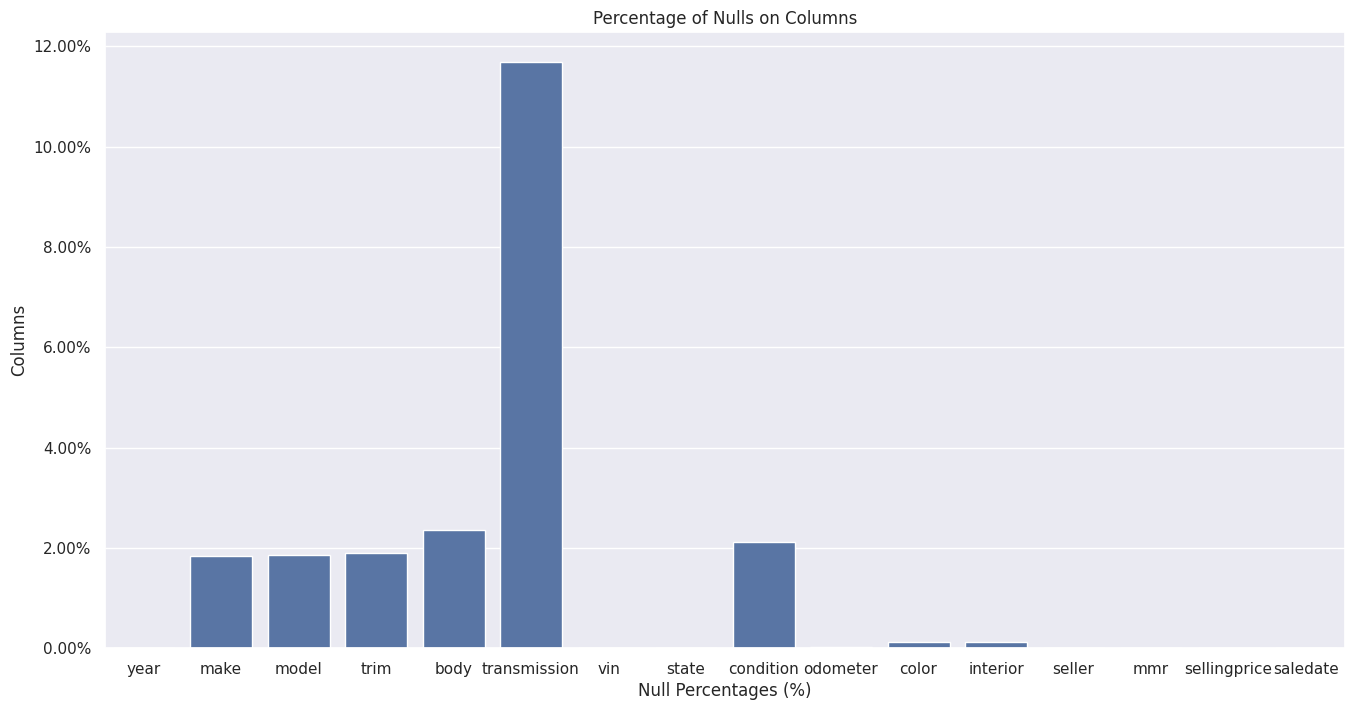

In [8]:
sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(16,8)})
fig = sns.barplot(df_nulls, x="column_name", y="null_percents")

plt.xlabel("Null Percentages (%)")
plt.ylabel("Columns")
plt.title("Percentage of Nulls on Columns")

vals = fig.get_yticks()
fig.set_yticklabels((['{:,.2%}'.format(x) for x in vals]))

plt.show()


This means that the only candidate do Feature Selection based on Completeness is transmissions, although it is still far from benchmark threshold for this selection.

## 3.2. Saledate Handling

In [9]:
df.saledate.dtypes

dtype('O')

In [10]:
#dropping NaN values in order to convert
df = df_test.copy().dropna()

#creating adjusted field of saledate to get date on m-d-Y format
df['saledate_adj'] = df['saledate'].apply(lambda x: datetime.strptime(converte_mes(x[4:15]),"%m %d %Y")  if isinstance(x, str) else x)

#creating converted date field
df['conv_data'] = df['saledate_adj'].map(datetime.toordinal)

#creating year field as integer
df['saleyear'] = df['saledate_adj'].apply(lambda x: int(x.year))


Foi utilizado o dropna devido a pequena quantidade de nulos na grande maioria dos registros, além de evidenciados problemas de inconsistência em outras colunas em conjunto com nulo na coluna de maior ocorrência ('transmissions'). Também já estamos trabalhando com um cenário desbalanceado, com grande número de registros.

## 3.3. Validity
Are the values as expected?

### 3.3.1.Make

In [11]:
print(df.make.describe())
print(df.groupby('make').year.count().index)

count     472325
unique        53
top         Ford
freq       81013
Name: make, dtype: object
Index(['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac',
       'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT', 'Ferrari', 'Fisker',
       'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda', 'Hyundai', 'Infiniti', 'Isuzu',
       'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus',
       'Lincoln', 'Lotus', 'MINI', 'Maserati', 'Mazda', 'Mercedes-Benz',
       'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac',
       'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru',
       'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'smart'],
      dtype='object', name='make')


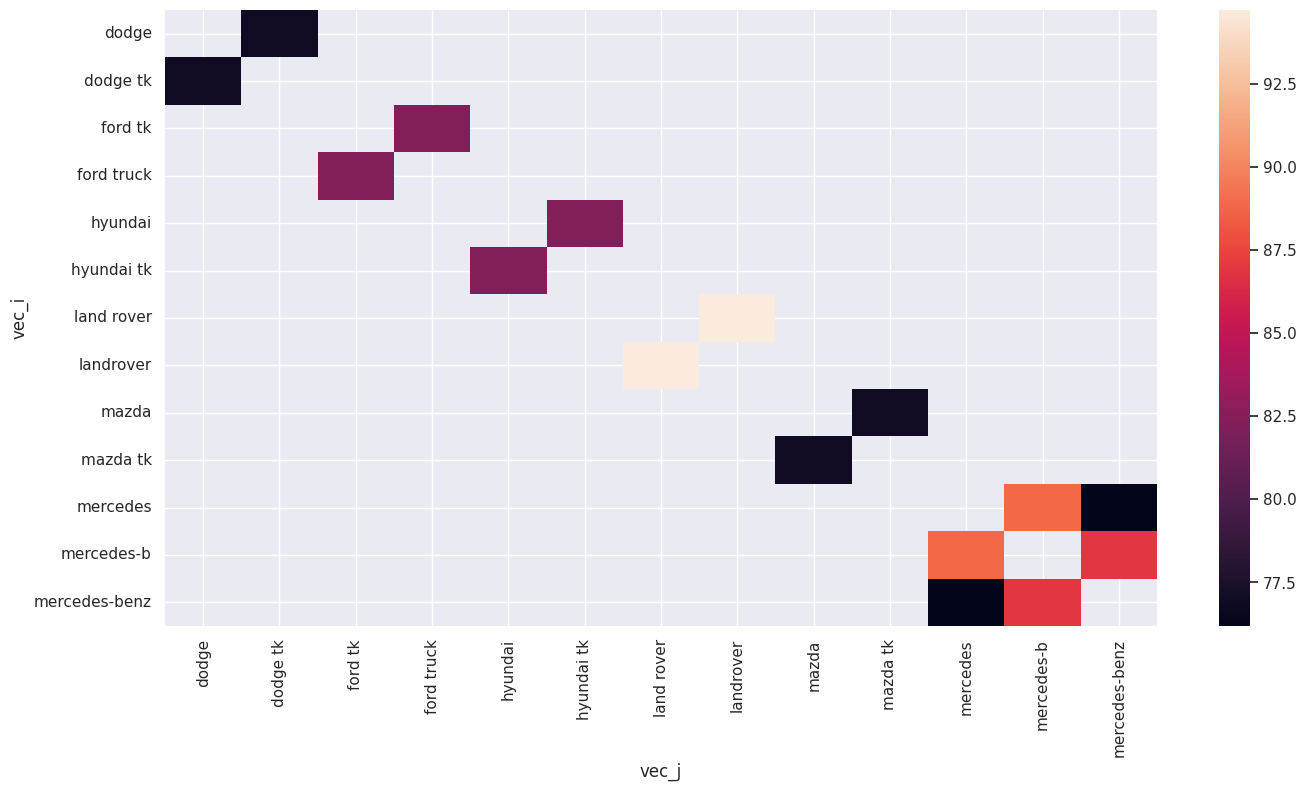

In [12]:
#ajustando todos os rotulos para letra minuscula
df_test['make_adjusted'] = df_test['make'].apply(lambda x : x.lower()  if isinstance(x, str) else x)

#ajuste de proximidade de palavras por inspeção do heatmap

vec_i,vec_j, vec_similarity = [],[],[]
for name_i in df_test.groupby('make_adjusted').year.count().index:
    for name_j in df_test.groupby('make_adjusted').year.count().index:
        vec_i.append(name_i)
        vec_j.append(name_j)
        vec_similarity.append(fuzz.ratio(name_i, name_j))

df_vec_i = pd.DataFrame(vec_i).rename(columns={0:'vec_i'})
df_vec_j = pd.DataFrame(vec_j).rename(columns={0:'vec_j'})
df_vec_similarity = pd.DataFrame(vec_similarity).rename(columns={0:'vec_similarity'})


df_similarity = df_vec_i.merge(df_vec_j, left_index= True, right_index= True)
df_similarity = df_similarity.merge(df_vec_similarity, left_index= True,right_index=True)

df_similarity_plot = df_similarity.copy()
df_similarity_plot = df_similarity_plot[df_similarity_plot['vec_similarity'] >= 75]
df_similarity_plot = df_similarity_plot[df_similarity_plot['vec_similarity'] < 100]

similarity_matrix = df_similarity_plot.pivot("vec_i",'vec_j','vec_similarity')
sns.heatmap(similarity_matrix)

del vec_i,vec_j,vec_similarity
del df_vec_i,df_vec_j,df_vec_similarity
del df_similarity_plot,similarity_matrix

Portanto, os casos de ajuste são os da mercedes, mercedes-b e landrover com land rover. Os casos de tk e truck são marcas de caminhão e serão mantidas separadas. Há um caso adicional de tratamento para 'vw' como 'volkswagen'

count     472325
unique        53
top         ford
freq       81013
Name: make_adjusted, dtype: object
Index(['acura', 'aston martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac',
       'chevrolet', 'chrysler', 'daewoo', 'dodge', 'ferrari', 'fiat', 'fisker',
       'ford', 'geo', 'gmc', 'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu',
       'jaguar', 'jeep', 'kia', 'lamborghini', 'land rover', 'lexus',
       'lincoln', 'lotus', 'maserati', 'mazda', 'mercedes-benz', 'mercury',
       'mini', 'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac',
       'porsche', 'ram', 'rolls-royce', 'saab', 'saturn', 'scion', 'smart',
       'subaru', 'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo'],
      dtype='object', name='make_adjusted')


<Axes: xlabel='Count', ylabel='make_adjusted'>

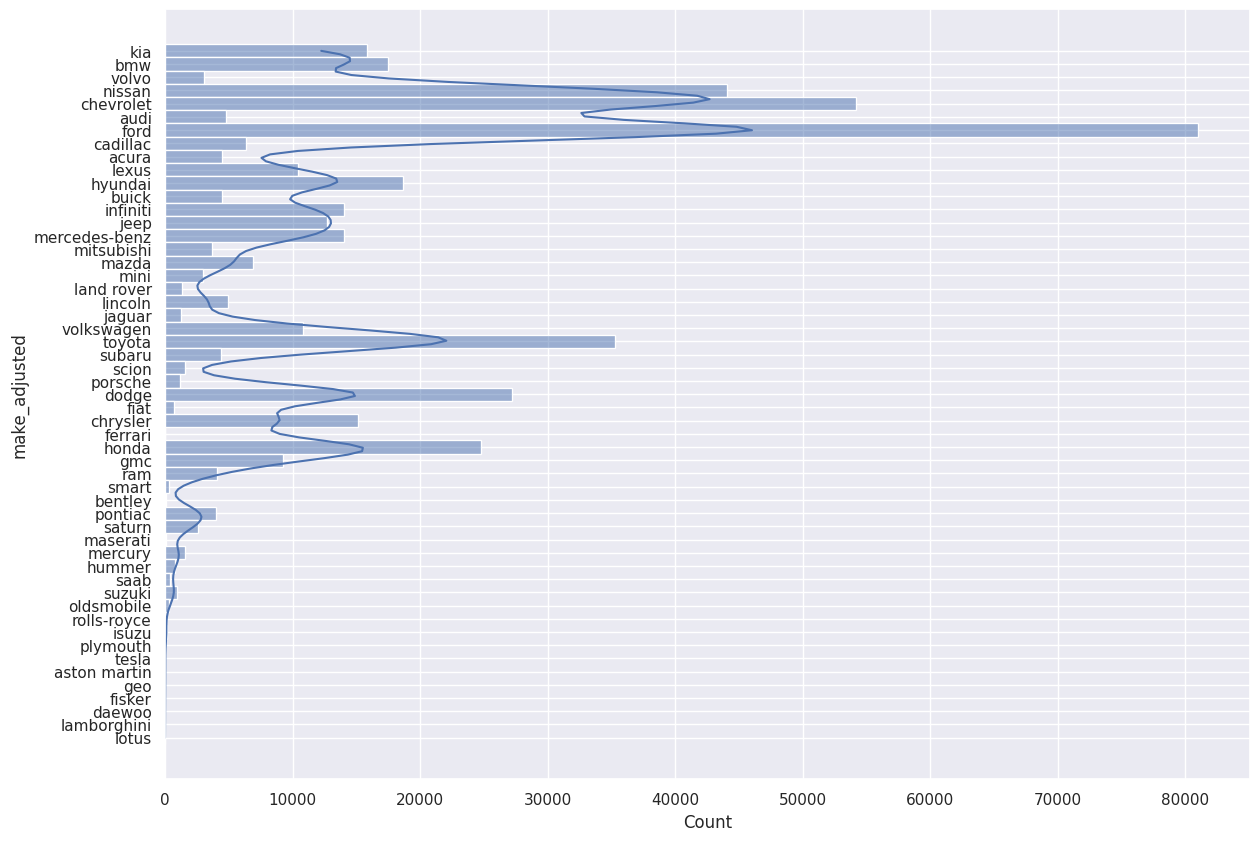

In [13]:
#tratamento completo via inspeção
def trata_nome_marca(nomes):
    nome_adj = re.sub('tk','truck',nomes.lower())
    match nome_adj:
        case 'vw': return 'volkswagen'
        case 'landrover': return 'land rover'
        case 'mercedes-b': return 'mercedes'
        #case 'mercedes-benz' return 'mercedes'
        case default: return nome_adj


#ajuste completo
df['make_adjusted'] = df['make'].apply(lambda x : trata_nome_marca(x)  if isinstance(x, str) else x)

print(df.make_adjusted.describe())
print(df.groupby('make_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(14,10)})
sns.histplot(data=df, y="make_adjusted",kde = True)


In [14]:
l_make = len(df.groupby('make_adjusted').year.count().index)
print('Número de Rótulos: ',l_make)

Número de Rótulos:  53


### 3.3.2.Model

In [15]:
#primeira versão de ajuste na coluna make
df['model_adjusted'] = df['model'].apply(lambda x : x.lower()  if isinstance(x, str) else x)

print(df.model_adjusted.describe())
print(df.groupby('model_adjusted').year.count().index)


count     472325
unique       764
top       altima
freq       16346
Name: model_adjusted, dtype: object
Index(['1 series', '1500', '190-class', '2 series', '200', '200sx', '2500',
       '3', '3 series', '3 series gran turismo',
       ...
       'yaris', 'yukon', 'yukon denali', 'yukon hybrid', 'yukon xl', 'z3',
       'z4', 'z4 m', 'zdx', 'zephyr'],
      dtype='object', name='model_adjusted', length=764)


In [16]:
#pegando apenas as colunas que somam 80% da base e agrupando as demais em apenas uma

df_model = pd.DataFrame(df.groupby('model_adjusted').year.count()).reset_index().sort_values(by='year',ascending=False)
df_model['cumsum_col'] = df_model.year.cumsum() / df_model.year.sum().sum() * 100

df_model = df_model[df_model['cumsum_col'] <= 80.0].drop(columns='year')
df = df.merge(df_model, on='model_adjusted' , how='left')
df.loc[df.cumsum_col.isna() , 'model_adjusted'] = 'outros'
df = df.drop(columns = 'cumsum_col')


count     472325
unique       129
top       outros
freq       94912
Name: model_adjusted, dtype: object
Index(['1500', '200', '3 series', '300', '4runner', '5 series', '7 series',
       'a4', 'acadia', 'accent',
       ...
       'trailblazer', 'traverse', 'tundra', 'versa', 'wrangler', 'x3', 'x5',
       'yaris', 'yukon', 'yukon xl'],
      dtype='object', name='model_adjusted', length=129)


<Axes: xlabel='Count', ylabel='model_adjusted'>

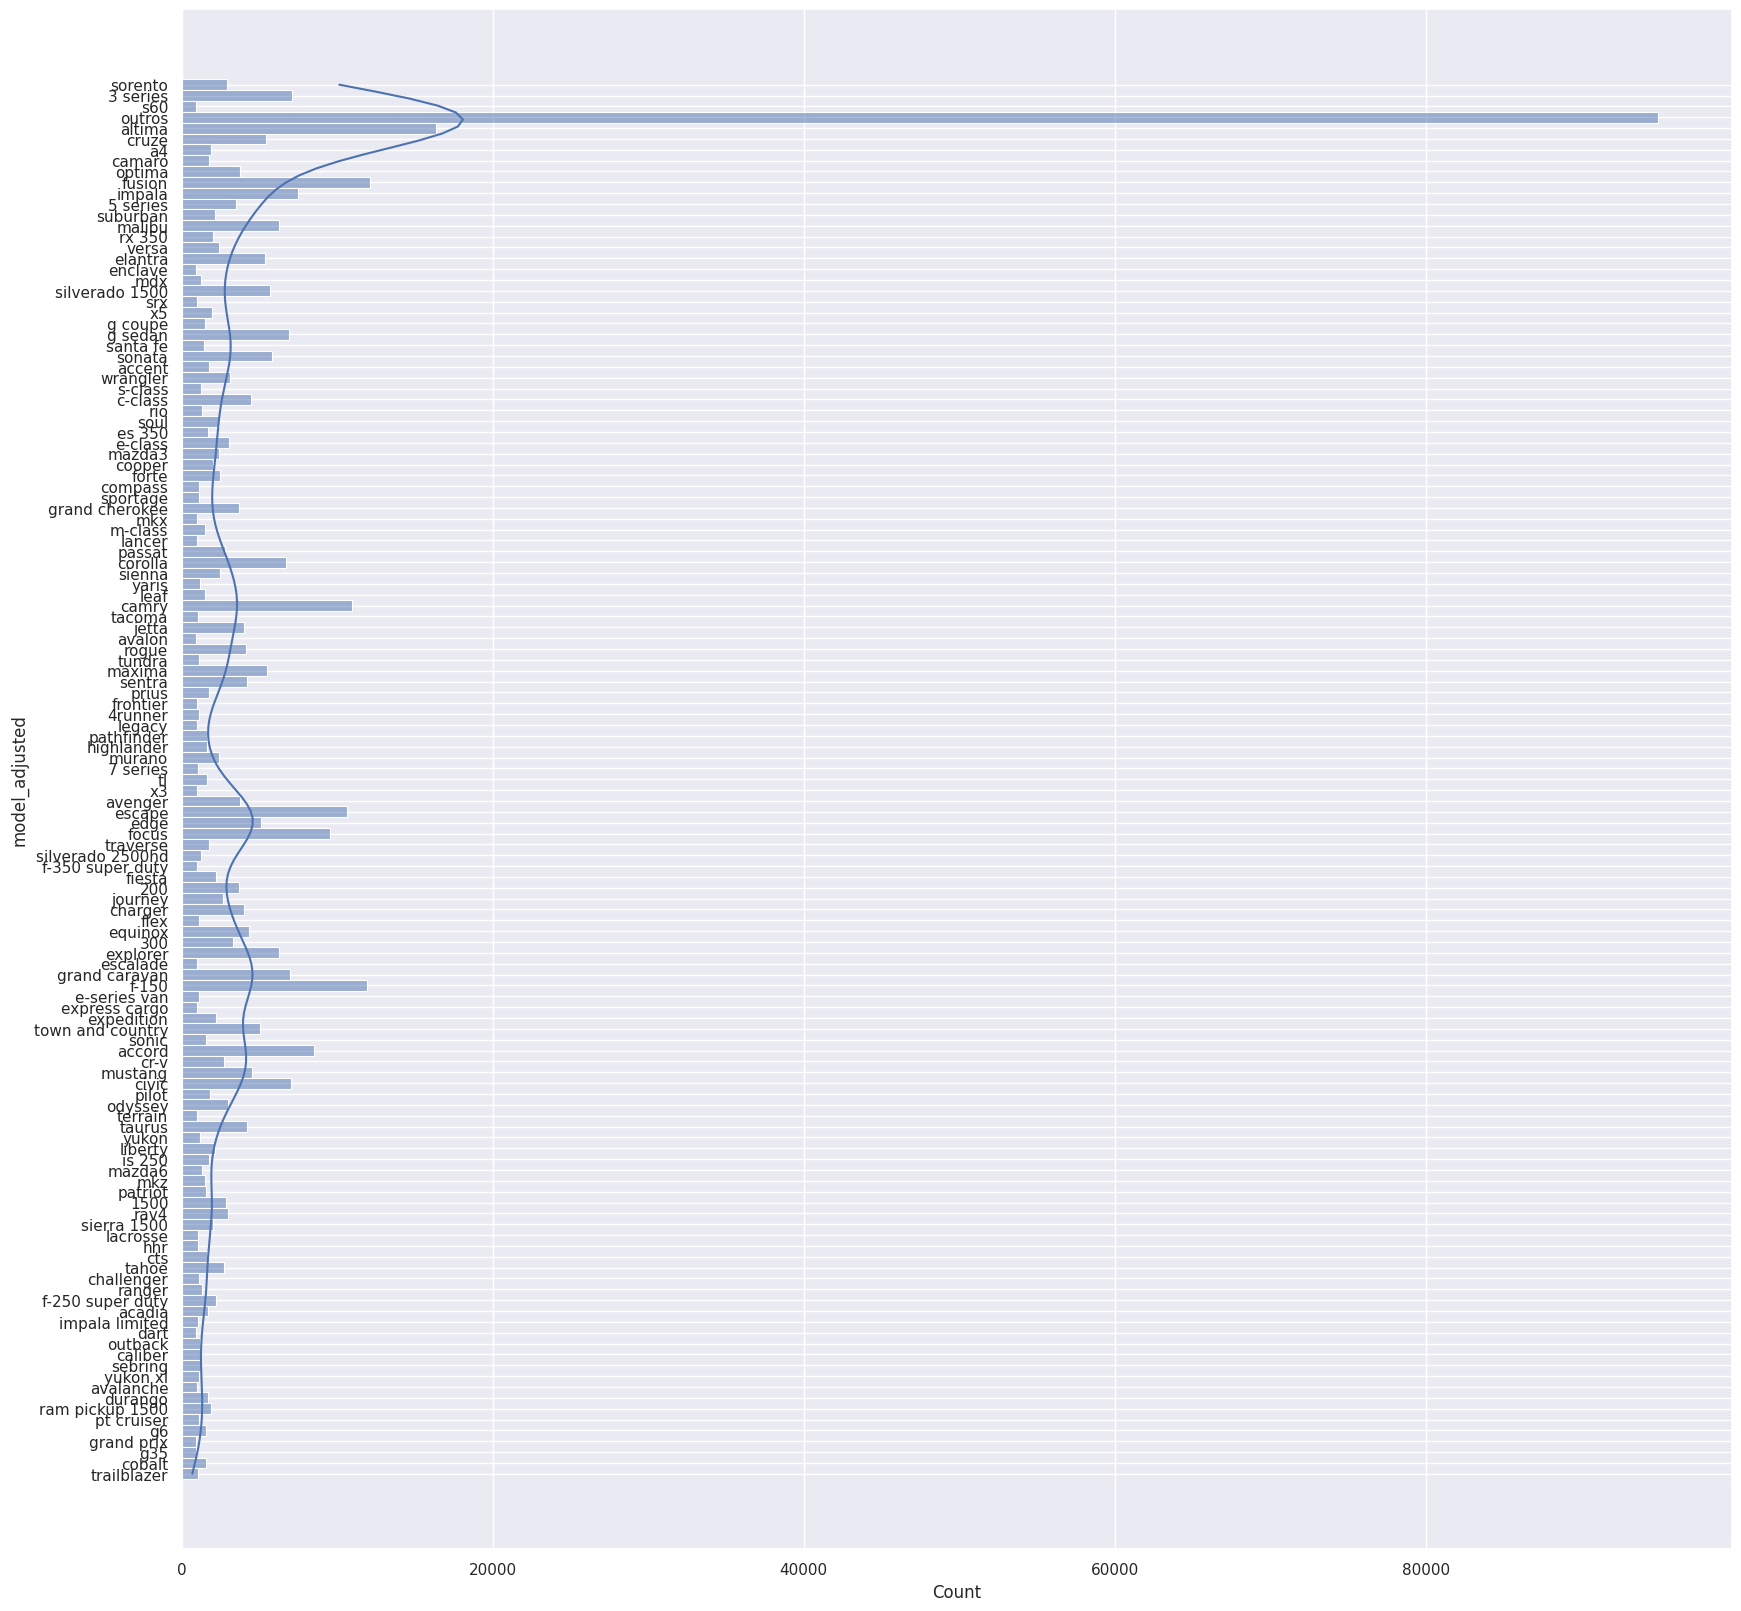

In [17]:

print(df.model_adjusted.describe())
print(df.groupby('model_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(20,20)})
sns.histplot(data=df, y="model_adjusted",kde = True)

In [18]:
l_model = len(df.groupby('model_adjusted').year.count().index)
print('Número de Rótulos: ',l_model)

Número de Rótulos:  129


### 3.3. Trim

In [19]:
#primeira versão de ajuste na coluna make
df['trim_adjusted'] = df['trim'].apply(lambda x : x.lower()  if isinstance(x, str) else x)


print(df.trim_adjusted.describe())
print(df.groupby('trim_adjusted').year.count().index)


count     472325
unique      1475
top         base
freq       48780
Name: trim_adjusted, dtype: object
Index(['!', '(1999.5) xe', '+', '1', '1.6', '1.6 base', '1.6 s', '1.6 s plus',
       '1.6 sl', '1.6 sv',
       ...
       'zx3 s', 'zx3 ses', 'zx4 se', 'zx4 ses', 'zx4 st', 'zx5', 'zx5 premium',
       'zx5 se', 'zx5 ses', 'zxw ses'],
      dtype='object', name='trim_adjusted', length=1475)


In [20]:
#pegando apenas as colunas que somam 80% da base e agrupando as demais em apenas uma

df_trim = pd.DataFrame(df.groupby('trim_adjusted').year.count()).reset_index().sort_values(by='year',ascending=False)
df_trim['cumsum_col'] = df_trim.year.cumsum() / df_trim.year.sum().sum() * 100

df_trim = df_trim[df_trim['cumsum_col'] <= 80.0].drop(columns='year')
df = df.merge(df_trim, on='trim_adjusted' , how='left')
df.loc[df.cumsum_col.isna() , 'trim_adjusted'] = 'outros'
df = df.drop(columns = 'cumsum_col')

<Axes: xlabel='Count', ylabel='trim_adjusted'>

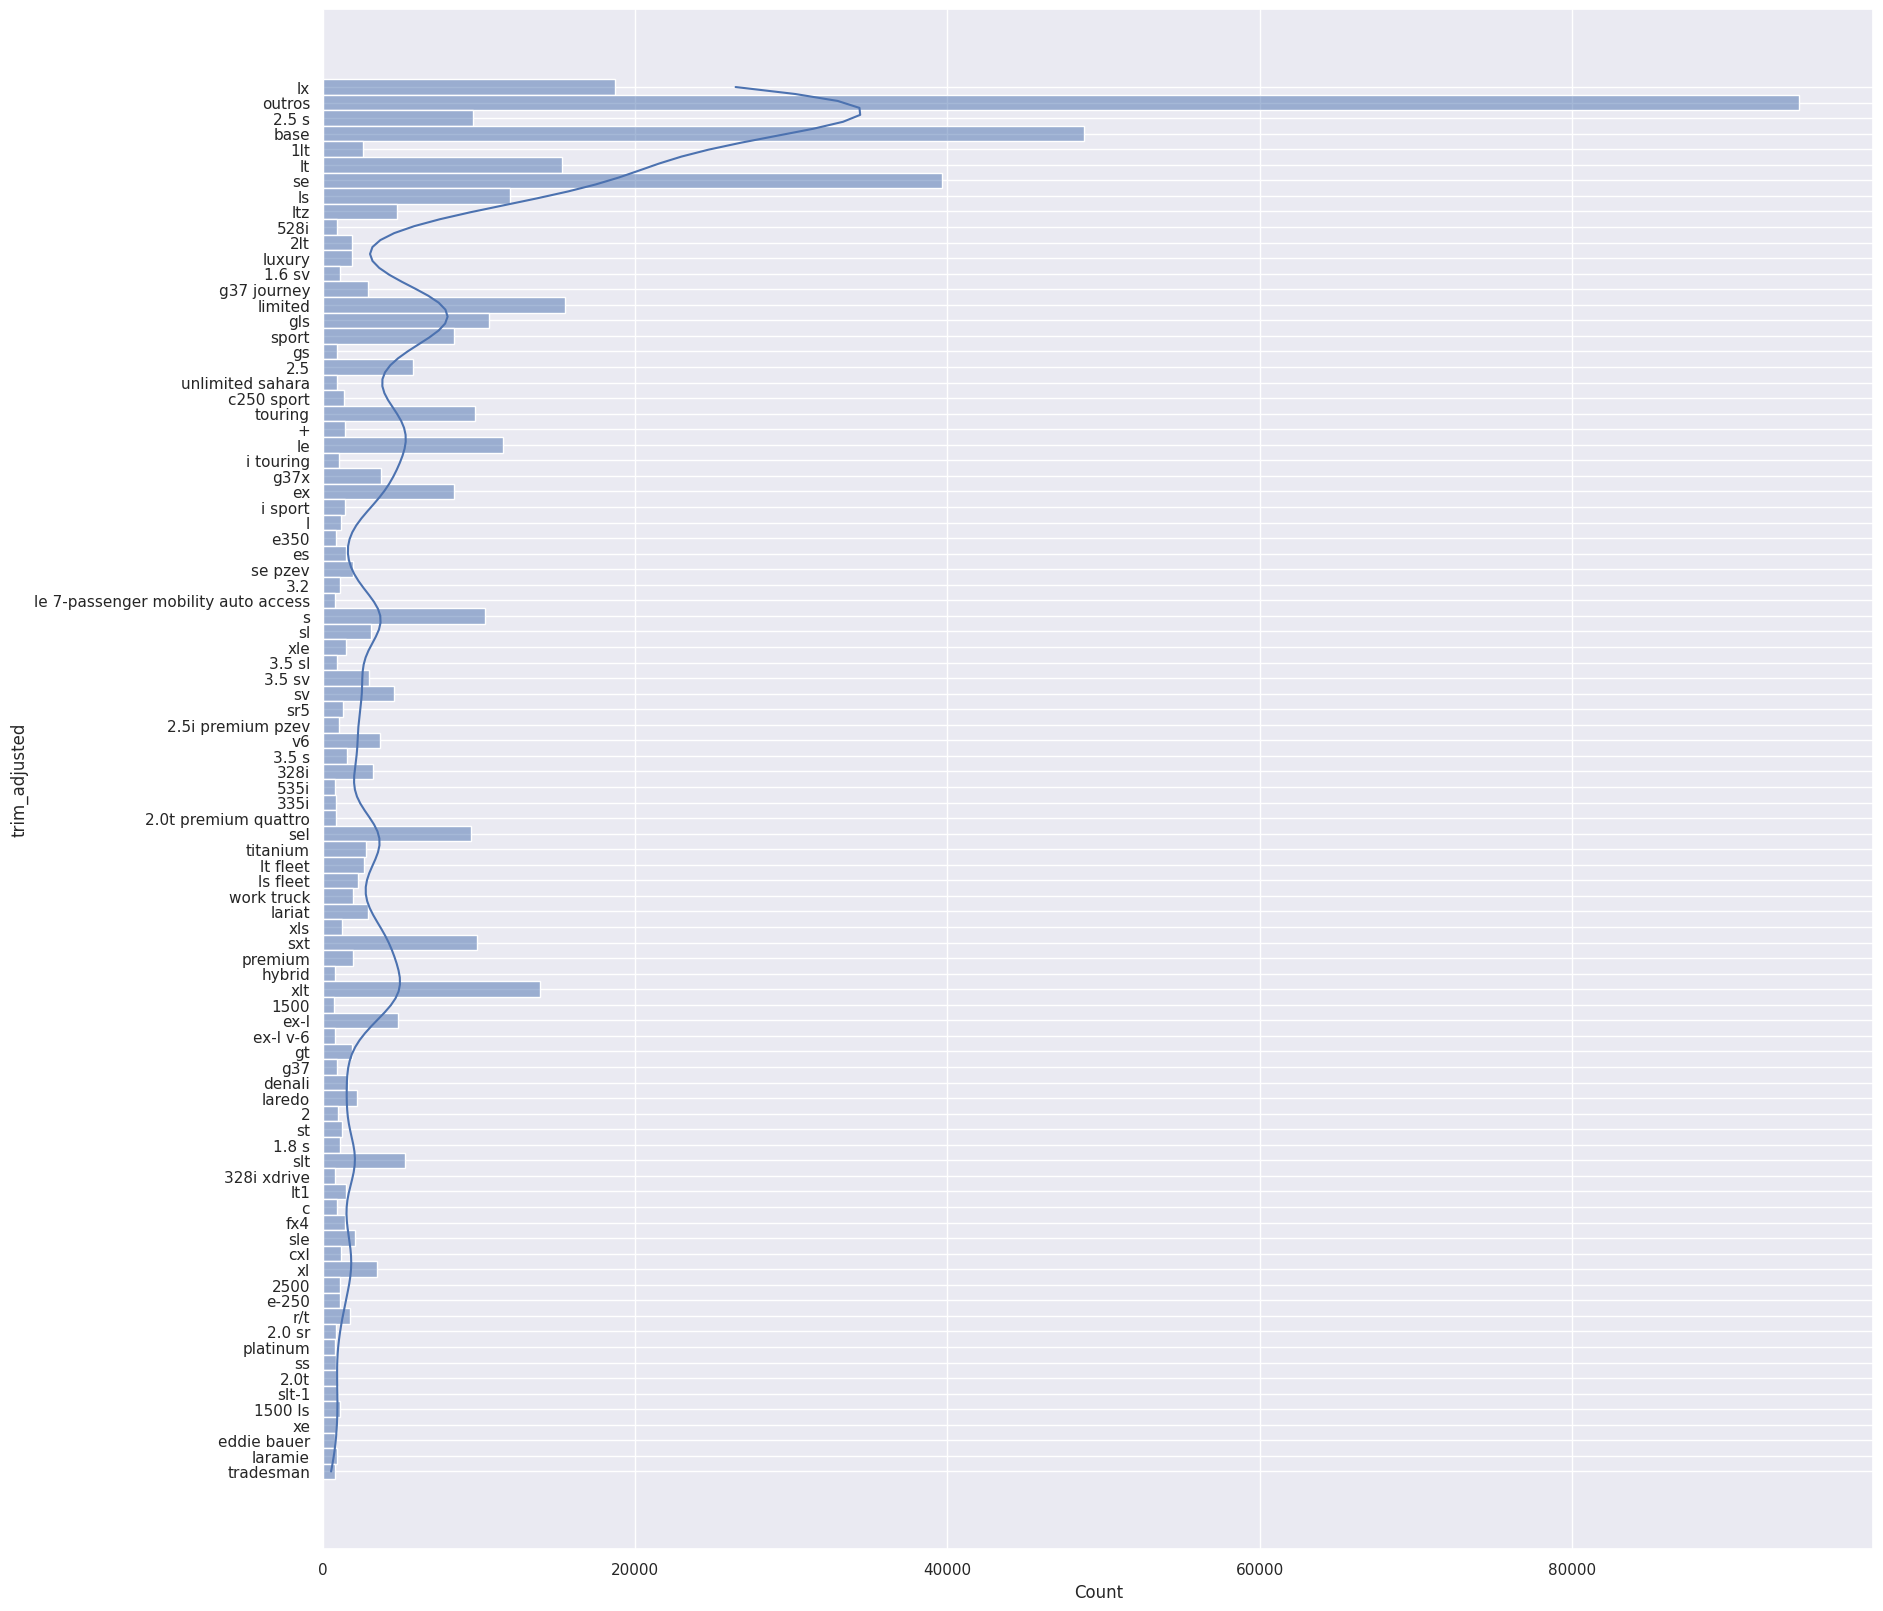

In [21]:
sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(20,20)})
sns.histplot(data=df, y="trim_adjusted",kde = True)

In [22]:
l_trim = len(df.groupby('trim_adjusted').year.count().index)
print('Número de Rótulos: ',l_trim)

Número de Rótulos:  90


### 3.3.4.Model

count     472325
unique        45
top        sedan
freq      211298
Name: body_adjusted, dtype: object
Index(['access cab', 'beetle convertible', 'cab plus', 'cab plus 4',
       'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab',
       'cts coupe', 'cts wagon', 'cts-v coupe', 'cts-v wagon', 'double cab',
       'e-series van', 'elantra coupe', 'extended cab', 'g convertible',
       'g coupe', 'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe',
       'granturismo convertible', 'hatchback', 'king cab', 'koup', 'mega cab',
       'minivan', 'promaster cargo van', 'q60 convertible', 'q60 coupe',
       'quad cab', 'ram van', 'regular cab', 'regular-cab', 'sedan',
       'supercab', 'supercrew', 'suv', 'transit van', 'tsx sport wagon', 'van',
       'wagon', 'xtracab'],
      dtype='object', name='body_adjusted')


<Axes: xlabel='Count', ylabel='body_adjusted'>

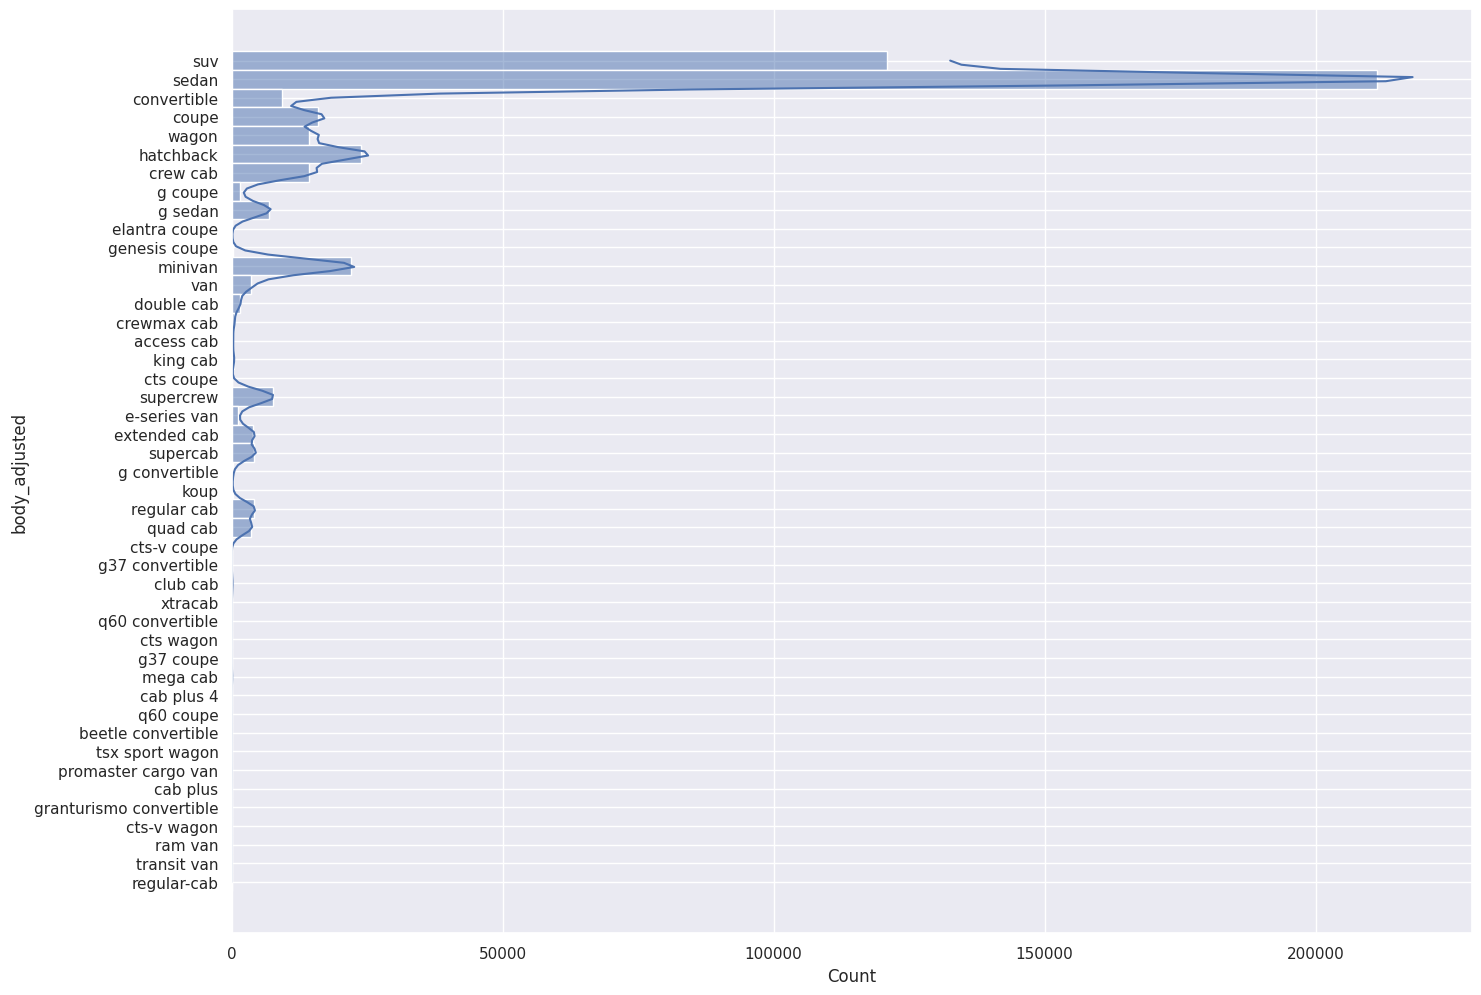

In [23]:
#primeira versão de ajuste na coluna make
df['body_adjusted'] = df['body'].apply(lambda x : x.lower()  if isinstance(x, str) else x)

print(df.body_adjusted.describe())
print(df.groupby('body_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(16,12)})
sns.histplot(data=df, y="body_adjusted",kde = True)

In [24]:
#pegando apenas as colunas que somam 80% da base e agrupando as demais em apenas uma

df_body = pd.DataFrame(df.groupby('body_adjusted').year.count()).reset_index().sort_values(by='year',ascending=False)
df_body['cumsum_col'] = df_body.year.cumsum() / df_body.year.sum().sum() * 100

df_body = df_body[df_body['cumsum_col'] <= 80.0].drop(columns='year')
df = df.merge(df_body, on='body_adjusted' , how='left')
df.loc[df.cumsum_col.isna() , 'body_adjusted'] = 'outros'
df = df.drop(columns = 'cumsum_col')


count     472325
unique         4
top        sedan
freq      211298
Name: body_adjusted, dtype: object
Index(['hatchback', 'outros', 'sedan', 'suv'], dtype='object', name='body_adjusted')


<Axes: xlabel='Count', ylabel='body_adjusted'>

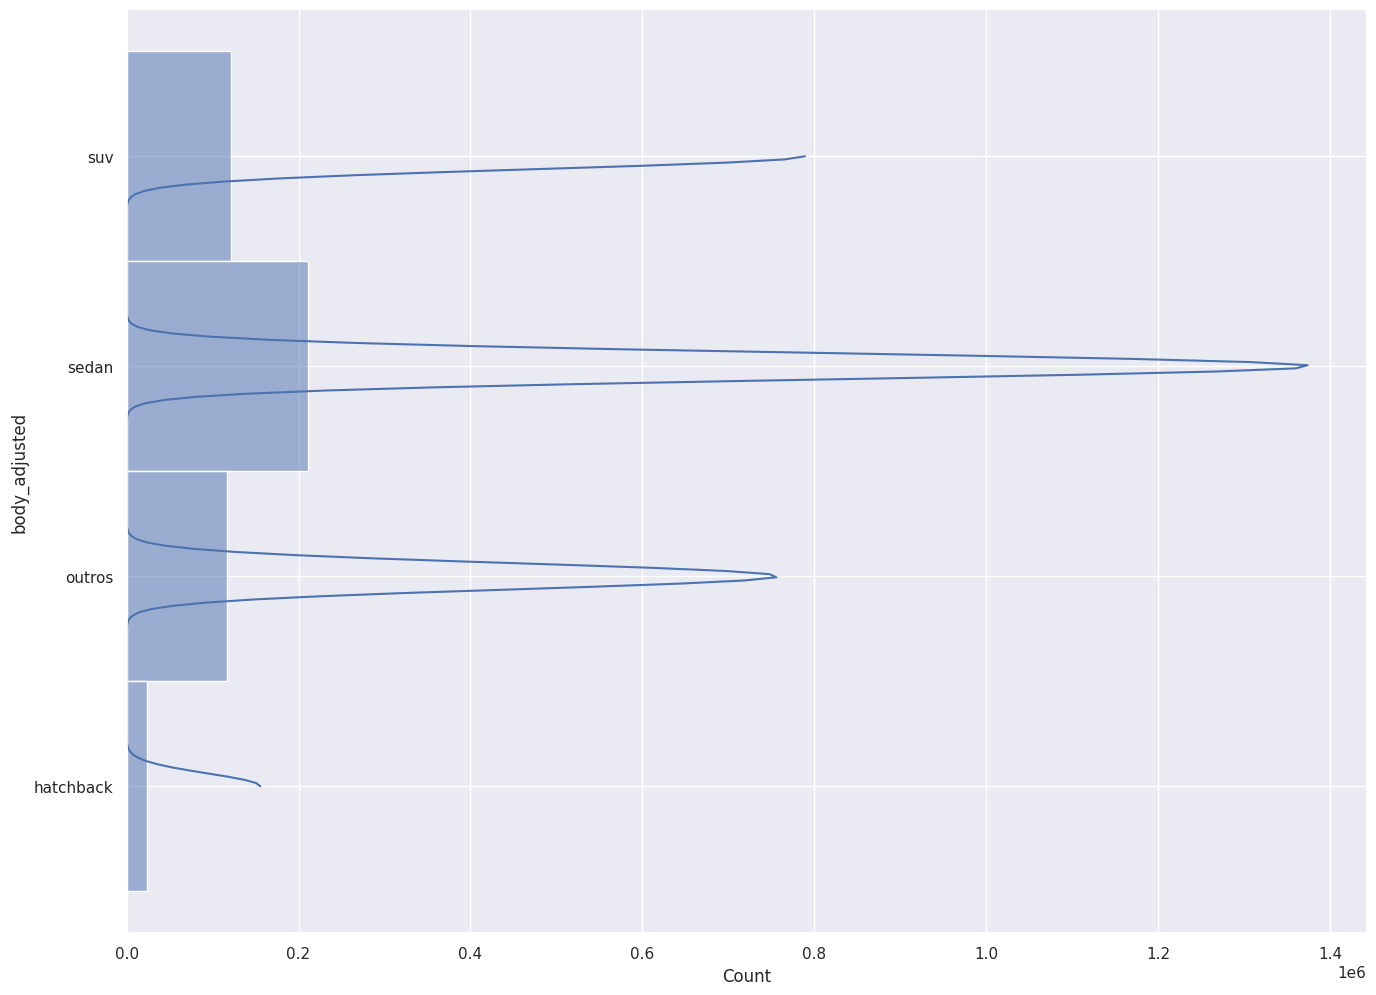

In [25]:
print(df.body_adjusted.describe())
print(df.groupby('body_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(16,12)})
sns.histplot(data=df, y="body_adjusted",kde = True)

In [26]:
l_body = len(df.groupby('body_adjusted').year.count().index)
print('Número de Rótulos: ',l_body)

Número de Rótulos:  4


### 3.5. Transmission

count        472325
unique            2
top       automatic
freq         455963
Name: transmission_adjusted, dtype: object
Index(['automatic', 'manual'], dtype='object', name='transmission_adjusted')


<Axes: xlabel='Count', ylabel='transmission_adjusted'>

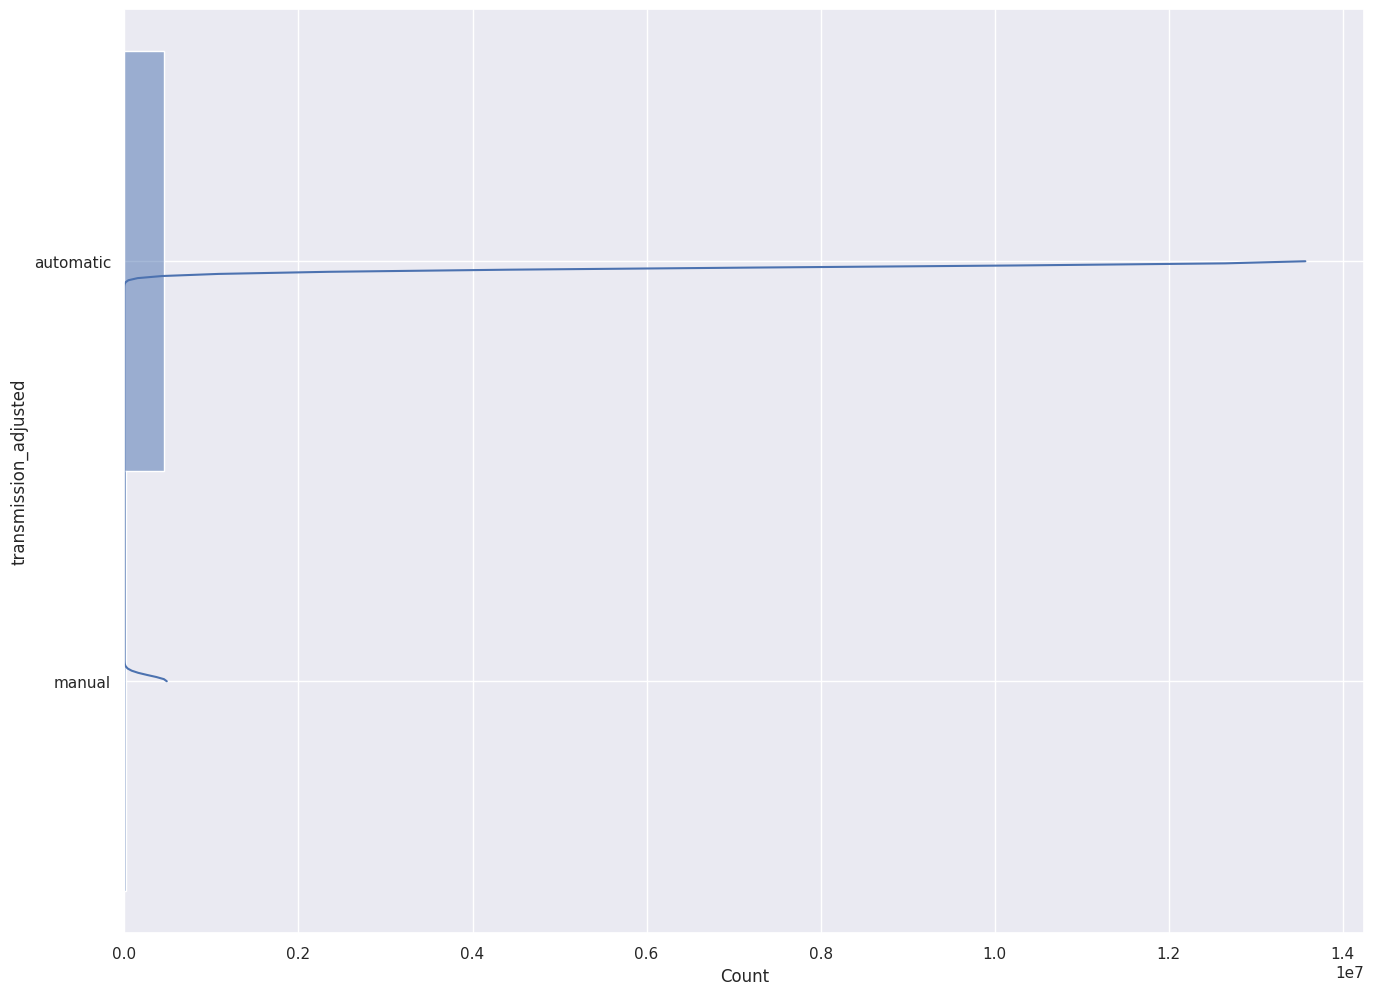

In [27]:
#primeira versão de ajuste na coluna make
df['transmission_adjusted'] = df['transmission'].apply(lambda x : x.lower()  if isinstance(x, str) else x)


print(df.transmission_adjusted.describe())
print(df.groupby('transmission_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(16,12)})
sns.histplot(data=df, y="transmission_adjusted",kde = True)

In [28]:
l_transmission = len(df.groupby('transmission_adjusted').year.count().index)
print('Número de Rótulos: ',l_transmission)

Número de Rótulos:  2


### 3.6. Vin

In [29]:
df_vin = df[['vin']].copy()
df_vin['tamanho'] = df_vin['vin'].apply(lambda x : len(x))
df_vin.groupby('tamanho').count()

vin
tamanho        
17       472325

In [30]:
pd.DataFrame(df_vin.groupby('vin').count()).reset_index().sort_values(by='tamanho', ascending = False)

vin  tamanho
449368  wddgf56x78f009940        4
336199  5uxfe43579l274932        4
458223  wp0ca2988xu629622        4
68515   1ftfw1cv5afb30053        4
319169  5n1ar1nn2bc632869        4
...                   ...      ...
156370  1n4al2ap2cc221756        1
156369  1n4al2ap2cc221675        1
156368  1n4al2ap2cc221045        1
156367  1n4al2ap2cc218646        1
465767  zhwgu22t97la05738        1

[465768 rows x 2 columns]

In [31]:
df[df['vin'] == 'wddgf56x78f009940']

year           make    model        trim   body transmission  \
90009   2008  Mercedes-Benz  C-Class  C350 Sport  Sedan    automatic   
173691  2008  Mercedes-Benz  C-Class  C350 Sport  Sedan    automatic   
223256  2008  Mercedes-Benz  C-Class  C350 Sport  Sedan    automatic   
370030  2008  Mercedes-Benz  C-Class  C350 Sport  Sedan    automatic   

                      vin state  condition  odometer  ... sellingprice  \
90009   wddgf56x78f009940    ca       35.0   89385.0  ...      12900.0   
173691  wddgf56x78f009940    ca       32.0   89392.0  ...      11250.0   
223256  wddgf56x78f009940    nv       28.0   89417.0  ...      11700.0   
370030  wddgf56x78f009940    ca       27.0   90066.0  ...      12500.0   

                                       saledate saledate_adj  conv_data  \
90009   Wed Jan 14 2015 04:30:00 GMT-0800 (PST)   2015-01-14     735612   
173691  Wed Jan 28 2015 04:30:00 GMT-0800 (PST)   2015-01-28     735626   
223256  Fri Feb 06 2015 04:00:00 GMT-0800 (PST)   2015-02-06     735635   
370030  Tue May 19 2015 05:30:00 GMT-0700 (PDT)   2015-05-19     735737   

        saleyear  make_adjusted model_adjusted  trim_adjusted  body_adjusted  \
90009       2015  mercedes-benz        c-class         outros          sedan   
173691      2015  mercedes-benz        c-class         outros          sedan   
223256      2015  mercedes-benz        c-class         outros          sedan   
370030      2015  mercedes-benz        c-class         outros          sedan   

       transmission_adjusted  
90009              automatic  
173691             automatic  
223256             automatic  
370030             automatic  

[4 rows x 24 columns]

In [32]:
df = df.drop(columns= ['vin'])

Dada a alta cardinalidade e expressão de VIN como combinação linear de make, model, trim, body e transmission , a coluna será desconsiderada.

### 3.7. State

count     472325
unique        34
top           fl
freq       75243
Name: state_adjusted, dtype: object
Index(['al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la', 'ma', 'md',
       'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok',
       'or', 'pa', 'pr', 'sc', 'tn', 'tx', 'ut', 'va', 'wa', 'wi'],
      dtype='object', name='state_adjusted')


<Axes: xlabel='Count', ylabel='state_adjusted'>

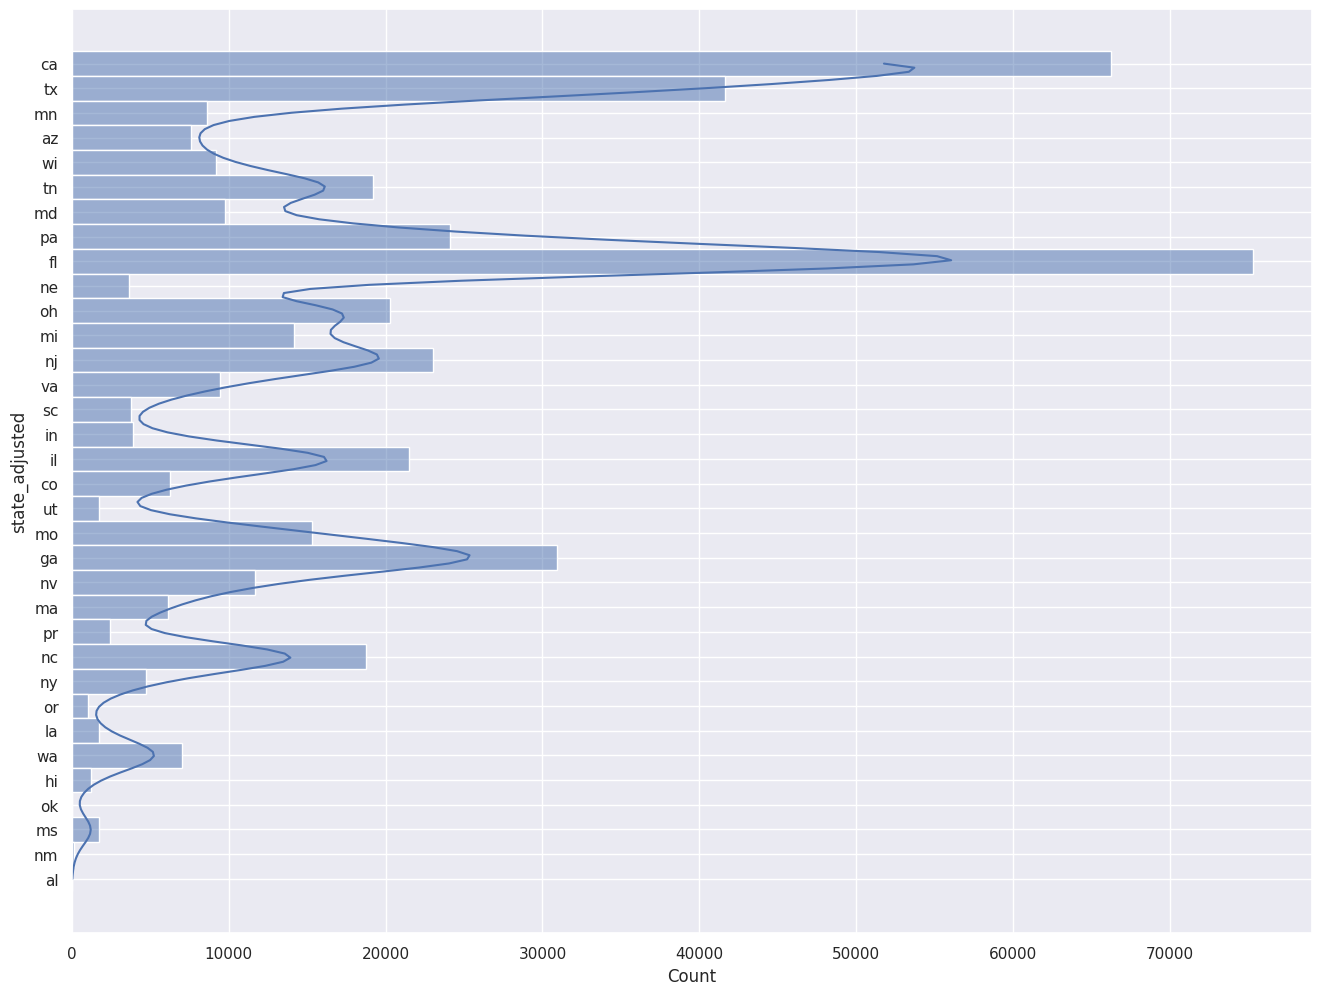

In [33]:
#primeira versão de ajuste na coluna make
df['state_adjusted'] = df['state'].apply(lambda x : x.lower()  if isinstance(x, str) else x)


print(df.state_adjusted.describe())
print(df.groupby('state_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(16,12)})
sns.histplot(data=df, y="state_adjusted",kde = True)

In [34]:
l_state = len(df.groupby('state_adjusted').year.count().index)
print('Número de Rótulos: ',l_state)

Número de Rótulos:  34


### 3.8. Condition

count    472325.000000
mean         30.774177
std          13.286866
min           1.000000
25%          24.000000
50%          35.000000
75%          41.000000
max          49.000000
Name: condition, dtype: float64
Float64Index([ 1.0,  2.0,  3.0,  4.0,  5.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0,
              17.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0,
              29.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 41.0,
              42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0],
             dtype='float64', name='condition')


<Axes: xlabel='Count', ylabel='condition'>

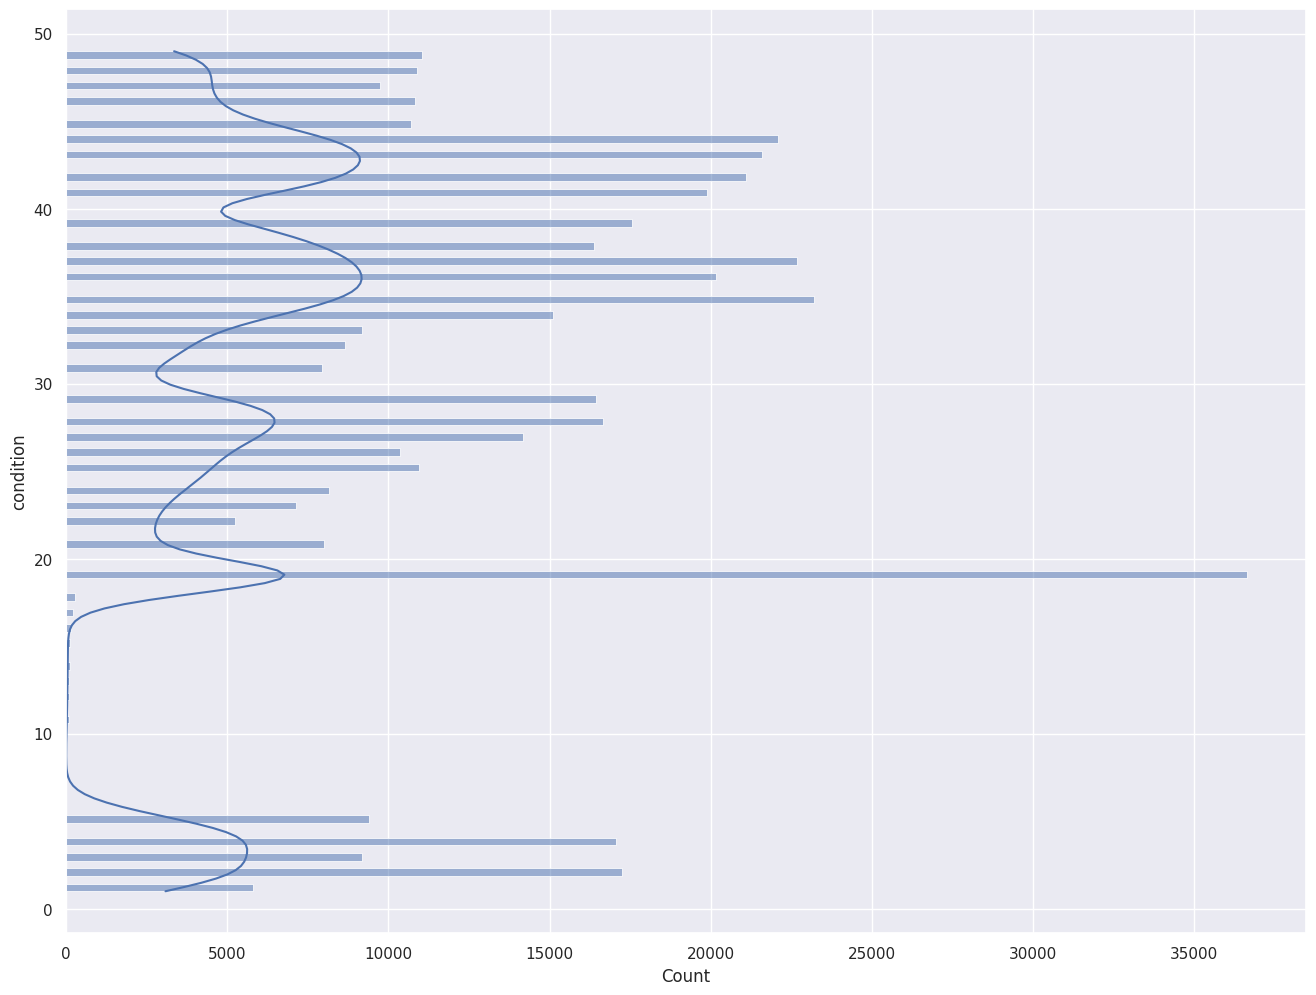

In [35]:
#primeira versão de ajuste na coluna make

print(df.condition.describe())
print(df.groupby('condition').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(16,12)})
sns.histplot(data=df, y="condition",kde = True)

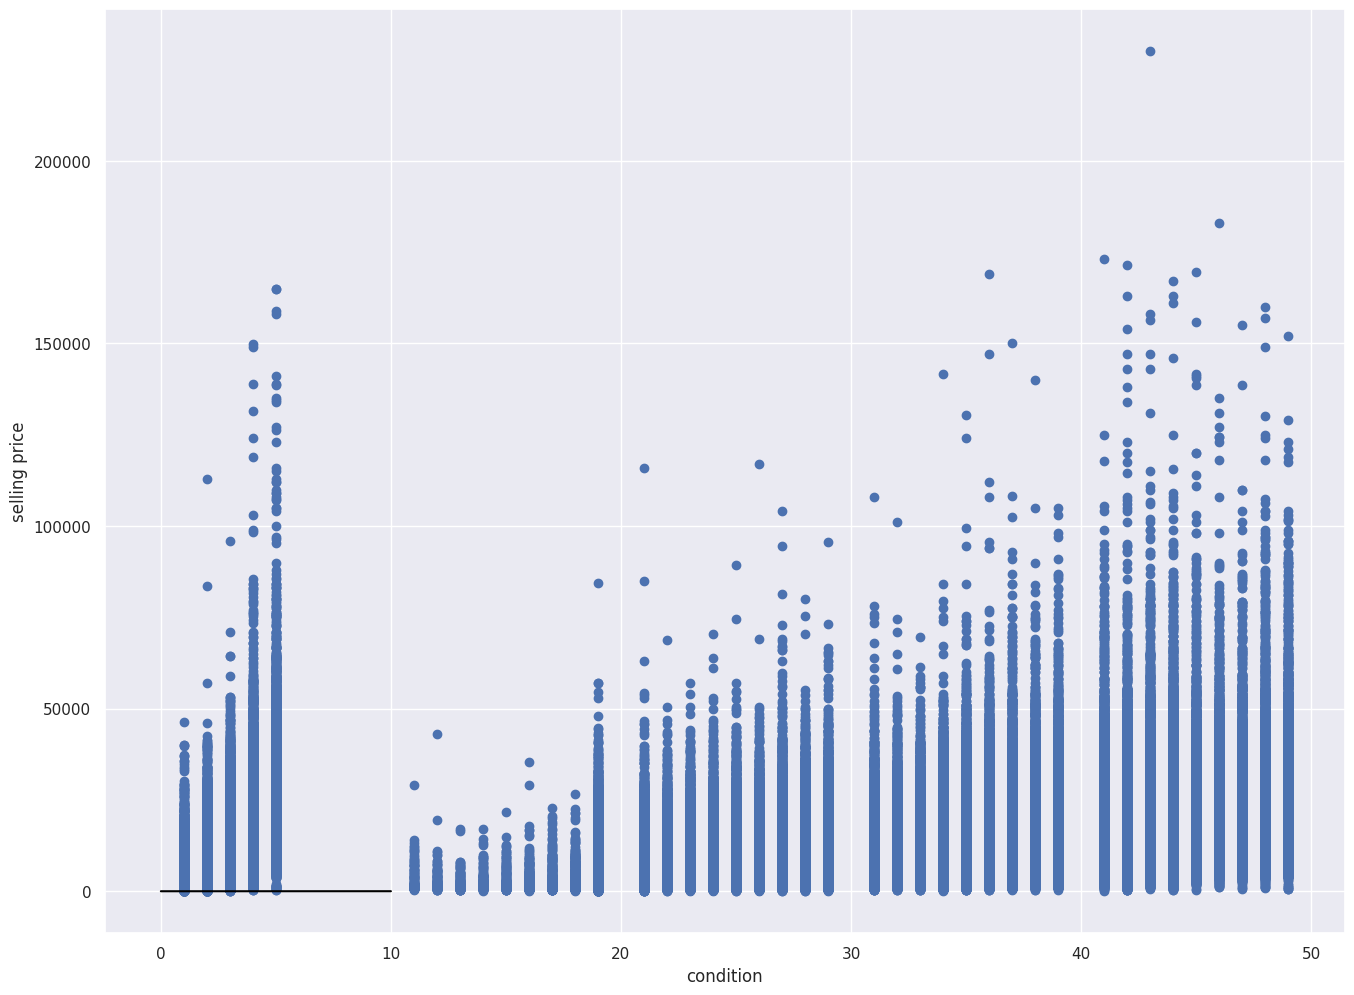

In [36]:
plt.scatter(df['condition'], df['sellingprice'])
#plt.xlim(0, 10)
#plt.ylim(0, 10)
plt.ylabel('selling price')
plt.xlabel('condition')
plt.plot([0,10], [0,10], 'black') #1 to 1 line

É uma variável numérica discreta correlacionada com a variável resposta. Comportamento anormal para valores entre 0 e 10. Potencial candidato a utilização de FDS (Feature Distribution Smoothening)

### 3.9. Odometer

In [37]:
df.odometer.describe()

count    472325.000000
mean      66701.732040
std       51939.586894
min           1.000000
25%       28137.000000
50%       51085.000000
75%       96590.000000
max      999999.000000
Name: odometer, dtype: float64

Necessidade de transformação para lidar com outlier de valor máximo e melhorar std.

### 3.10. Color

count     472325
unique        20
top        black
freq       93244
Name: color_adjusted, dtype: object
Index(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple', 'red',
       'silver', 'turquoise', 'white', 'yellow', '—'],
      dtype='object', name='color_adjusted')


<Axes: xlabel='Count', ylabel='color_adjusted'>

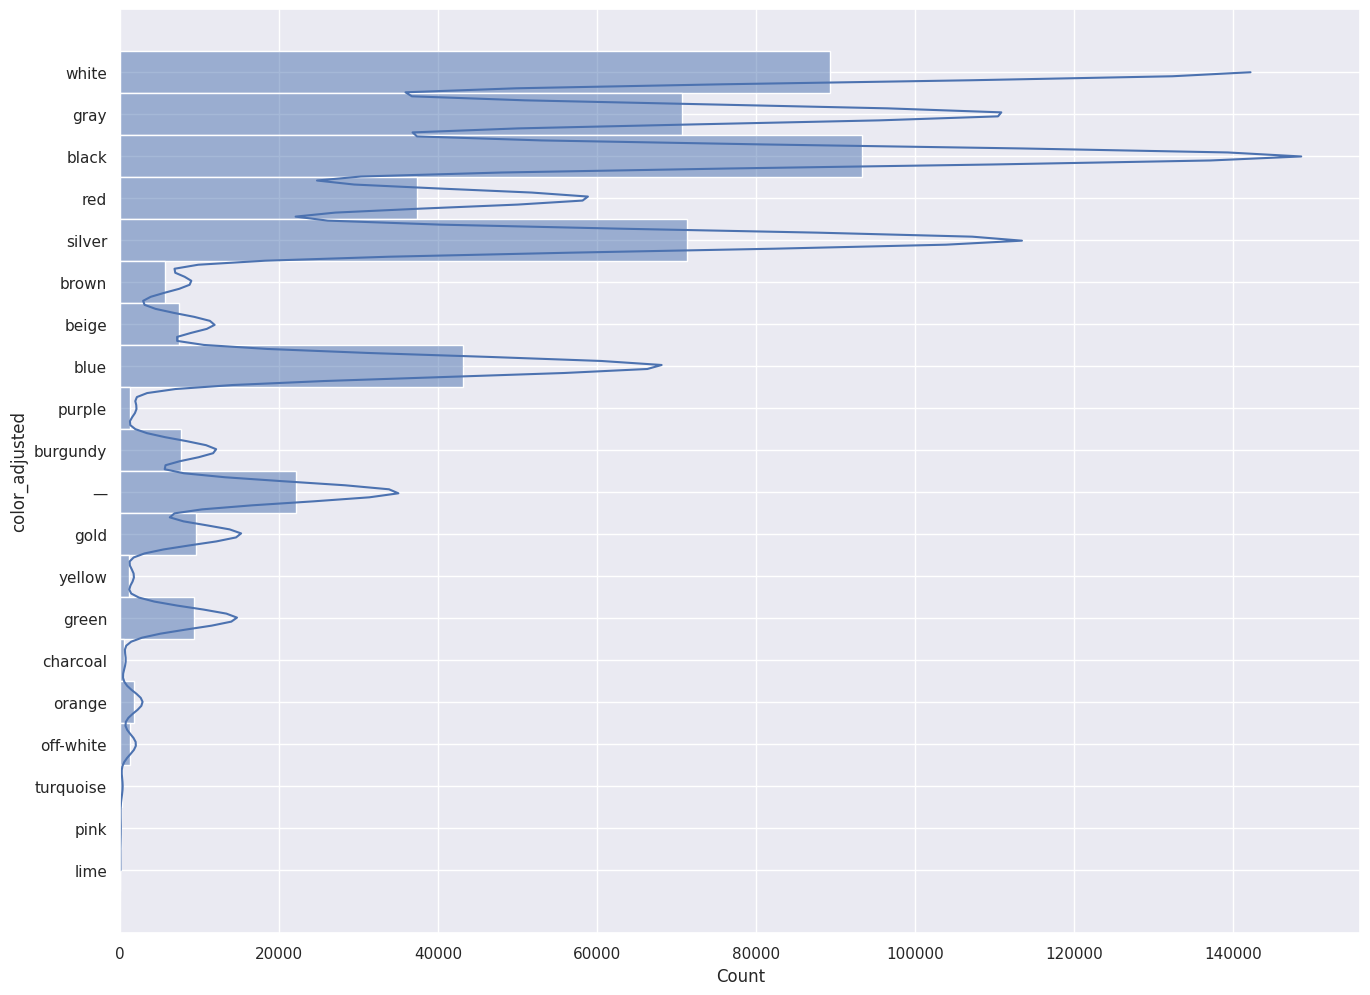

In [38]:
#primeira versão de ajuste na coluna make
df['color_adjusted'] = df['color'].apply(lambda x : x.lower()  if isinstance(x, str) else x)


print(df.color_adjusted.describe())
print(df.groupby('color_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(16,12)})
sns.histplot(data=df, y="color_adjusted",kde = True)

In [39]:
l_color = len(df.groupby('color_adjusted').year.count().index)
print('Número de Rótulos: ',l_color)

Número de Rótulos:  20


### 3.11. Interior

count     472325
unique        17
top        black
freq      209865
Name: interior_adjusted, dtype: object
Index(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray', 'green',
       'off-white', 'orange', 'purple', 'red', 'silver', 'tan', 'white',
       'yellow', '—'],
      dtype='object', name='interior_adjusted')


<Axes: xlabel='Count', ylabel='interior_adjusted'>

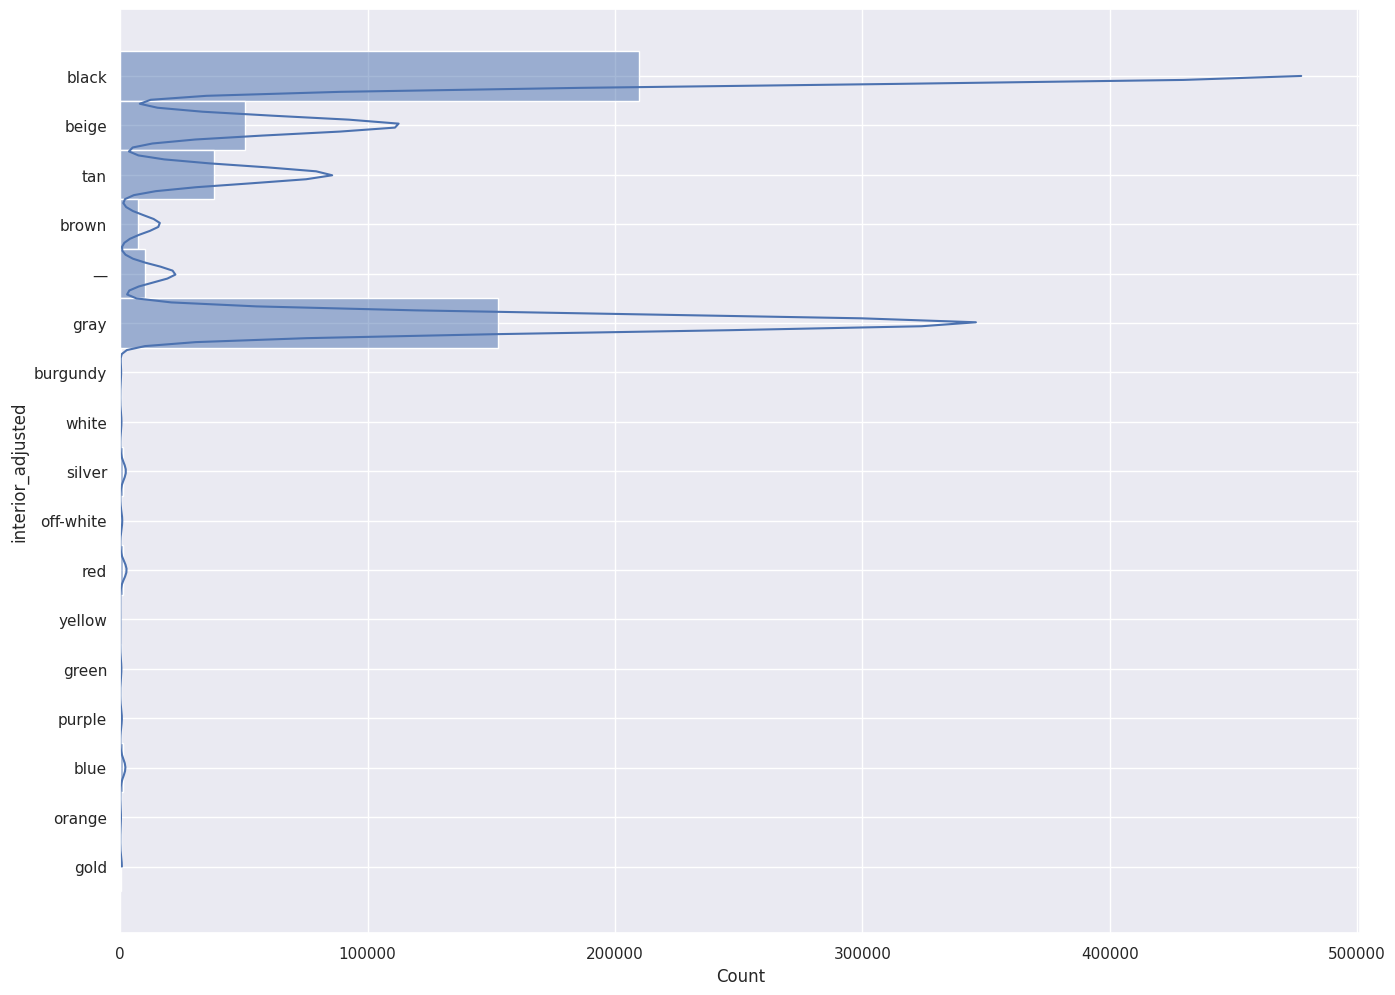

In [40]:
#primeira versão de ajuste na coluna make
df['interior_adjusted'] = df['interior'].apply(lambda x : x.lower()  if isinstance(x, str) else x)


print(df.interior_adjusted.describe())
print(df.groupby('interior_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(16,12)})
sns.histplot(data=df, y="interior_adjusted",kde = True)

In [41]:
l_interior = len(df.groupby('interior_adjusted').year.count().index)
print('Número de Rótulos: ',l_interior)

Número de Rótulos:  17


### 3.12. Seller

In [42]:
#primeira versão de ajuste na coluna make
df['seller_adjusted'] = df['seller'].apply(lambda x : x.lower()  if isinstance(x, str) else x)


print(df.seller_adjusted.describe())
print(df.groupby('seller_adjusted').year.count().index)


count                            472325
unique                            11923
top       ford motor credit company llc
freq                              17756
Name: seller_adjusted, dtype: object
Index(['1 cochran of monroeville', '101motors', '143 auto sales inc',
       '159191 canada inc', '1st advantage fcu', '1st capital finance',
       '1st choice automotive corp', '1st choice credit union',
       '1st choice money center', '1st class auto',
       ...
       'zimbrick volkswagen of madison', 'zimmerman auto brokers inc',
       'zinc auto finance', 'zinc used auto sales', 'zipcar',
       'zippy rent a car llc', 'zmax moto leasing inc', 'zuma autoboat',
       'zumbrota ford sales llc', 'zygi auto corp'],
      dtype='object', name='seller_adjusted', length=11923)


In [43]:
df_seller = pd.DataFrame(df.groupby('seller_adjusted').year.count()).reset_index().sort_values(by='year',ascending=False)
df_seller['cumsum_col'] = df_seller.year.cumsum() / df_seller.year.sum().sum() * 100

df_seller = df_seller[df_seller['cumsum_col'] <= 80.0].drop(columns='year')
df = df.merge(df_seller, on='seller_adjusted' , how='left')
df.loc[df.cumsum_col.isna() , 'seller_adjusted'] = 'outros'
df = df.drop(columns = 'cumsum_col')


count     472325
unique       666
top       outros
freq       94502
Name: seller_adjusted, dtype: object
Index(['1 cochran of monroeville', '159191 canada inc', '355 toyota',
       '800 loan mart', 'a l financial corporation', 'aaero sweet company',
       'aaero sweet corporation', 'ace motor acceptance corporation',
       'adcock brothers inc', 'adk auto brokers inc',
       ...
       'wheels ltd', 'wholesale inc # 2', 'wichita falls ford lin inc',
       'wilde honda', 'woodall auto wholesale inc', 'woodhouse ford inc',
       'world omni financial corporation', 'xcar inc', 'young motors llc',
       'zimmerman auto brokers inc'],
      dtype='object', name='seller_adjusted', length=666)


<Axes: xlabel='Count', ylabel='seller_adjusted'>

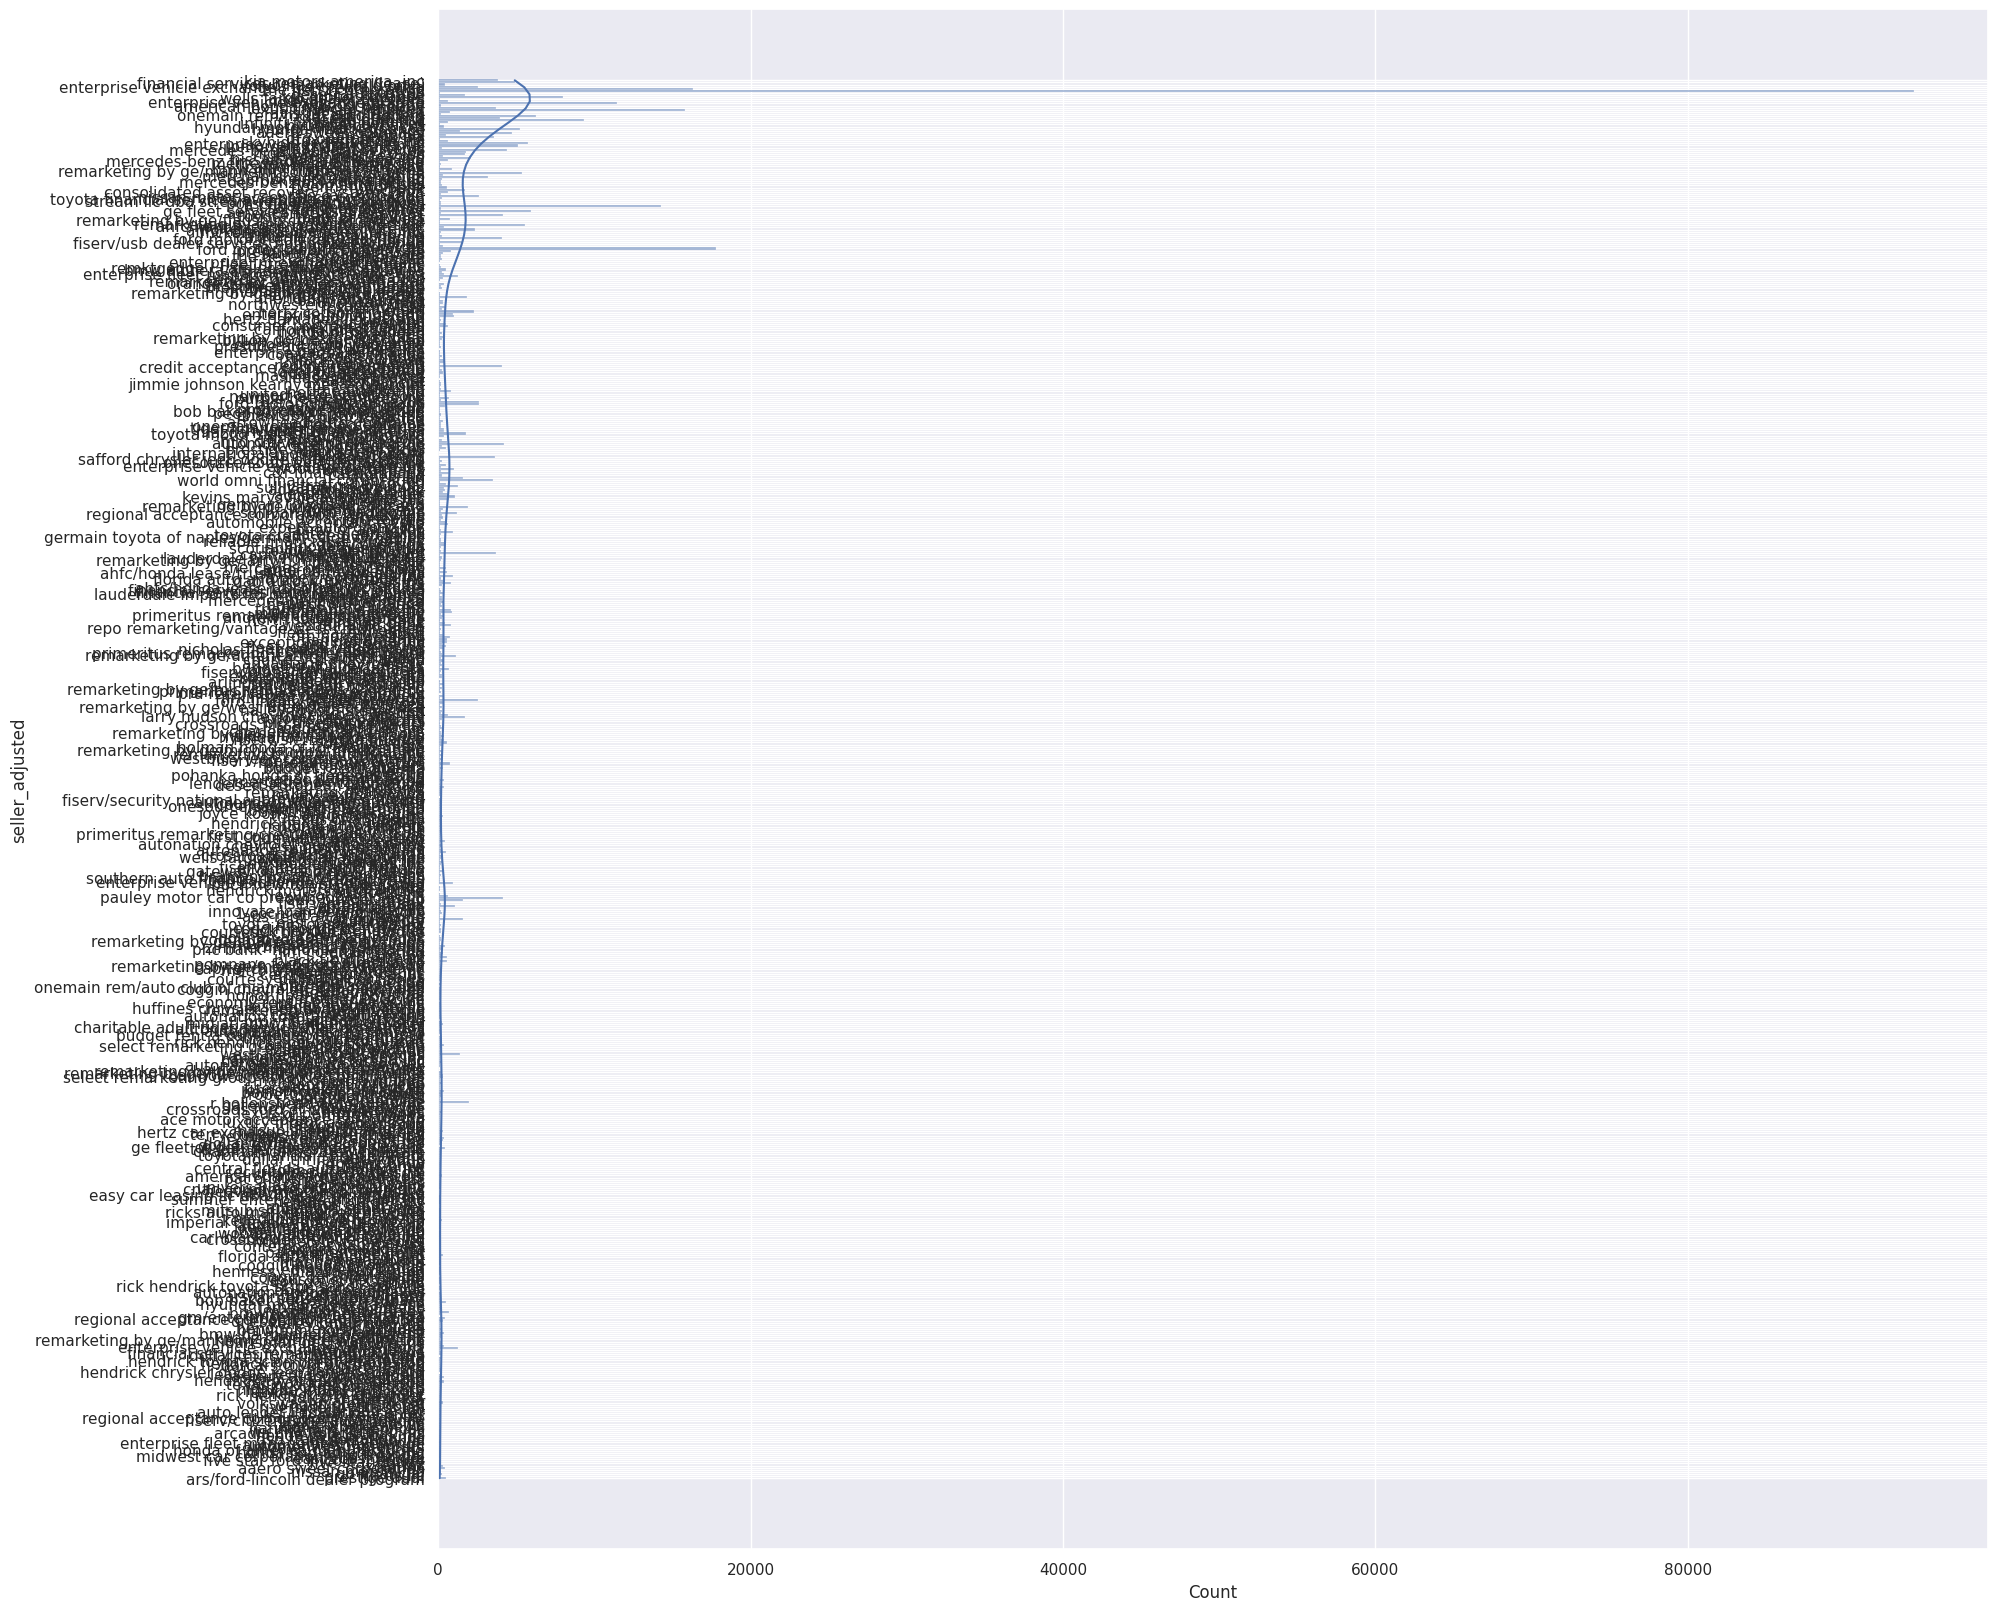

In [44]:
print(df.seller_adjusted.describe())
print(df.groupby('seller_adjusted').year.count().index)

sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(20,20)})
sns.histplot(data=df, y="seller_adjusted",kde = True)

In [45]:
l_seller = len(df.groupby('seller_adjusted').year.count().index)
print('Número de Rótulos: ',l_seller)

Número de Rótulos:  666


### 3.13. MMR

In [46]:
df.mmr.describe()

count    472325.000000
mean      13837.058964
std        9532.229273
min          25.000000
25%        7425.000000
50%       12300.000000
75%       18300.000000
max      182000.000000
Name: mmr, dtype: float64

### 3.14. Year

In [47]:
df.year.describe()

count    472325.000000
mean       2010.210980
std           3.822151
min        1990.000000
25%        2008.000000
50%        2012.000000
75%        2013.000000
max        2015.000000
Name: year, dtype: float64

### 3.15. Saleyear

In [48]:
df.saleyear.describe()

count    472325.000000
mean       2014.922111
std           0.267997
min        2014.000000
25%        2015.000000
50%        2015.000000
75%        2015.000000
max        2015.000000
Name: saleyear, dtype: float64

### 3.16. Sellingprice

In [49]:
df.sellingprice.describe()

count    472325.000000
mean      13690.512058
std        9613.033738
min           1.000000
25%        7200.000000
50%       12200.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

### 3.17. Final

In [50]:
n_features = (l_make) + (l_model) + (l_trim) + (l_body) + (l_transmission) + (l_state) + 1 + 1 + (l_color) + (l_interior) + (l_seller) + 1 + 1 + 1
print('Número total de Features: ', n_features)

Número total de Features:  1020


Dada a alta cardinalidade faz-se necessário a Feature Selection e/ou Dimensional Reduction via PCA/MCA , Clusterização

# 4. Data Exploration

## 4.1. Feature Transformations

In [51]:
df_features = df[['year','make_adjusted','model_adjusted','trim_adjusted','body_adjusted'
,'transmission_adjusted','state_adjusted','condition','odometer','color_adjusted','interior_adjusted','seller_adjusted'
,'mmr','conv_data','saleyear']]

df_y = df[['sellingprice']]

### 4.1.1. Sellingprice

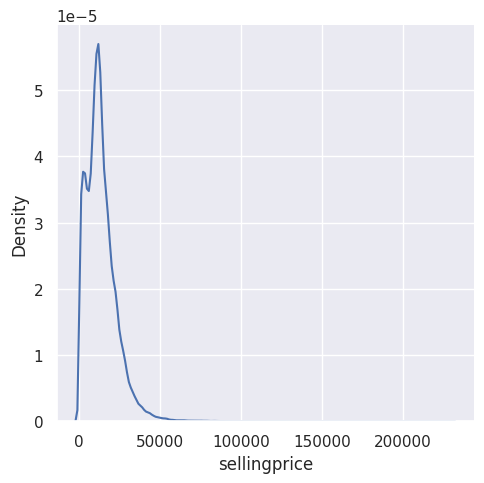

In [52]:
sns.displot(data=df_y, x="sellingprice", kind="kde")

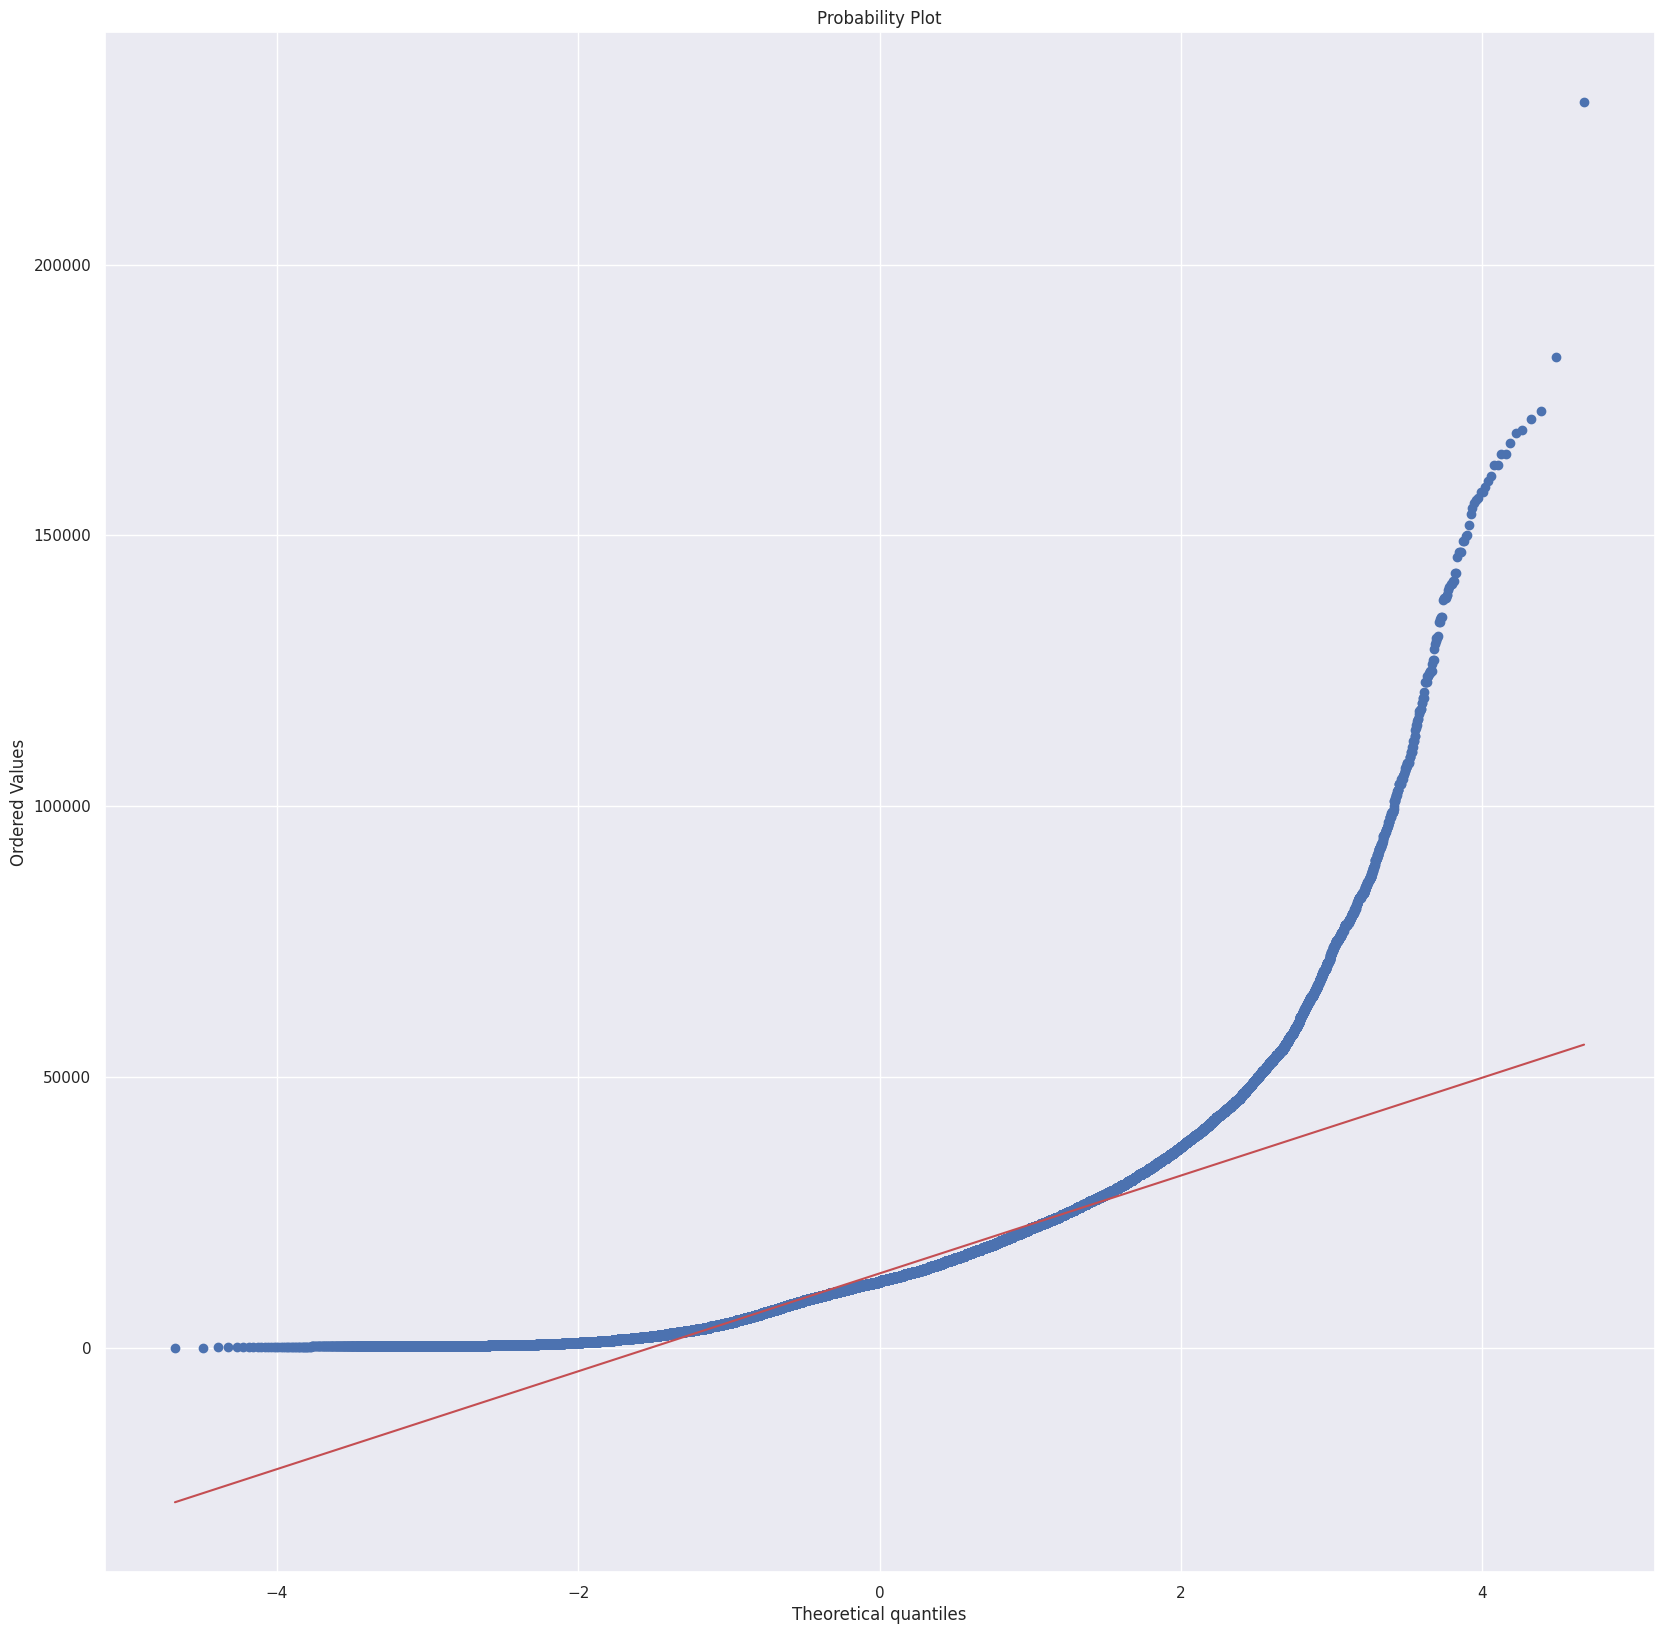

In [53]:
stats.probplot(df_y['sellingprice'], dist="norm", plot=plt)
plt.title("Probability Plot" )
plt.show()

#### 4.1.1.0. Box Cox Transformation

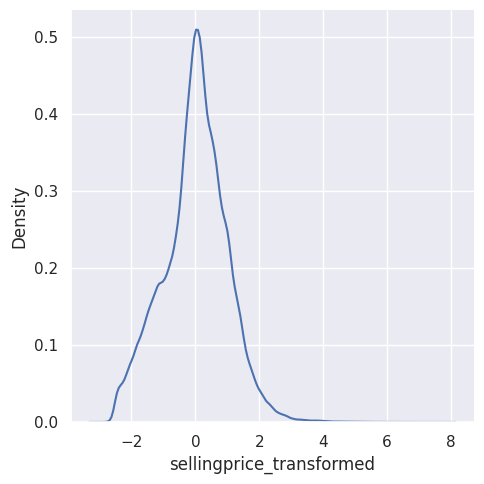

In [54]:
#fazendo a transformação box-cox
boxcoxTr = PowerTransformer(method = "box-cox", standardize=True)
b_r = boxcoxTr.fit_transform(df_y['sellingprice'].values.reshape(-1,1))
df_y['sellingprice_transformed'] = b_r

#plotando kde
sns.displot(data=df_y, x="sellingprice_transformed", kind="kde")

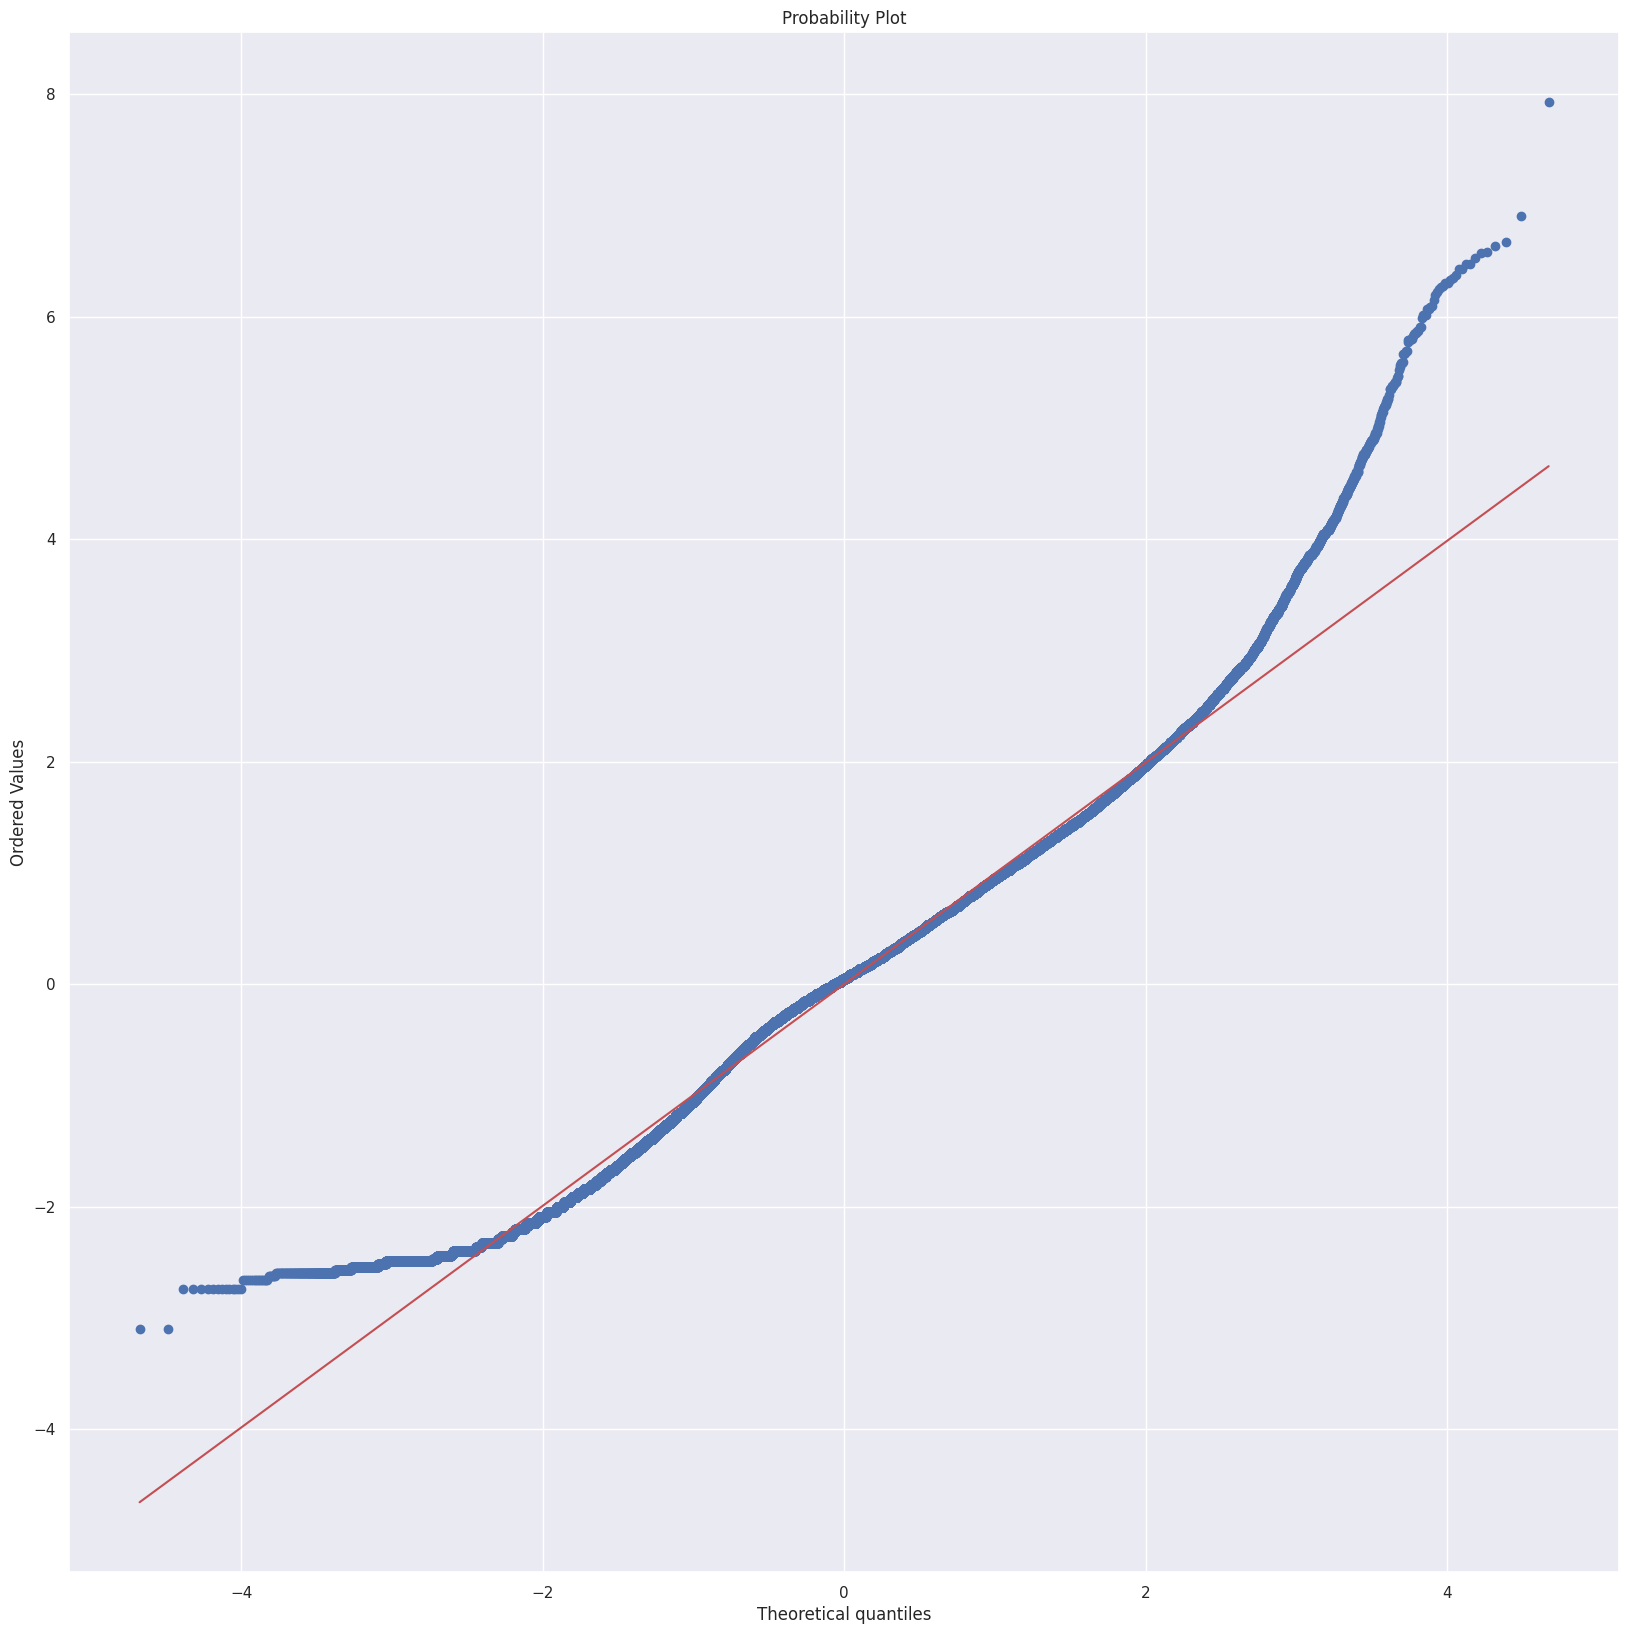

In [55]:
stats.probplot(df_y['sellingprice_transformed'], dist="norm", plot=plt)
plt.title("Probability Plot" )
plt.show()

In [56]:
alpha = 0.05
ksstat, pvalue = sm.stats.diagnostic.lilliefors(df_y['sellingprice_transformed'].values)
if pvalue > alpha:
    result = 'Normal'
else:
    result = 'NOT Normal'
print(f'Lilliefors: {result:>21s}')
print(ksstat)
print(pvalue)

Lilliefors:            NOT Normal
0.045648822230037134
0.0009999999999998899


### 4.1.2. Odometer

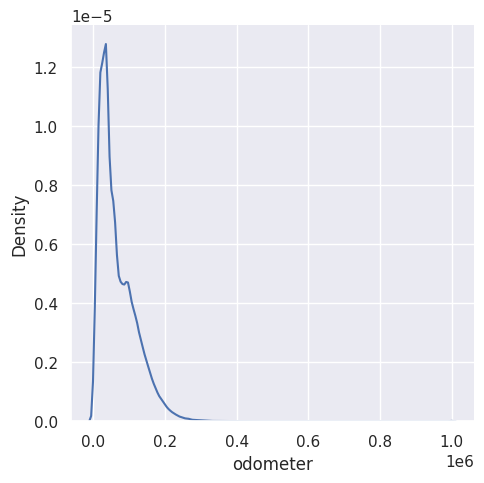

In [57]:
sns.displot(data=df_features, x="odometer", kind="kde")

In [58]:
#RobustScaler é mais robusto a outliers
transformer = RobustScaler()
# transformação logaritmica
df_features['odometer_transformed'] = df_features['odometer'].apply(lambda x: np.log(x))
# transformação z
df_features['odometer_transformed'] = transformer.fit_transform(df_features['odometer_transformed'].values.reshape(-1,1))

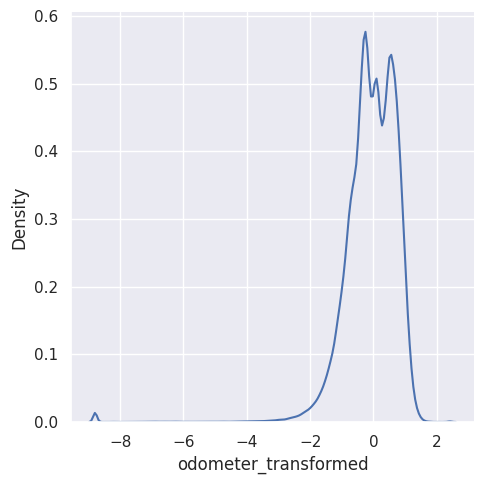

In [59]:
sns.displot(data=df_features, x="odometer_transformed", kind="kde")

In [60]:
alpha = 0.05
ksstat, pvalue = sm.stats.diagnostic.lilliefors(df_features['odometer_transformed'].values)
if pvalue > alpha:
    result = 'Normal'
else:
    result = 'NOT Normal'
print(f'Lilliefors: {result:>21s}')
print(ksstat)
print(pvalue)

Lilliefors:            NOT Normal
0.06284082713287609
0.0009999999999998899


### 4.1.3. MMR

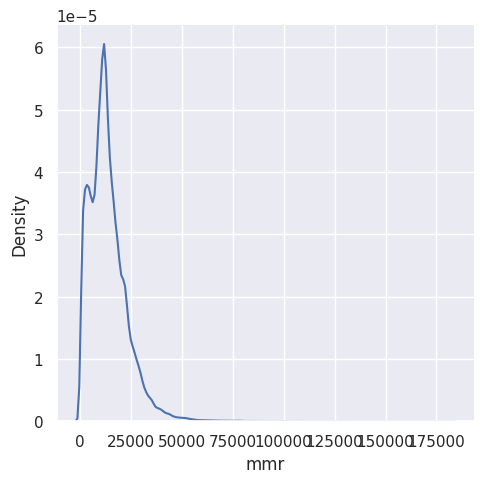

In [61]:
sns.displot(data=df_features, x="mmr", kind="kde")

In [62]:
transformer = RobustScaler()
df_features['mmr_transformed'] = df_features['mmr'].apply(lambda x: np.log(x))
df_features['mmr_transformed'] = transformer.fit_transform(df_features['mmr_transformed'].values.reshape(-1,1))


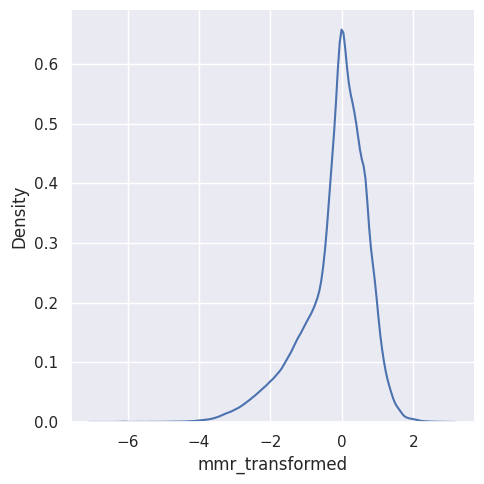

In [63]:
sns.displot(data=df_features, x="mmr_transformed", kind="kde")

In [64]:
alpha = 0.05
ksstat, pvalue = sm.stats.diagnostic.lilliefors(df_features['mmr_transformed'].values)
if pvalue > alpha:
    result = 'Normal'
else:
    result = 'NOT Normal'
print(f'Lilliefors: {result:>21s}')
print(ksstat)
print(pvalue)

Lilliefors:            NOT Normal
0.11105407280557983
0.0009999999999998899


### 4.1.4. Year

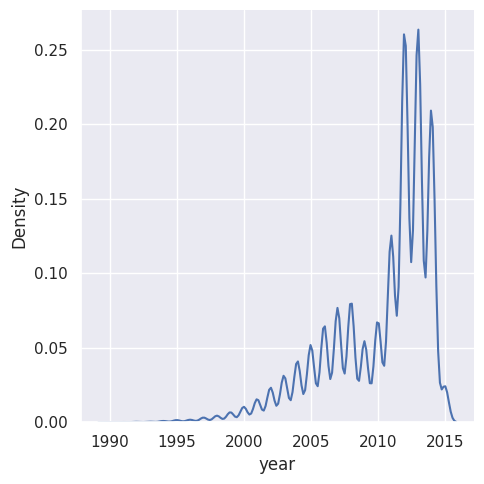

In [65]:
sns.displot(data=df_features, x="year", kind="kde")

In [66]:
transformer = RobustScaler()
df_features['year_transformed'] = df_features['year'].apply(lambda x: np.cbrt(x))
df_features['year_transformed'] = transformer.fit_transform(df_features['year_transformed'].values.reshape(-1,1))

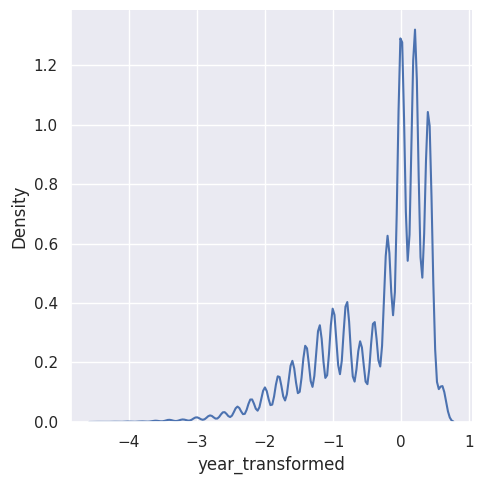

In [67]:
sns.displot(data=df_features, x="year_transformed", kind="kde")

In [68]:
alpha = 0.05
ksstat, pvalue = sm.stats.diagnostic.lilliefors(df_features['year_transformed'].values)
if pvalue > alpha:
    result = 'Normal'
else:
    result = 'NOT Normal'
print(f'Lilliefors: {result:>21s}')
print(ksstat)
print(pvalue)

Lilliefors:            NOT Normal
0.2148820060505156
0.0009999999999998899


Candidato a agrupamentos de 2 em 2 anos

### 4.1.4. Saleyear

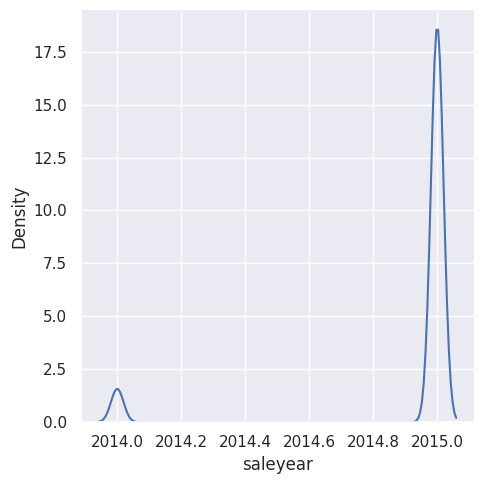

In [69]:
sns.displot(data=df, x="saleyear", kind="kde")

In [70]:
transformer = MinMaxScaler()
df_features['saleyear_transformed'] = transformer.fit_transform(df_features['saleyear'].values.reshape(-1,1))

In [71]:
df_features.saleyear_transformed.describe()

count    472325.000000
mean          0.922111
std           0.267997
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: saleyear_transformed, dtype: float64

Transformado em variável booleana

### 4.1.6. Condition

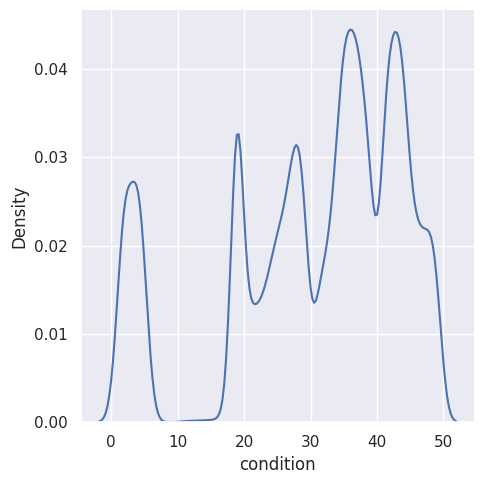

In [72]:
sns.displot(data=df, x="condition", kind="kde")

In [73]:
transformer = RobustScaler()
df_features['condition_transformed'] = transformer.fit_transform(df_features['condition'].values.reshape(-1,1))

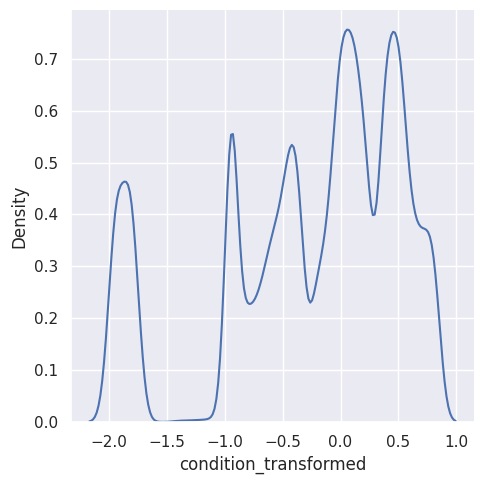

In [74]:
sns.displot(data=df_features, x="condition_transformed", kind="kde")

## 4.2. Pearson Correlation

In [75]:
df_corr = df_features.merge(df_y,right_index=True,left_index= True).drop(columns= ['year','condition','odometer','mmr','conv_data','saleyear','sellingprice','saleyear_transformed'])
df_corr.corr()

odometer_transformed  mmr_transformed  \
odometer_transformed                  1.000000        -0.553567   
mmr_transformed                      -0.553567         1.000000   
year_transformed                     -0.588100         0.795980   
condition_transformed                -0.187382         0.358944   
sellingprice_transformed             -0.527675         0.944761   

                          year_transformed  condition_transformed  \
odometer_transformed             -0.588100              -0.187382   
mmr_transformed                   0.795980               0.358944   
year_transformed                  1.000000               0.334813   
condition_transformed             0.334813               1.000000   
sellingprice_transformed          0.721186               0.389101   

                          sellingprice_transformed  
odometer_transformed                     -0.527675  
mmr_transformed                           0.944761  
year_transformed                          0.721186  
condition_transformed                     0.389101  
sellingprice_transformed                  1.000000

<Axes: >

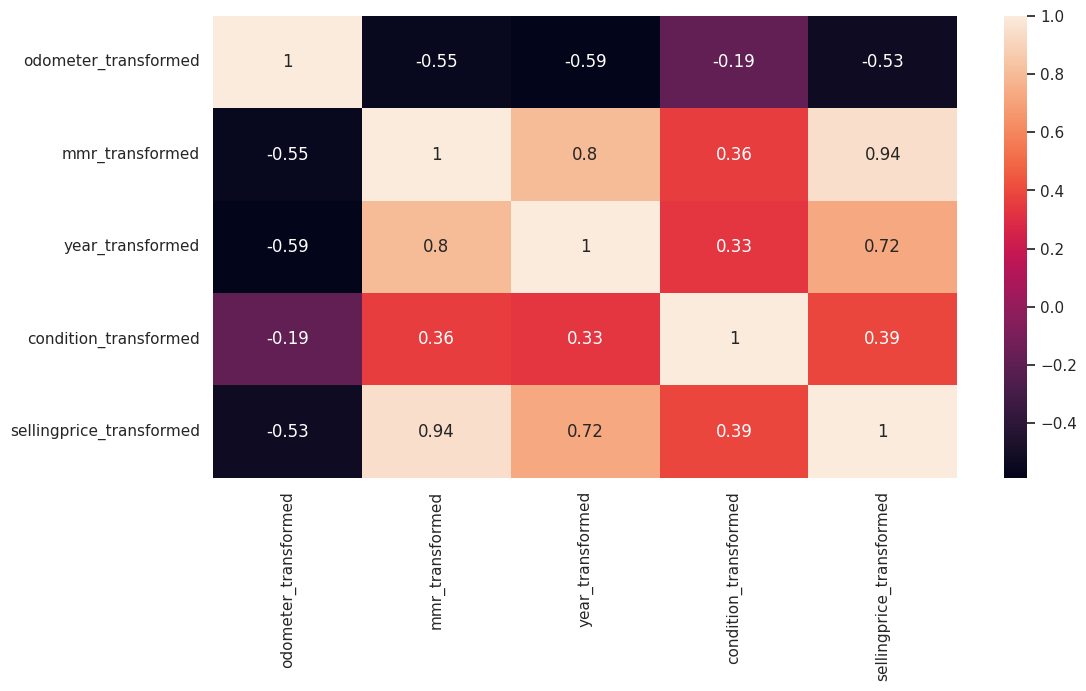

In [76]:
sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(12,6)})
sns.heatmap(df_corr.corr(),annot=True)


Sem multicolinearidade e potenciais feature extractions adicionais

## 4.3. Correlação Variáveis Categóricas

Dada a alta cardinalidade - muitas categorias a inspeção dessa correlação não será a melhor técnica possível.

Poder-se-ia utilizar Qui-Square Test + Cramer V para essa mensuração

## 4.4. Anova

### 4.4.1. Body

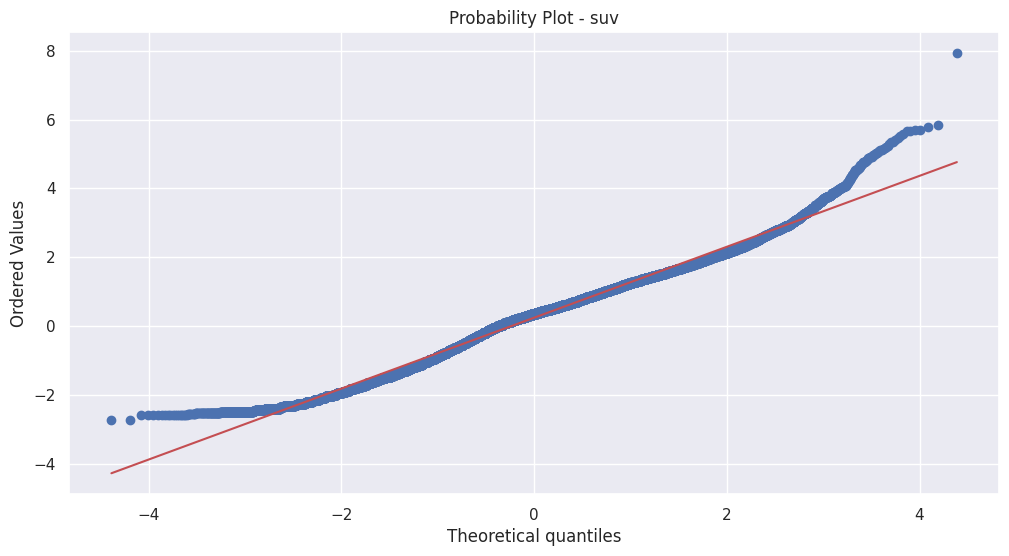

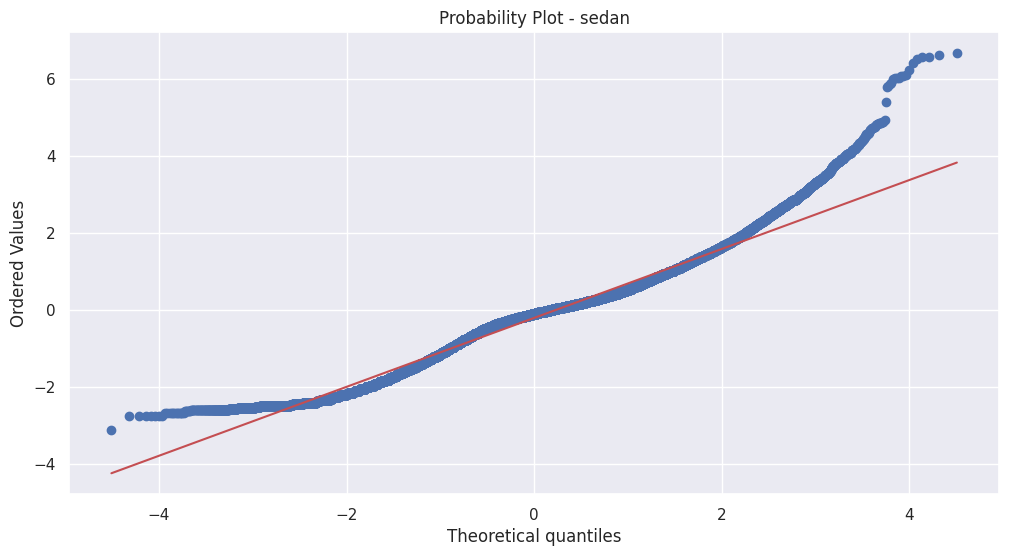

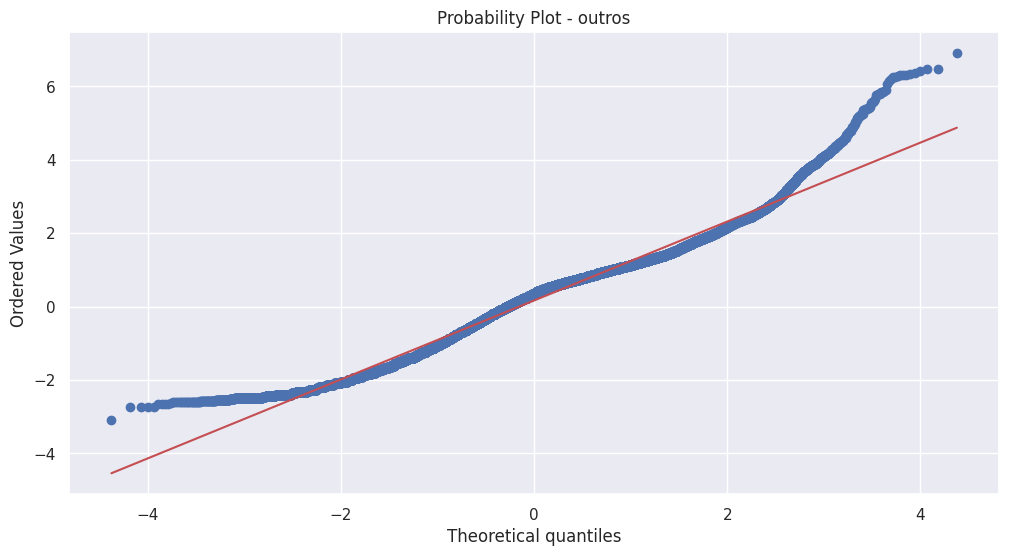

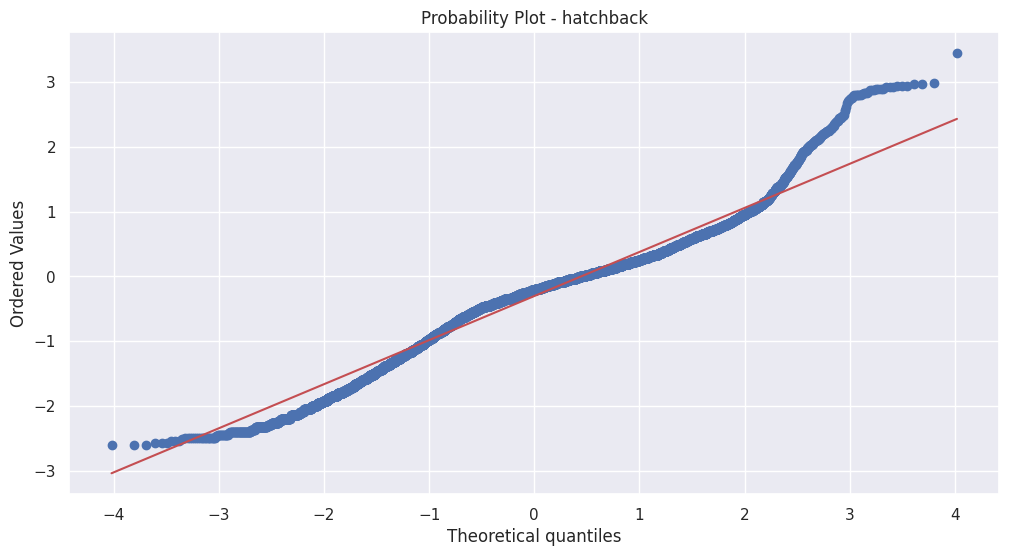

In [119]:
df_body = df_features[['body_adjusted']].merge(df_y,right_index=True,left_index= True)

unique_body = df_body['body_adjusted'].unique()
for body in unique_body:
    stats.probplot(df_body[df_body['body_adjusted'] == body]['sellingprice_transformed'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  body)
    plt.show()

In [125]:
dfs = [x.sellingprice_transformed.values for _, x in df_body.groupby('body_adjusted')]

F, p = f_oneway(dfs[0].tolist(),dfs[1].tolist(),dfs[2].tolist())

print('F: ', F)
print('p: ', p)

if p < 0.05:
    print("Há diferença entre as médias")
else:
    print("Não há diferença entre as médias")

F:  6172.123967533757
p:  0.0
Há diferença entre as médias


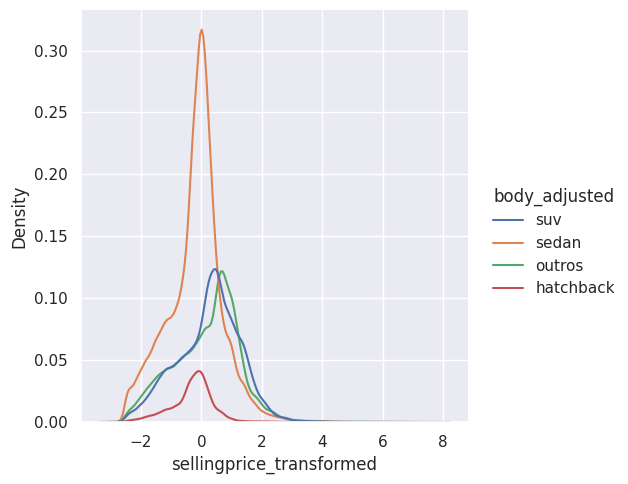

In [126]:
sns.displot(data=df_body, x="sellingprice_transformed", hue="body_adjusted", kind="kde")


### 4.4.2. Transmission

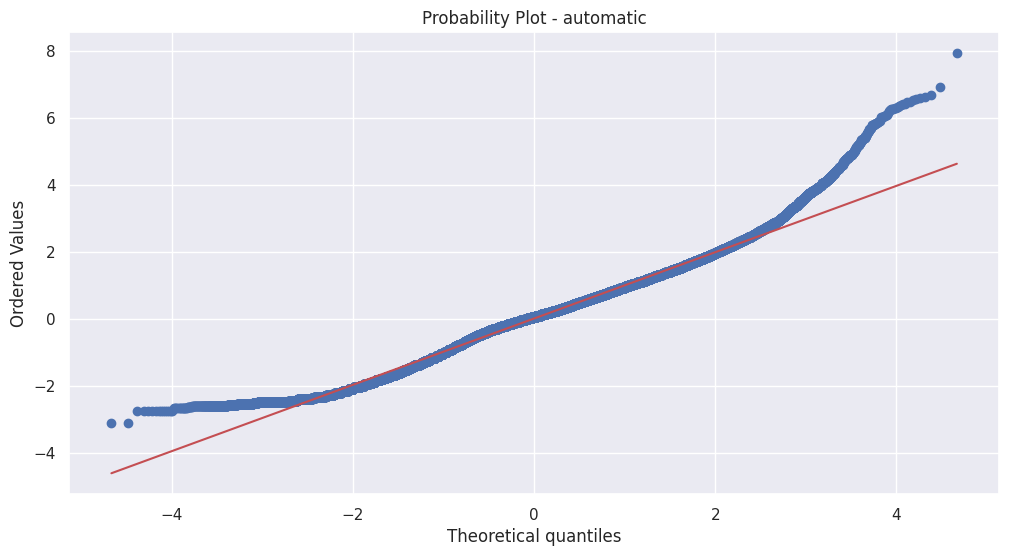

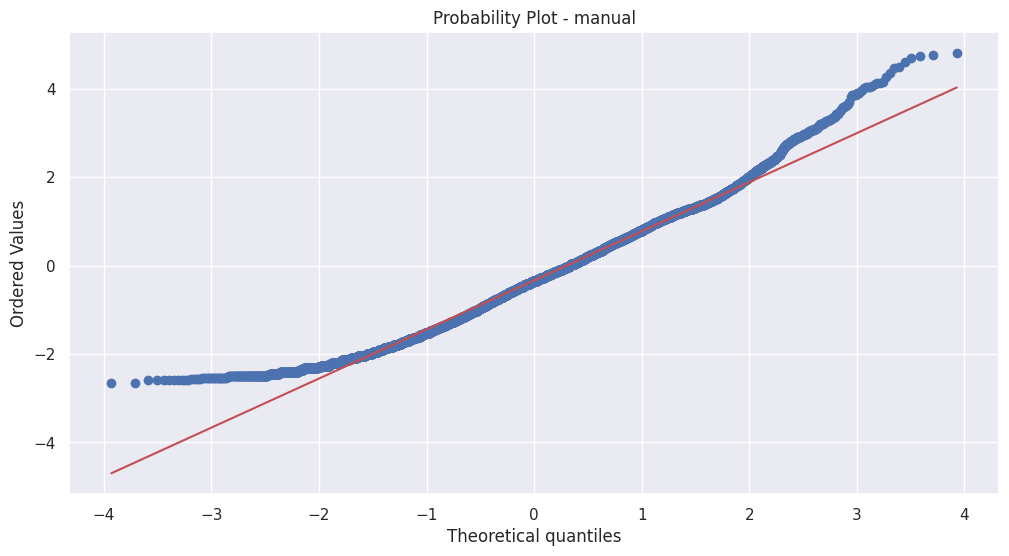

In [127]:
df_transmission = df_features[['transmission_adjusted']].merge(df_y,right_index=True,left_index= True)

unique_transmission = df_transmission['transmission_adjusted'].unique()
for transmission in unique_transmission:
    stats.probplot(df_transmission[df_transmission['transmission_adjusted'] == transmission]['sellingprice_transformed'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  transmission)
    plt.show()

In [129]:
dfs = [x.sellingprice_transformed.values for _, x in df_transmission.groupby('transmission_adjusted')]

F, p = f_oneway(dfs[0].tolist(),dfs[1].tolist())

print('F: ', F)
print('p: ', p)

if p < 0.05:
    print("Há diferença entre as médias")
else:
    print("Não há diferença entre as médias")

F:  1913.5051811027804
p:  0.0
Há diferença entre as médias


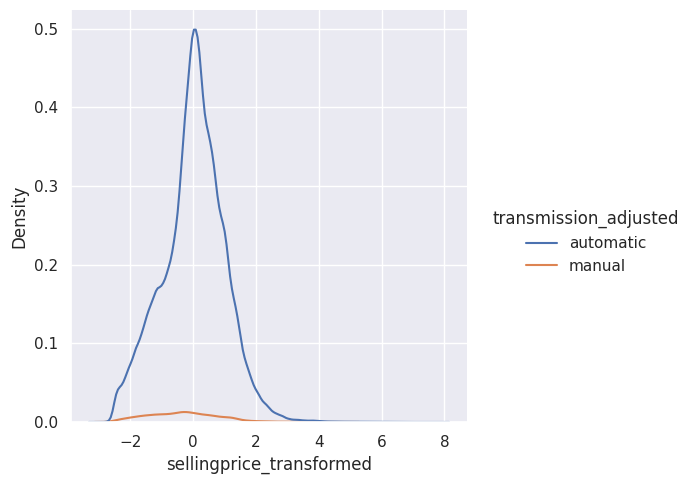

In [131]:
sns.displot(data=df_transmission, x="sellingprice_transformed", hue="transmission_adjusted", kind="kde")


### 4.4.3. Color

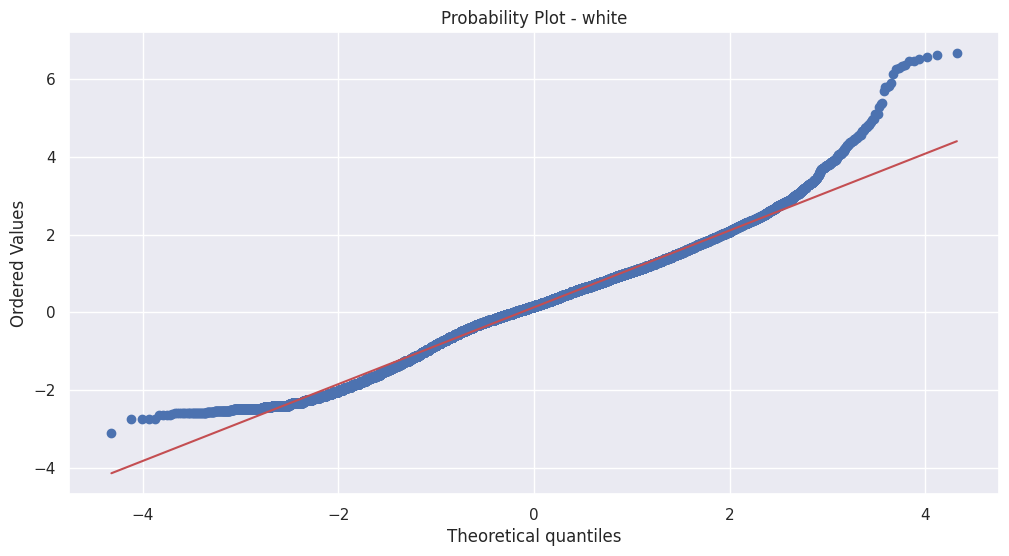

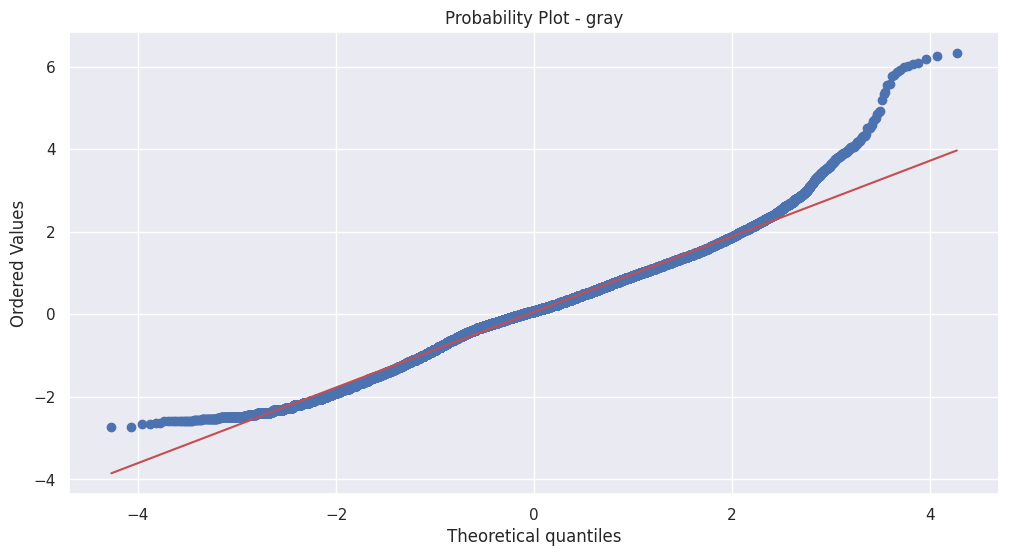

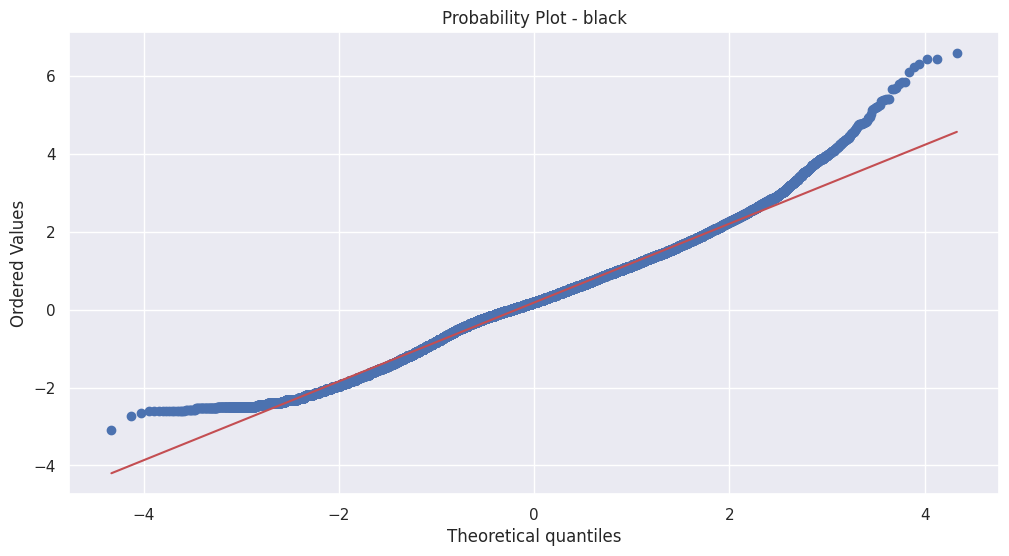

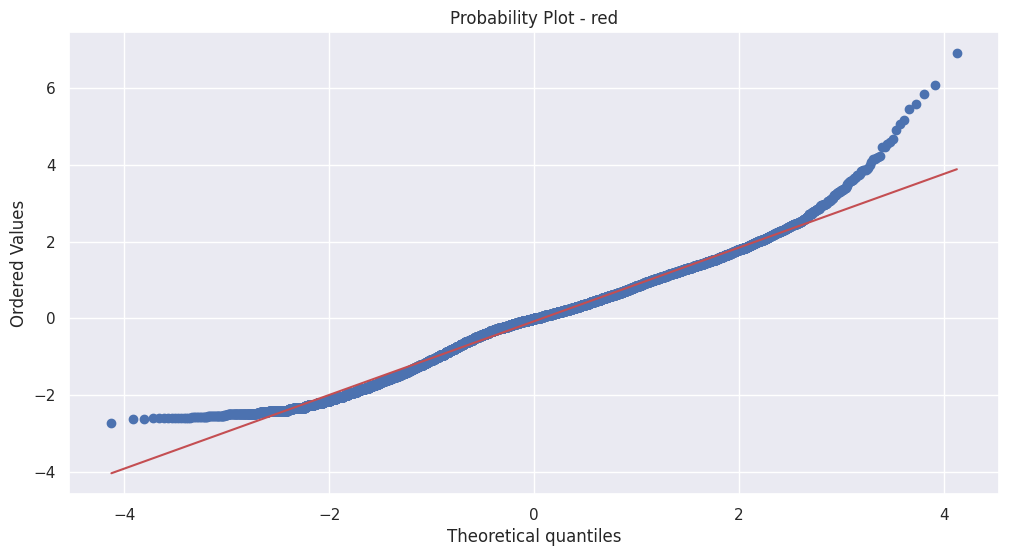

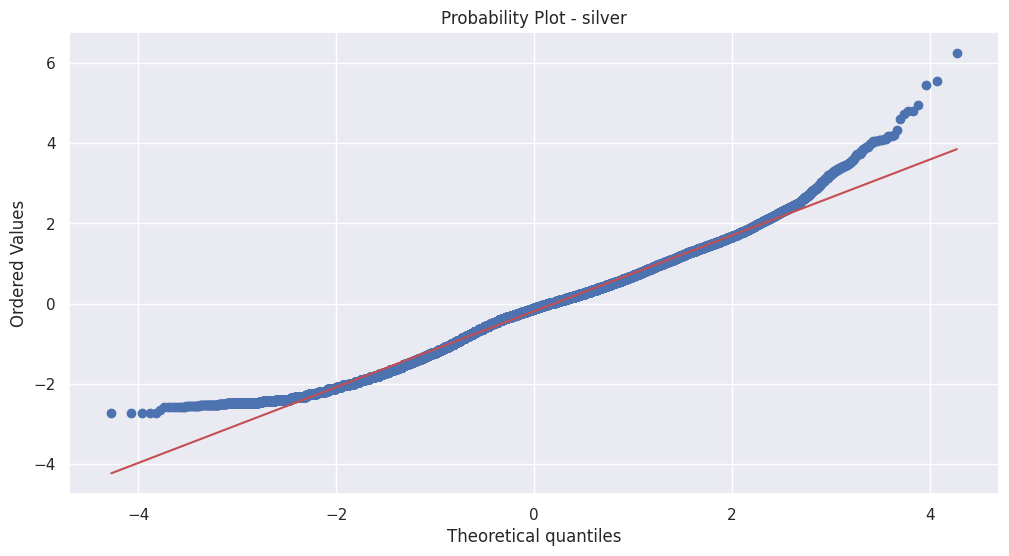

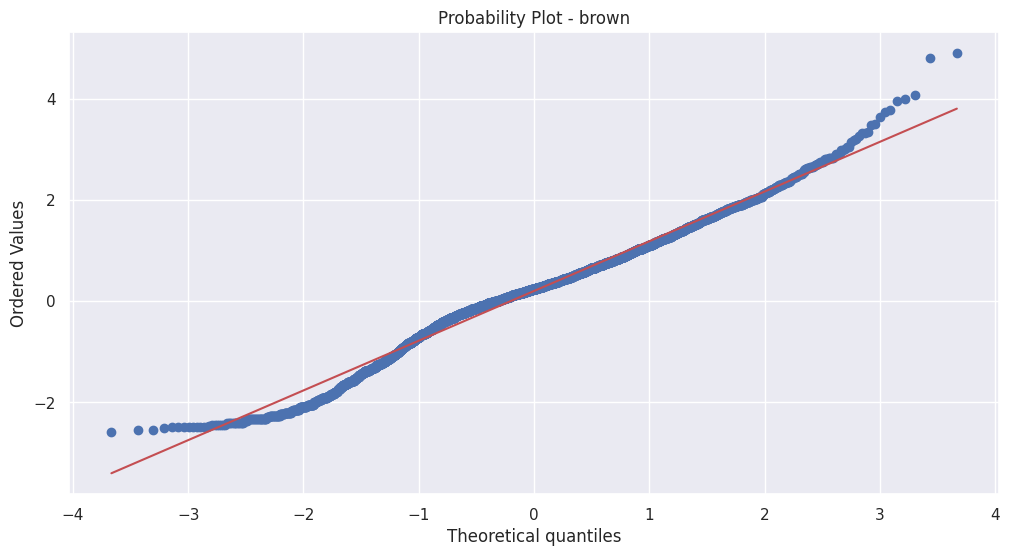

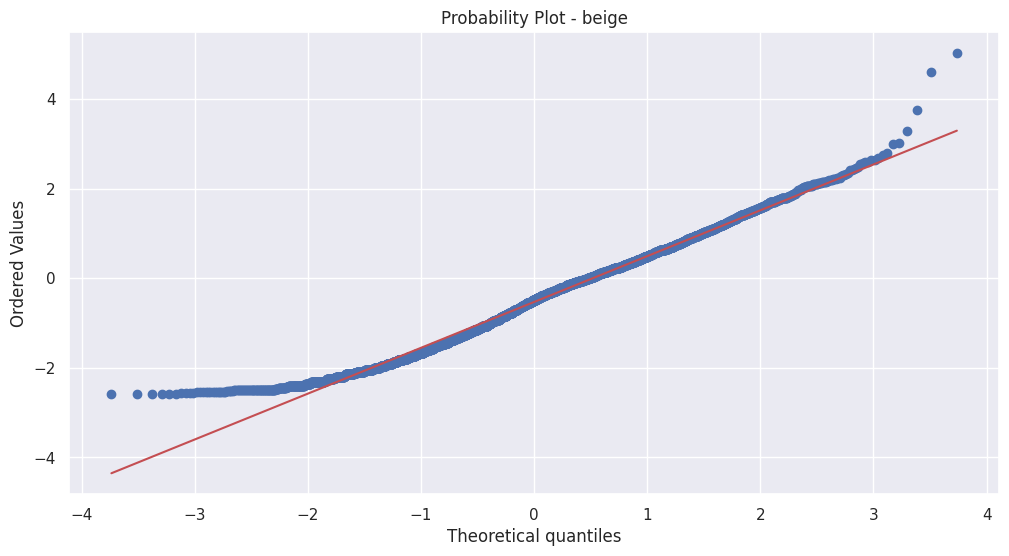

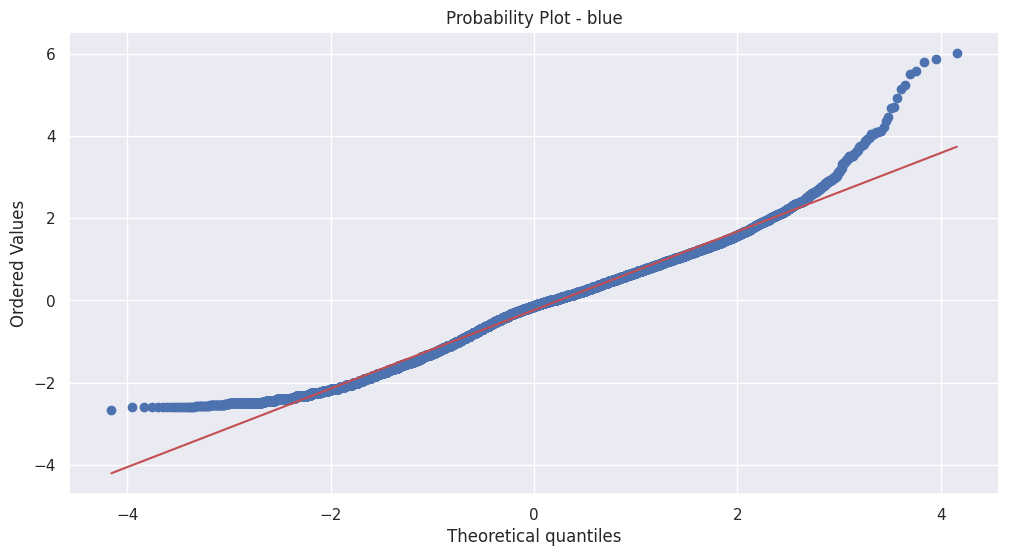

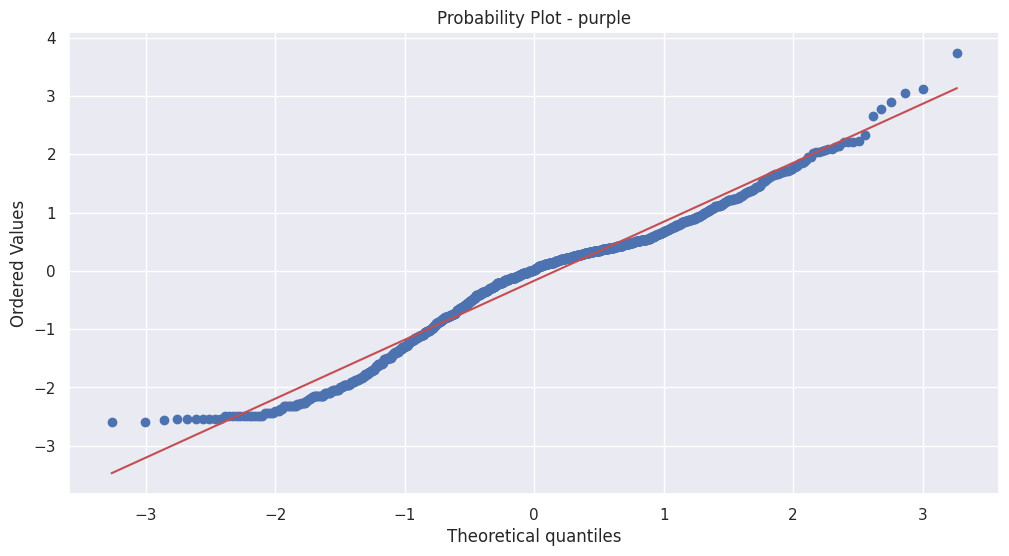

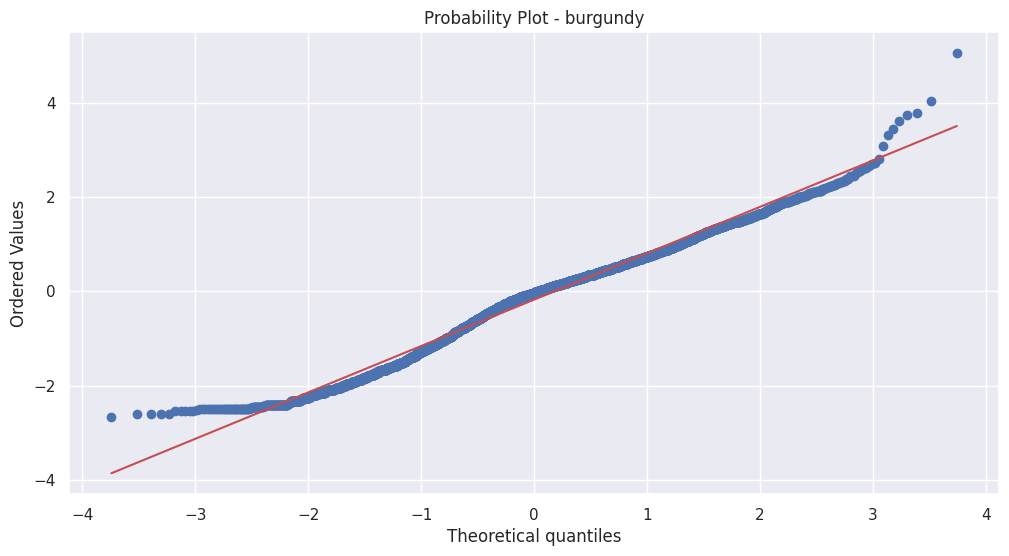

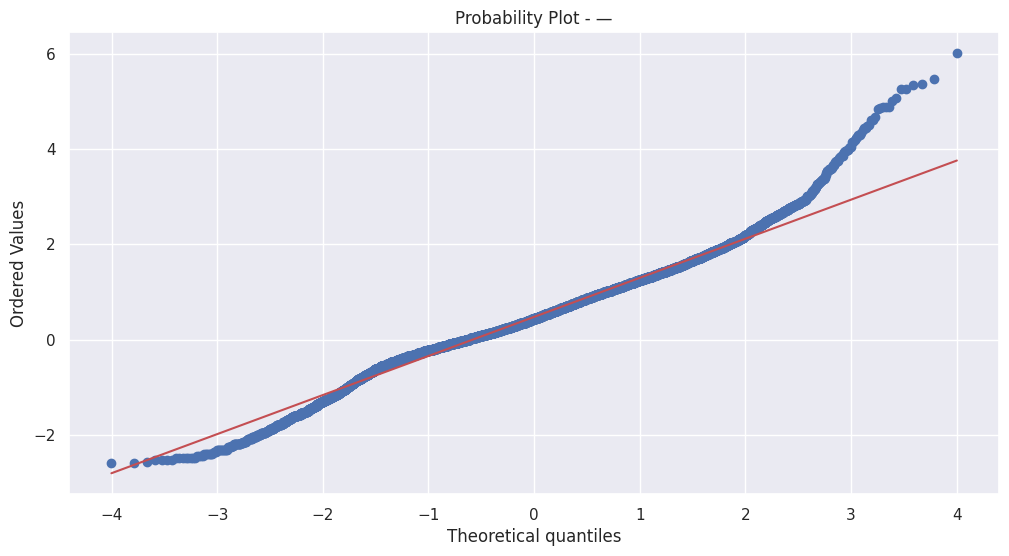

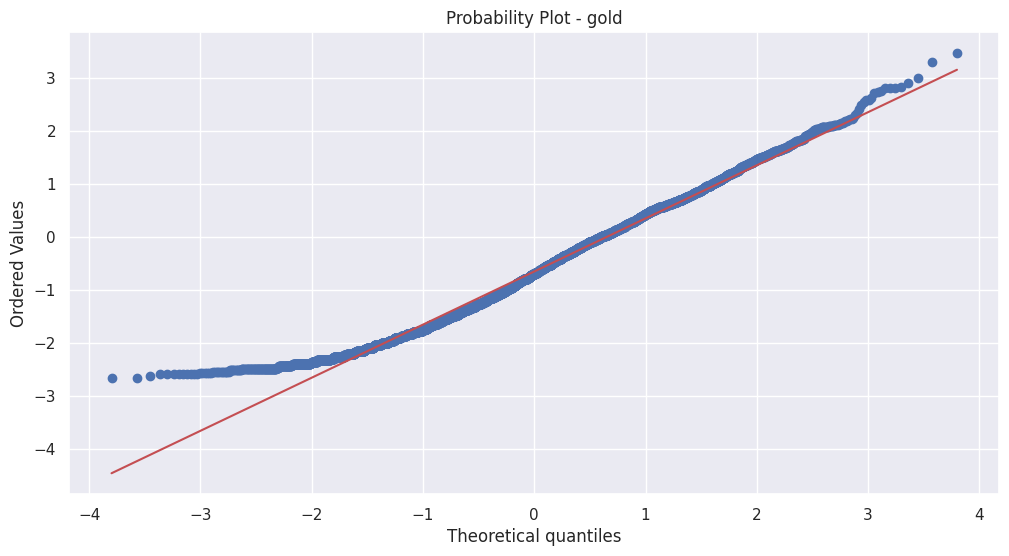

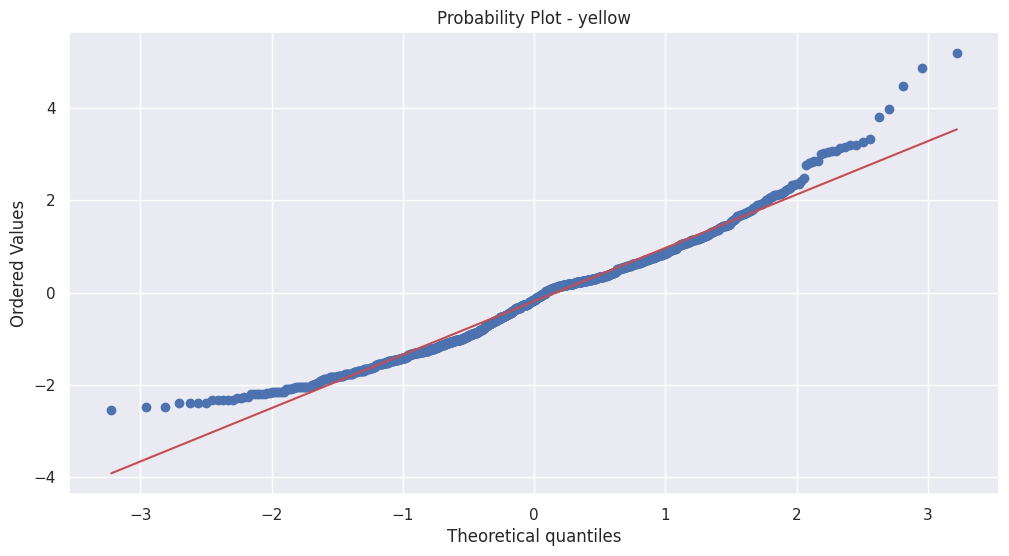

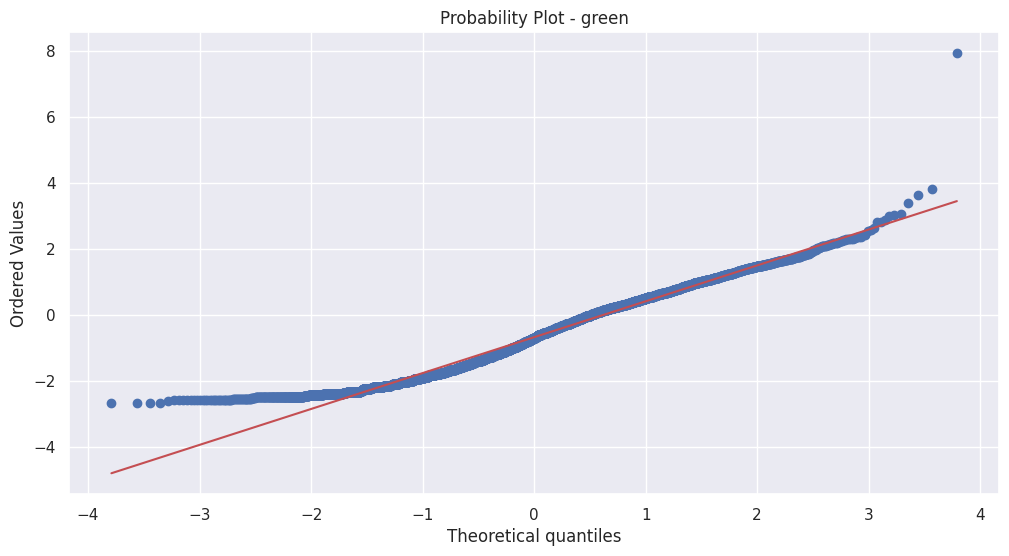

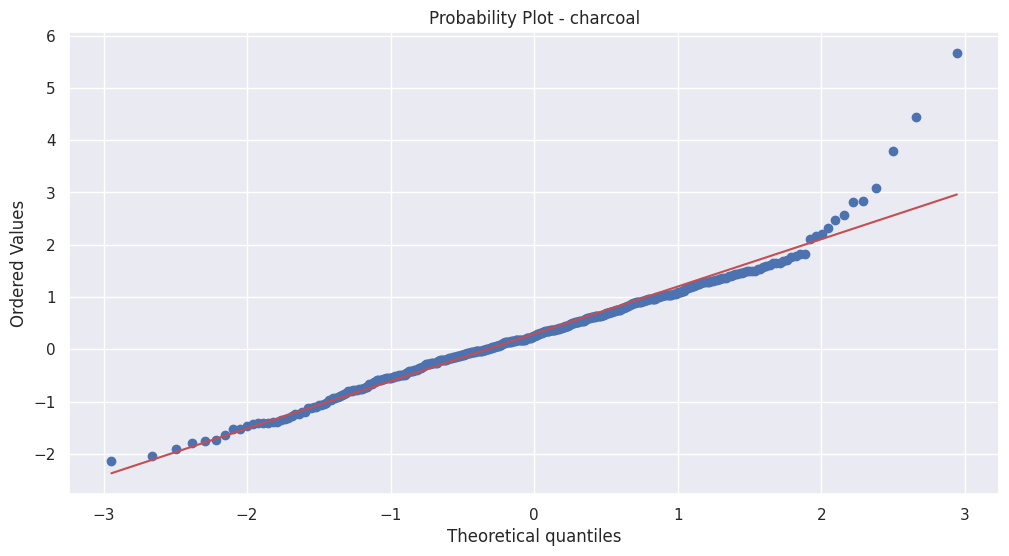

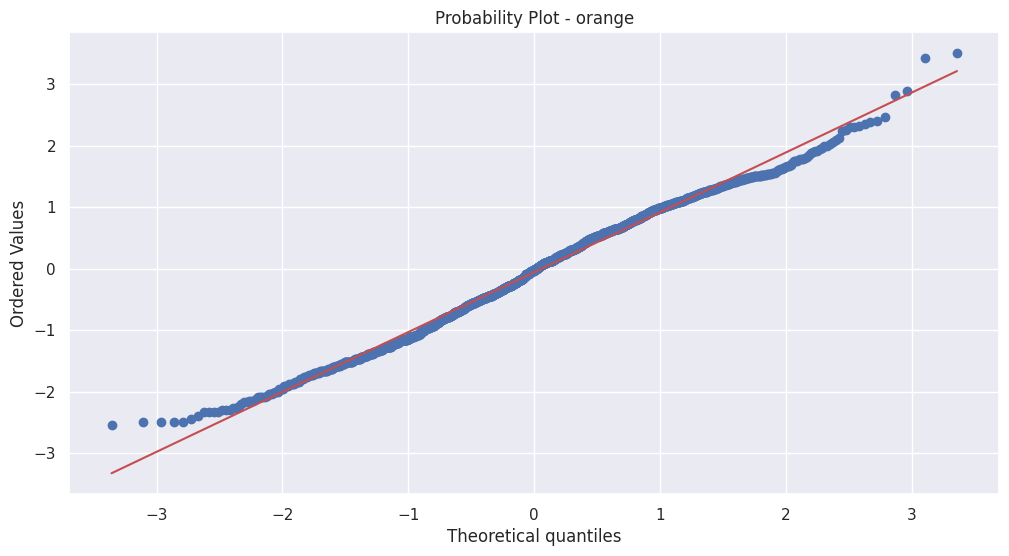

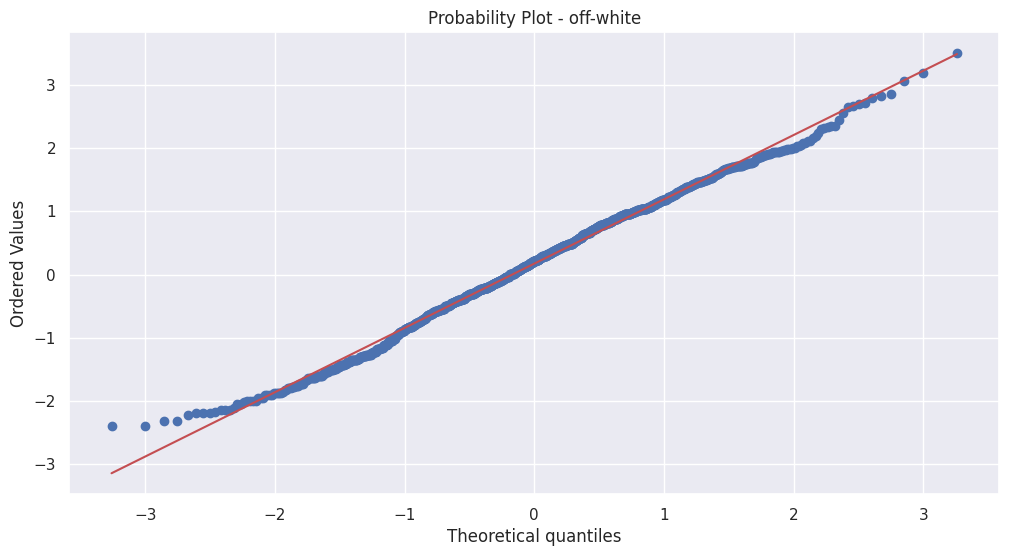

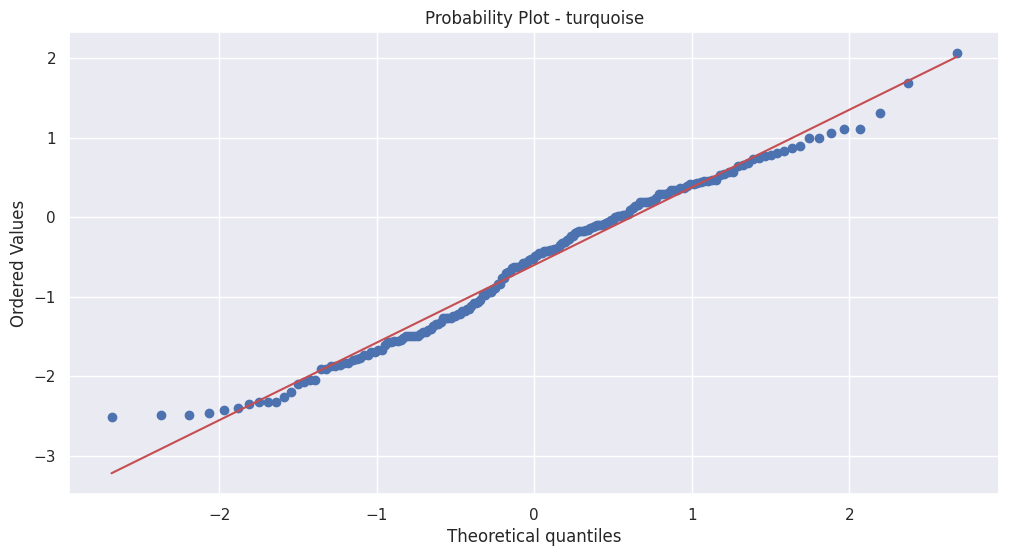

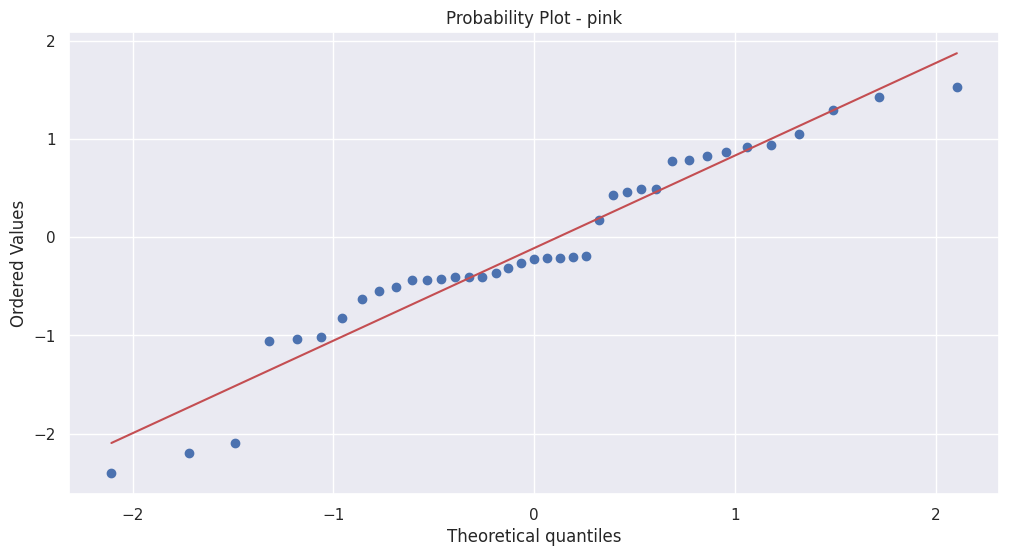

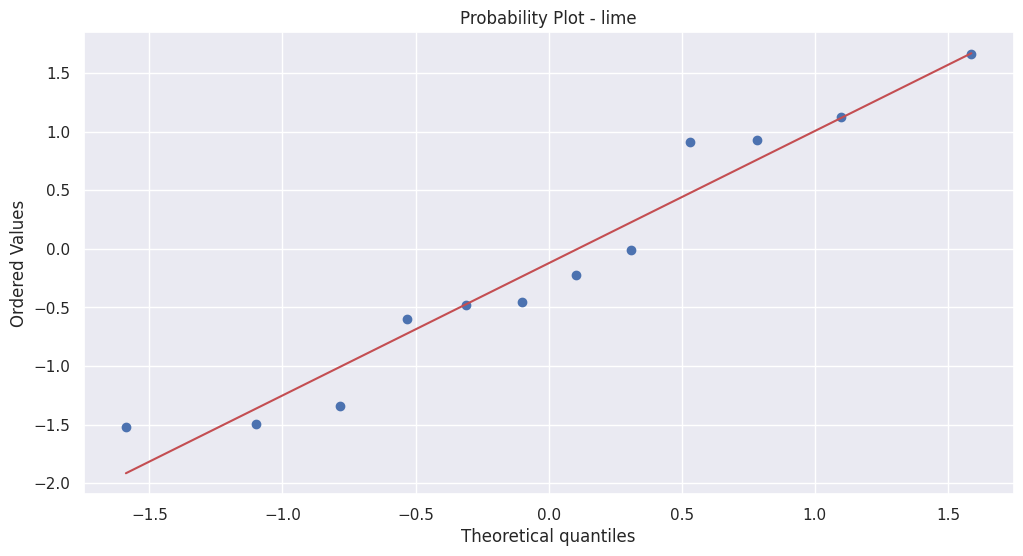

In [132]:
df_color = df_features[['color_adjusted']].merge(df_y,right_index=True,left_index= True)

unique_color = df_color['color_adjusted'].unique()
for color in unique_color:
    stats.probplot(df_color[df_color['color_adjusted'] == color]['sellingprice_transformed'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  color)
    plt.show()

In [133]:
dfs = [x.sellingprice_transformed.values for _, x in df_color.groupby('color_adjusted')]

F, p = f_oneway(dfs[0].tolist(),dfs[1].tolist(),dfs[2].tolist(),dfs[3].tolist(),dfs[4].tolist(),dfs[5].tolist()
,dfs[6].tolist(),dfs[7].tolist(),dfs[8].tolist(),dfs[9].tolist(),dfs[10].tolist(),dfs[11].tolist(),dfs[12].tolist(),dfs[13].tolist()
,dfs[14].tolist(),dfs[15].tolist(),dfs[16].tolist(),dfs[17].tolist(),dfs[18].tolist(),dfs[19].tolist())

print('F: ', F)
print('p: ', p)

if p < 0.05:
    print("Há diferença entre as médias")
else:
    print("Não há diferença entre as médias")

F:  1451.546642566904
p:  0.0
Há diferença entre as médias


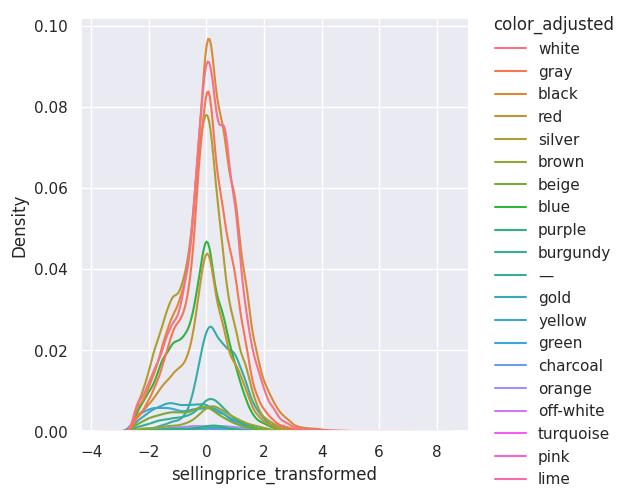

In [134]:
sns.displot(data=df_color, x="sellingprice_transformed", hue="color_adjusted", kind="kde")


### 4.4.4. Interior

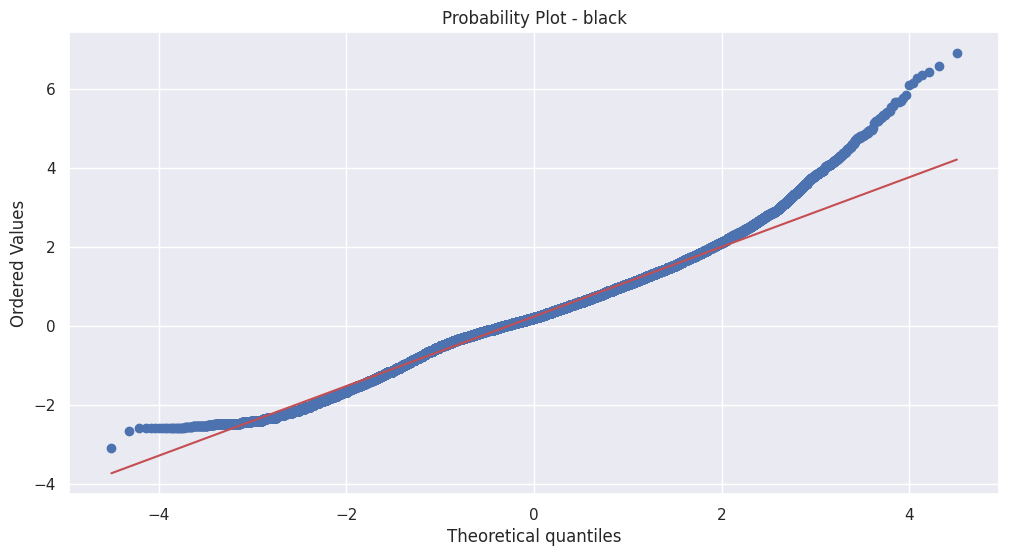

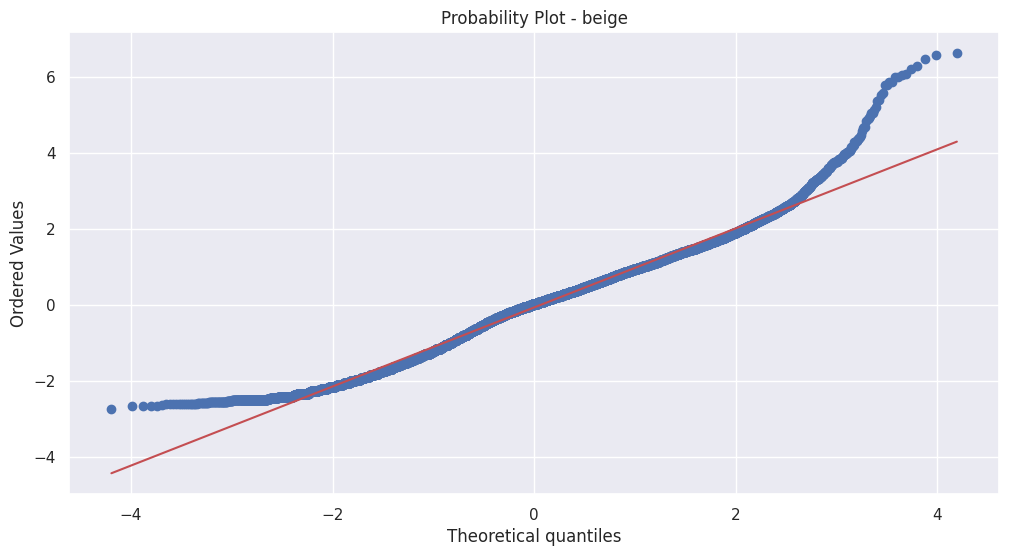

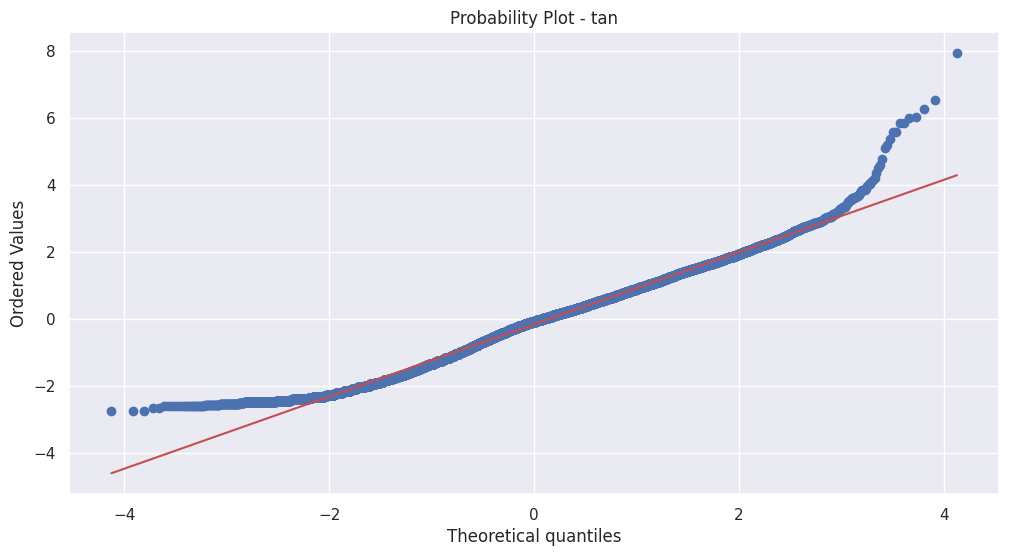

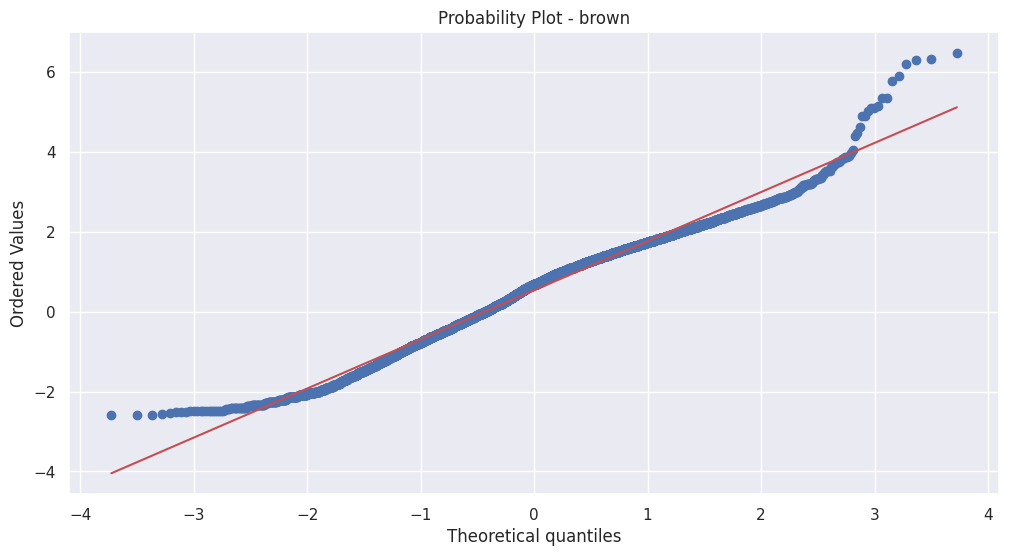

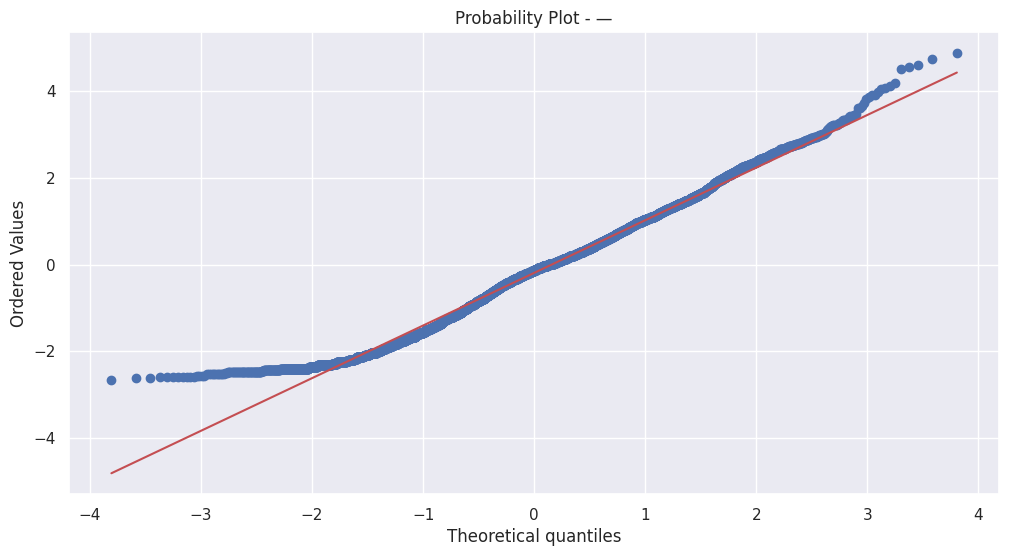

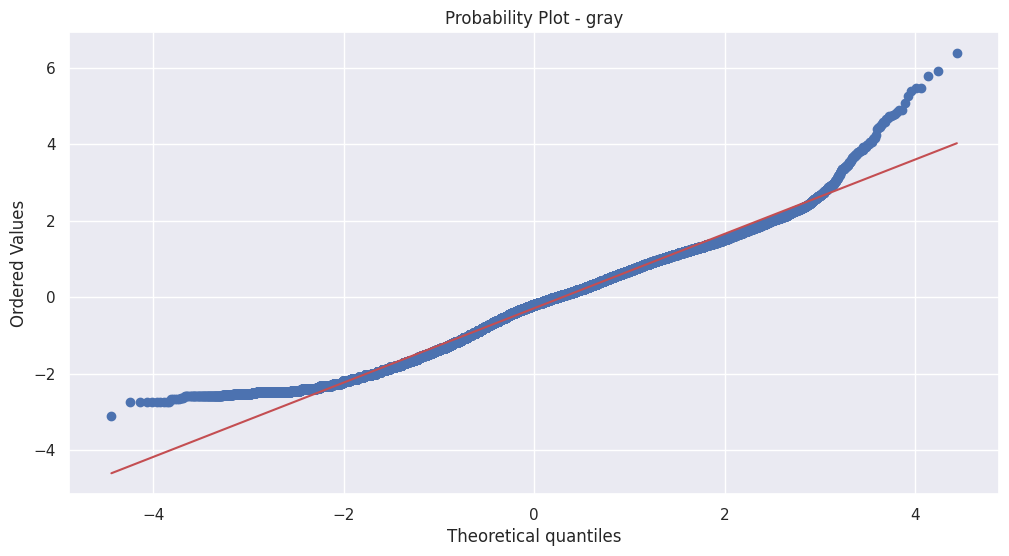

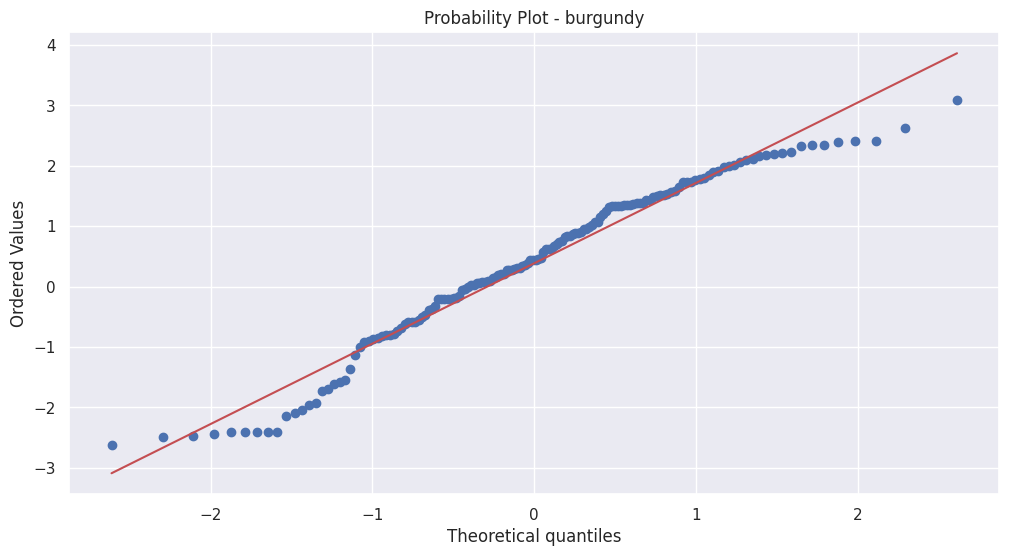

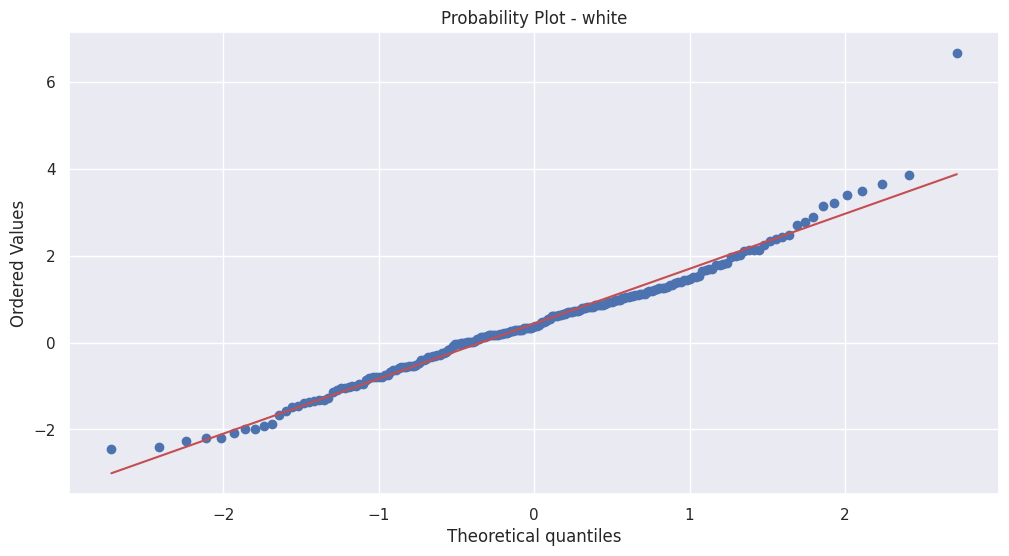

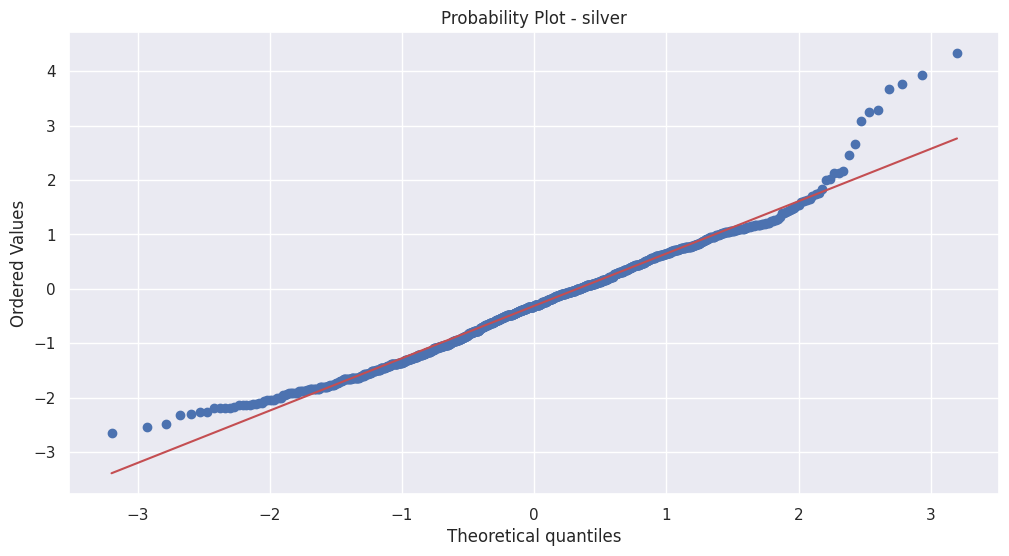

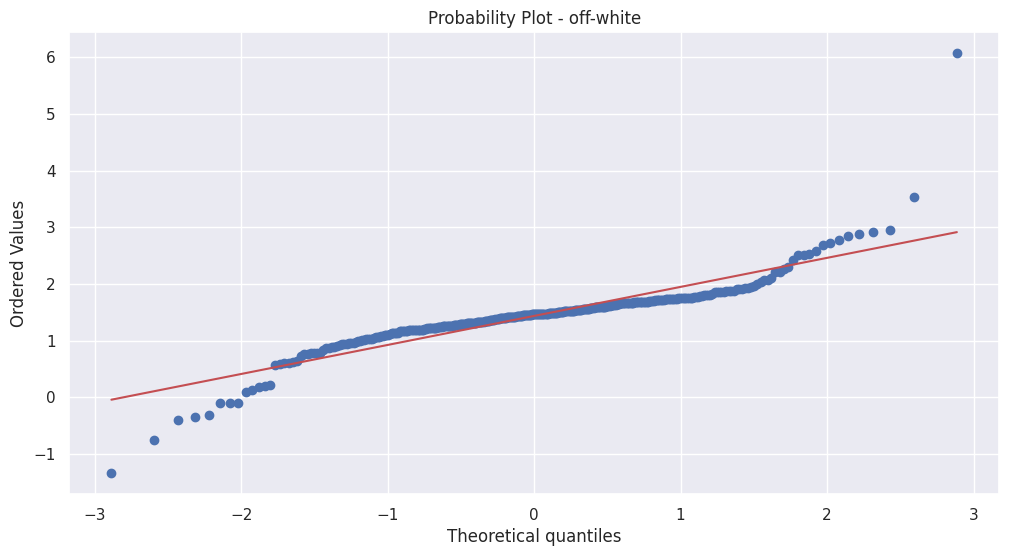

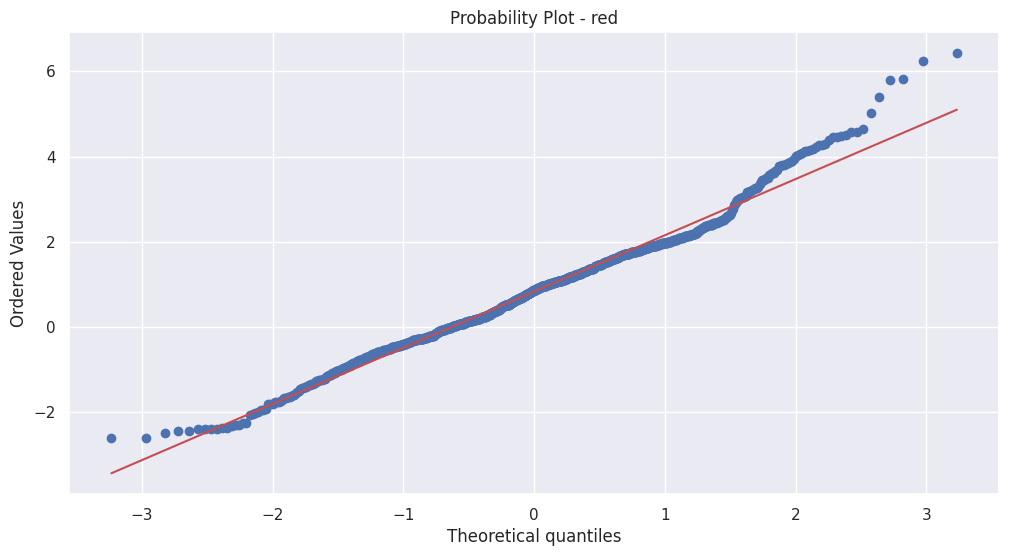

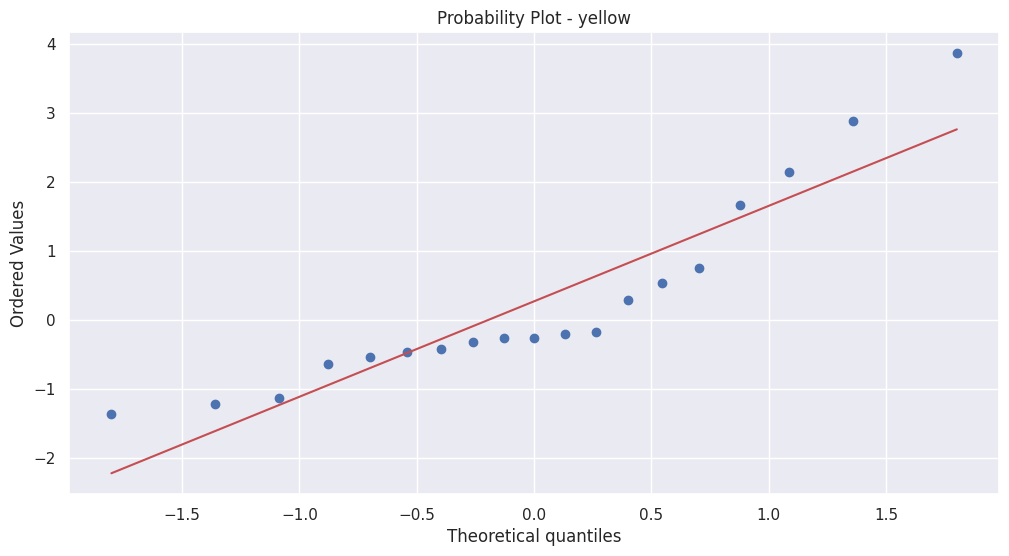

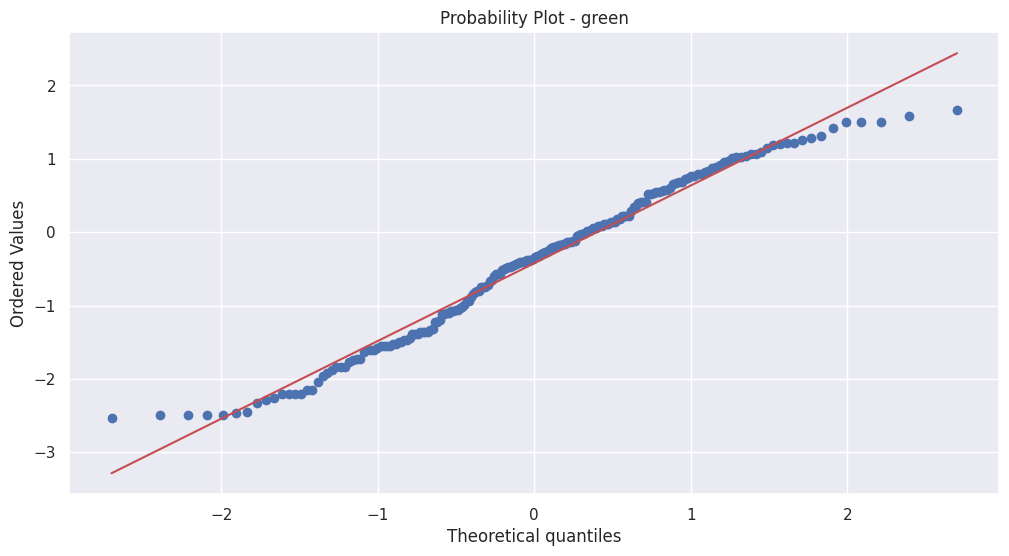

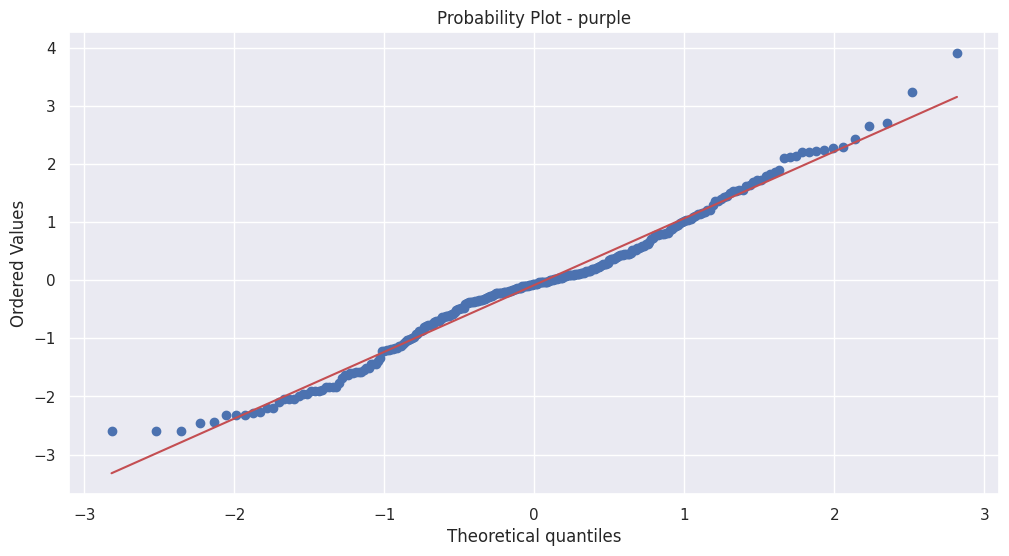

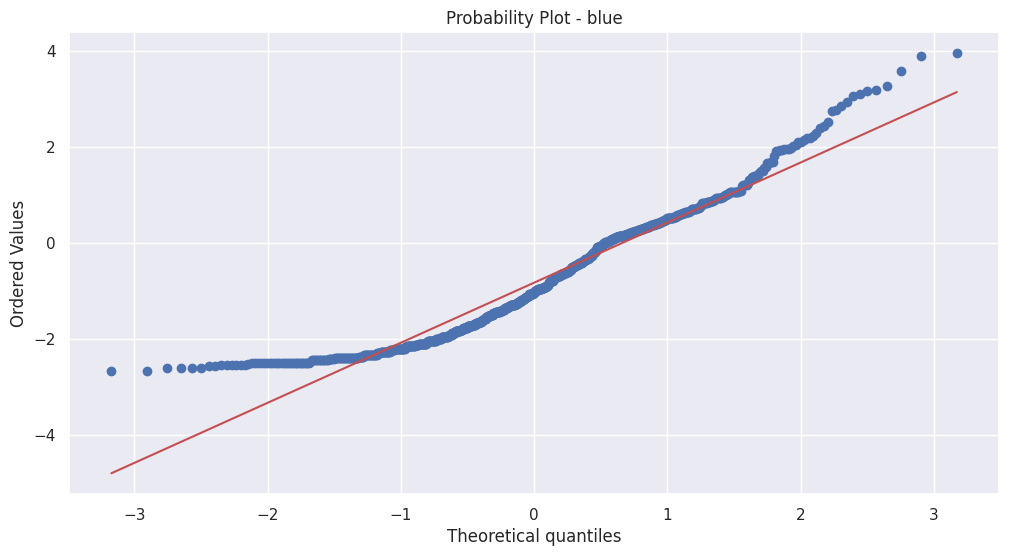

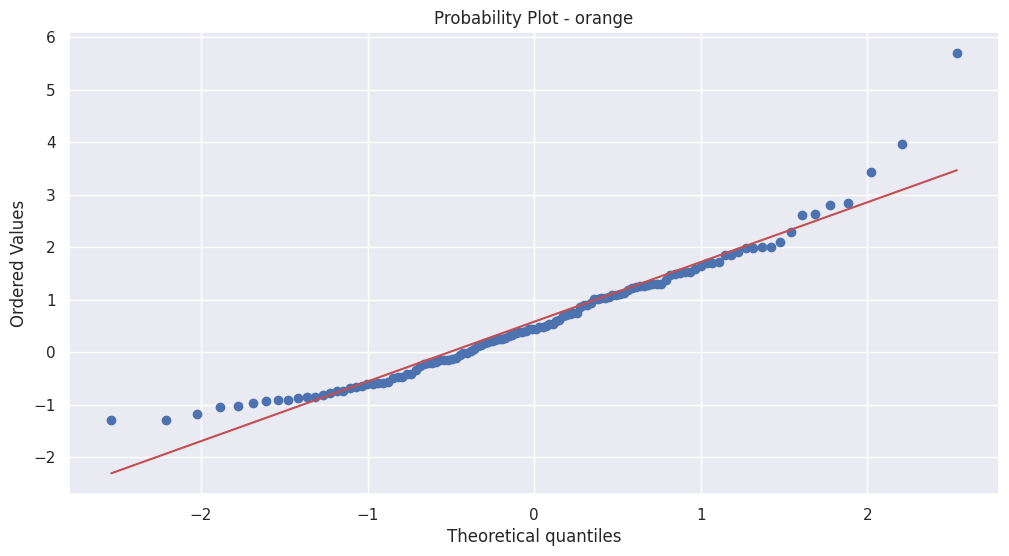

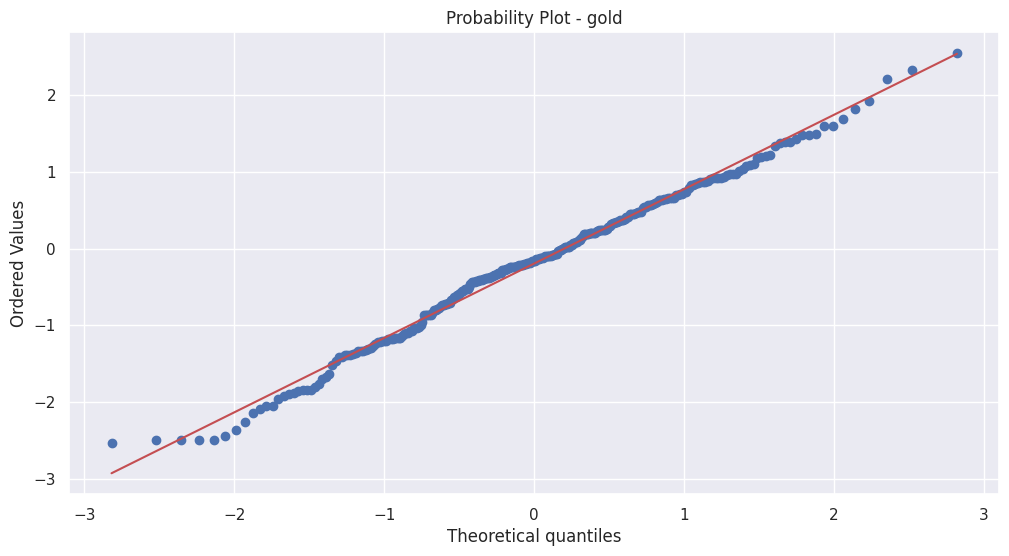

In [136]:
df_interior = df_features[['interior_adjusted']].merge(df_y,right_index=True,left_index= True)

unique_interior = df_interior['interior_adjusted'].unique()
for interior in unique_interior:
    stats.probplot(df_interior[df_interior['interior_adjusted'] == interior]['sellingprice_transformed'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  interior)
    plt.show()

In [138]:
dfs = [x.sellingprice_transformed.values for _, x in df_interior.groupby('interior_adjusted')]

F, p = f_oneway(dfs[0].tolist(),dfs[1].tolist(),dfs[2].tolist(),dfs[3].tolist(),dfs[4].tolist(),dfs[5].tolist()
,dfs[6].tolist(),dfs[7].tolist(),dfs[8].tolist(),dfs[9].tolist(),dfs[10].tolist(),dfs[11].tolist(),dfs[12].tolist(),dfs[13].tolist()
,dfs[14].tolist(),dfs[15].tolist(),dfs[16].tolist())

print('F: ', F)
print('p: ', p)

if p < 0.05:
    print("Há diferença entre as médias")
else:
    print("Não há diferença entre as médias")

F:  2059.5234952381184
p:  0.0
Há diferença entre as médias


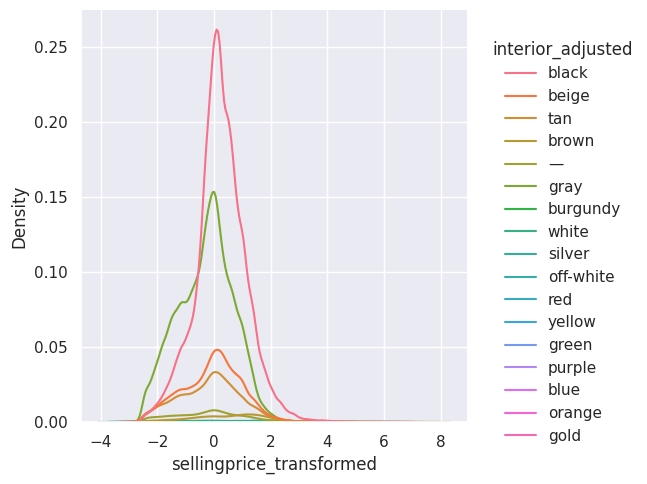

In [137]:
sns.displot(data=df_interior, x="sellingprice_transformed", hue="interior_adjusted", kind="kde")


## 4.5. Low Variation Selection

Essa Feature Selection não será utilizada devido a pequena quantidade de features numéricas e continuas

## 4.6.Encoding

Utilizou-se o One-Hot encoding, mas faltou utilizar o Target Encoding que deveria funcionar um pouco melhor

# 5.Baseline Results | LightGBM

In [110]:
df_cont_features = df_features[['odometer','mmr','year','condition','saleyear']]

df_cat_features = df_features[['make_adjusted','model_adjusted','trim_adjusted','body_adjusted','transmission_adjusted','state_adjusted',
'color_adjusted','interior_adjusted','seller_adjusted']]

df_cat_features = pd.get_dummies(df_cat_features)

df_features_baseline = df_cont_features.merge(df_cat_features, left_index=True, right_index=True)
df_features_baseline.head()

odometer      mmr  year  condition  saleyear  make_adjusted_acura  \
0   16639.0  20500.0  2015        5.0      2014                    0   
1    9393.0  20800.0  2015        5.0      2014                    0   
2    1331.0  31900.0  2014       45.0      2015                    0   
3   14282.0  27500.0  2015       41.0      2015                    0   
4    2641.0  66000.0  2014       43.0      2014                    0   

   make_adjusted_aston martin  make_adjusted_audi  make_adjusted_bentley  \
0                           0                   0                      0   
1                           0                   0                      0   
2                           0                   0                      0   
3                           0                   0                      0   
4                           0                   0                      0   

   make_adjusted_bmw  ...  seller_adjusted_wheels ltd  \
0                  0  ...                           0   
1                  0  ...                           0   
2                  1  ...                           0   
3                  0  ...                           0   
4                  1  ...                           0   

   seller_adjusted_wholesale inc # 2  \
0                                  0   
1                                  0   
2                                  0   
3                                  0   
4                                  0   

   seller_adjusted_wichita falls ford lin inc  seller_adjusted_wilde honda  \
0                                           0                            0   
1                                           0                            0   
2                                           0                            0   
3                                           0                            0   
4                                           0                            0   

   seller_adjusted_woodall auto wholesale inc  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   seller_adjusted_woodhouse ford inc  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   seller_adjusted_world omni financial corporation  seller_adjusted_xcar inc  \
0                                                 0                         0   
1                                                 0                         0   
2                                                 0                         0   
3                                                 0                         0   
4                                                 0                         0   

   seller_adjusted_young motors llc  \
0                                 0   
1                                 0   
2                                 0   
3                                 0   
4                                 0   

   seller_adjusted_zimmerman auto brokers inc  
0                                           0  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 1020 columns]

In [111]:
# Creating training and testing sets
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(df_features_baseline, df_y,
                                                   test_size = .3, # 30% of data for testing
                                                   shuffle = True, # Shuffling values
                                                   random_state = 42)

In [112]:
params = {
    'objective': 'rmse',
    'learning_rate': .1,
    'max_depth': 5,
    'n_estimators': 10000,
    'verbose': 500,
    'importance_type' : 'gain'
}


model = lgbm.LGBMRegressor(**params)
model.fit(X_train_baseline, y_train_baseline)

# save model
joblib.dump(model, 'lgb_baseline.pkl')

# load model
#model = joblib.load('lgb_baseline.pkl')

y_pred_baseline = model.predict(X_test_baseline)

#saving_baseline_prediction
df_y_pred_baseline = pd.DataFrame(y_pred_baseline).reset_index().rename(columns={0:'y_pred_baseline'})
df_y_pred_baseline.to_csv('y_pred_baseline.csv')

#saving_baseline_feature_importances
df_y_pred_baseline = pd.DataFrame(model.feature_importances_).reset_index().rename(columns={0:'feature_importances'})
df_y_pred_baseline.to_csv('feature_importances.csv')


print("Test MSE: ", mse(y_pred_baseline, y_test_baseline))
print("Test RMSE: ", np.sqrt(mse(y_pred_baseline, y_test_baseline)))
print("Test MAE: ", mae(y_test_baseline,y_pred_baseline))
print("Test MAPE: ", mape(y_test_baseline,y_pred_baseline))
print('Explained Variance Score:',explained_variance_score(y_test_baseline, y_pred_baseline))



A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained

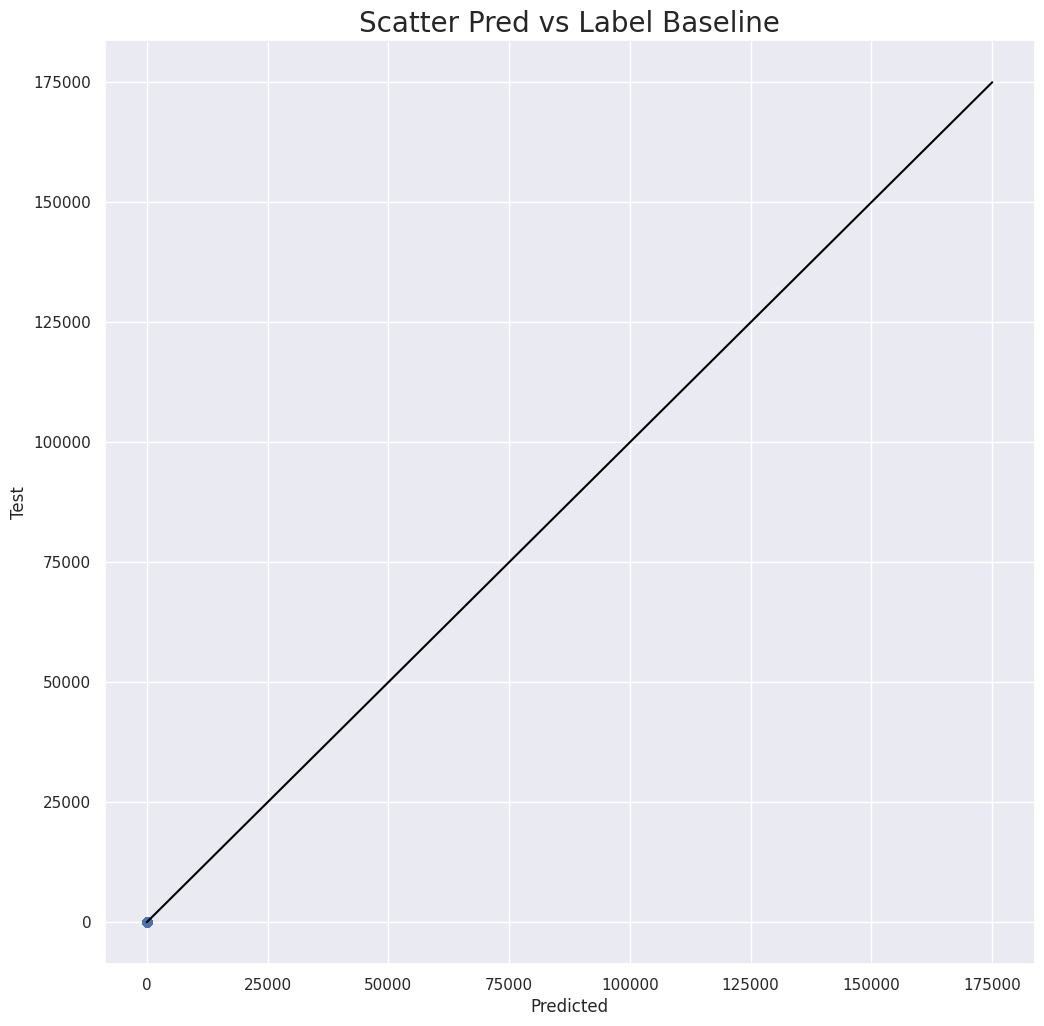

In [113]:
fig,ax = plt.subplots(figsize=(12,12))
ax.set_title('Scatter Pred vs Label Baseline',fontsize=20)
ax.set_xlabel('Predicted',fontsize=12)
ax.set_ylabel('Test',fontsize=12)
ax.scatter(y_pred_baseline,y_test_baseline)
plt.plot([0, 175000], [0, 175000], color = 'black')


# 5.Transformed Results | LightGBM

In [77]:
df_cont_features = df_features[['odometer_transformed','mmr_transformed','year_transformed','condition_transformed','saleyear_transformed']]

df_cat_features = df_features[['make_adjusted','model_adjusted','trim_adjusted','body_adjusted','transmission_adjusted','state_adjusted',
'color_adjusted','interior_adjusted','seller_adjusted']]

df_cat_features = pd.get_dummies(df_cat_features)

df_features_transformed = df_cont_features.merge(df_cat_features, left_index=True, right_index=True)
df_features_transformed.head()

df_y = df_y[['sellingprice_transformed']]

In [82]:
# Creating training and testing sets
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(df_features_transformed, df_y,
                                                   test_size = .3, # 30% of data for testing
                                                   shuffle = True, # Shuffling values
                                                   random_state = 42)

In [83]:
params = {
    'objective': 'rmse',
    'learning_rate': .1,
    'max_depth': 5,
    'n_estimators': 10000,
    'verbose': 500,
    'importance_type' : 'gain'
}


model = lgbm.LGBMRegressor(**params)
model.fit(X_train_transformed, y_train_transformed)

# save model
joblib.dump(model, 'transformed_model.pkl')

#load model
#model = joblib.load('transformed_model.pkl')

y_pred_transformed = model.predict(X_test_transformed)

#saving_baseline_prediction
df_y_pred_transformed = pd.DataFrame(y_pred_transformed).reset_index().rename(columns={0:'y_pred_transformed'})
df_y_pred_transformed.to_csv('y_pred_transformed.csv')

#saving_baseline_feature_importances
df_importances_transformed = pd.DataFrame(model.feature_importances_).reset_index().rename(columns={0:'feature_importances'})
df_importances_transformed.to_csv('feature_importances_transformed.csv')


print("Test MSE: ", mse(y_pred_transformed, y_test_transformed))
print("Test RMSE: ", np.sqrt(mse(y_pred_transformed, y_test_transformed)))
print("Test MAE: ", mae(y_test_transformed,y_pred_transformed))
print("Test MAPE: ", mape(y_test_transformed,y_pred_transformed))
print('Explained Variance Score:',explained_variance_score(y_test_transformed, y_pred_transformed))



A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further spli

In [85]:


print("Test MSE: ", mse(y_pred_transformed, y_test_transformed))
print("Test RMSE: ", np.sqrt(mse(y_pred_transformed, y_test_transformed)))
print("Test MAE: ", mae(y_test_transformed,y_pred_transformed))
print("Test MAPE: ", mape(y_test_transformed,y_pred_transformed))
print('Explained Variance Score:',explained_variance_score(y_test_transformed, y_pred_transformed))



Test MSE:  0.025298981190036856
Test RMSE:  0.15905653457194663
Test MAE:  0.10382652768939316
Test MAPE:  0.8590979398919274
Explained Variance Score: 0.9745875987056947


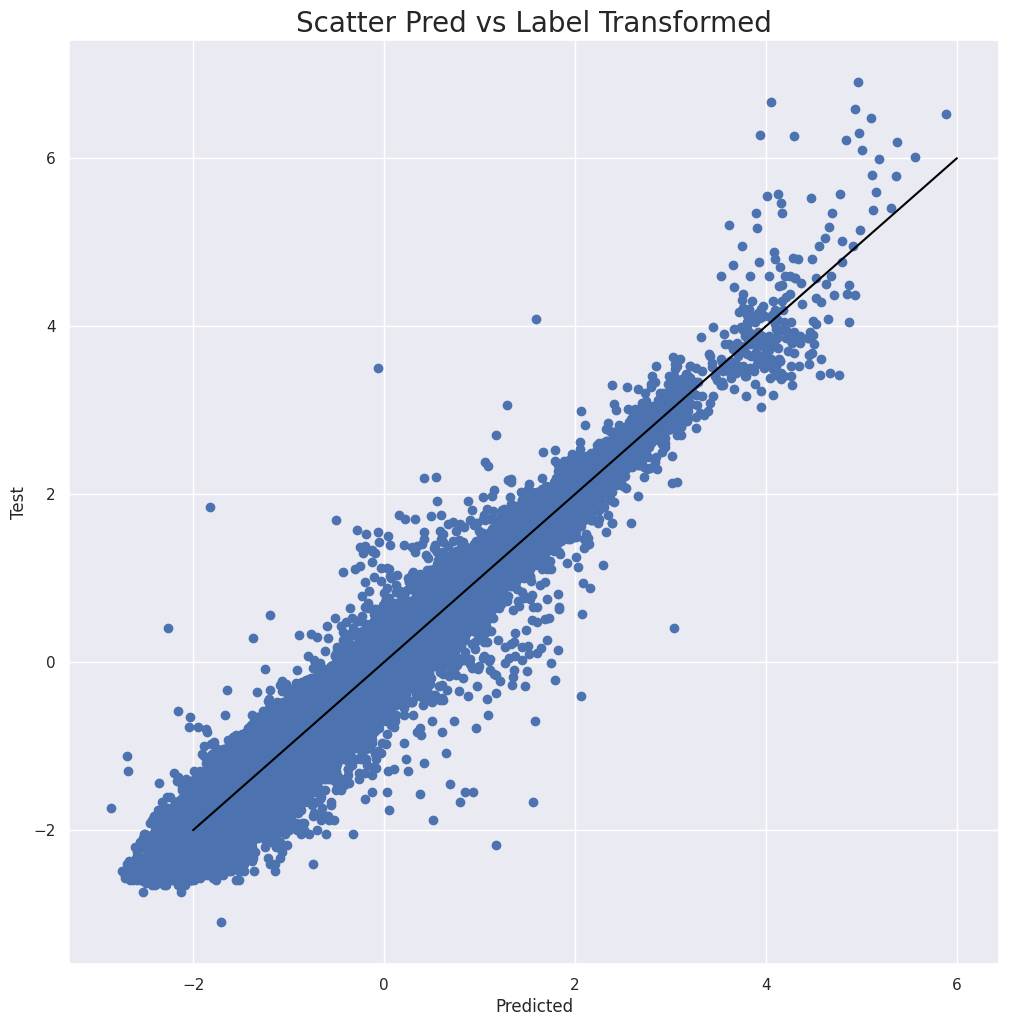

In [87]:
fig,ax = plt.subplots(figsize=(12,12))
ax.set_title('Scatter Pred vs Label Transformed',fontsize=20)
ax.set_xlabel('Predicted',fontsize=12)
ax.set_ylabel('Test',fontsize=12)
ax.scatter(y_pred_transformed,y_test_transformed)
plt.plot([-2, 6], [-2, 6], color = 'black')


# 6.Transformed Results | XGBoost

In [96]:
xgb_model = xgb.XGBRegressor(learning_rate = 0.01
                             ,n_estimators = 10000
                             ,max_depth=7
                             , eta=0.1
                             , subsample=0.7
                             , colsample_bytree=0.8)

xgb_model.fit(X_train_transformed, y_train_transformed)


# save model
joblib.dump(xgb_model, 'xgb_model.pkl')

# load model
#xgb_model = joblib.load('xgb_model.pkl')

y_pred_xgb = xgb_model.predict(X_test_transformed)

#saving_baseline_prediction
df_y_pred_xgb = pd.DataFrame(y_pred_xgb).reset_index().rename(columns={0:'y_pred_xgb'})
df_y_pred_xgb.to_csv('y_pred_xgb.csv')

#saving_baseline_feature_importances
df_importances_xgb = pd.DataFrame(xgb_model.feature_importances_).reset_index().rename(columns={0:'feature_importances'})
df_importances_xgb.to_csv('feature_importances_xgb.csv')




In [97]:


print("Test MSE: ", mse(y_pred_xgb, y_test_transformed))
print("Test RMSE: ", np.sqrt(mse(y_pred_xgb, y_test_transformed)))
print("Test MAE: ", mae(y_test_transformed,y_pred_xgb))
print("Test MAPE: ", mape(y_test_transformed,y_pred_xgb))
print('Explained Variance Score:',explained_variance_score(y_test_transformed, y_pred_xgb))



Test MSE:  0.02584898486101082
Test RMSE:  0.16077619494505652
Test MAE:  0.10525080944644764
Test MAPE:  0.8813060620949728
Explained Variance Score: 0.9740350616042114


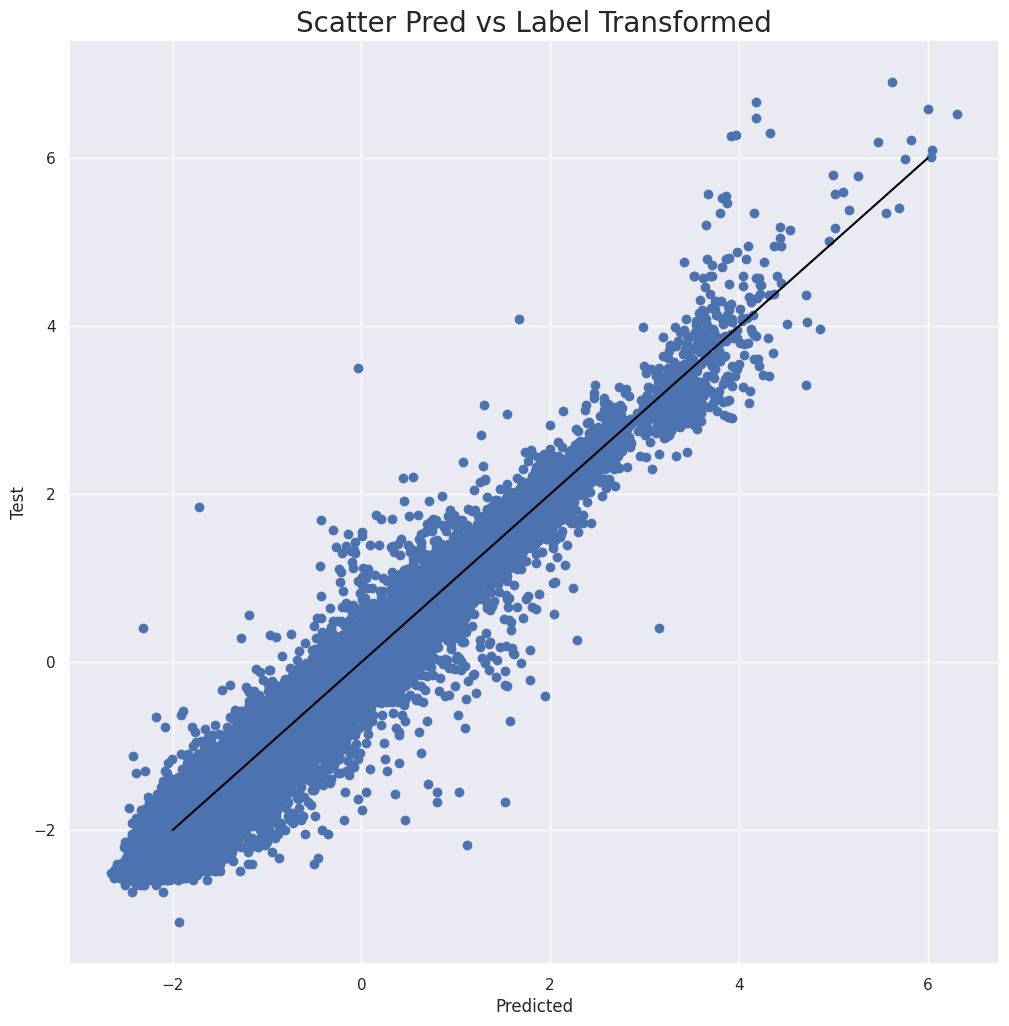

In [98]:
fig,ax = plt.subplots(figsize=(12,12))
ax.set_title('Scatter Pred vs Label Transformed',fontsize=20)
ax.set_xlabel('Predicted',fontsize=12)
ax.set_ylabel('Test',fontsize=12)
ax.scatter(y_pred_xgb,y_test_transformed)
plt.plot([-2, 6], [-2, 6], color = 'black')


# 7.Transformed Results | RandomForest

In [93]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_transformed, y_train_transformed)

# save model
joblib.dump(rf_model, 'rf_model.pkl')

# load model
#rf_model = joblib.load('rf_model.pkl')

y_pred_rf = rf_model.predict(X_test_transformed)


#saving_baseline_prediction
df_y_pred_rf = pd.DataFrame(y_pred_rf).reset_index().rename(columns={0:'y_pred_rf'})
df_y_pred_rf.to_csv('y_pred_rf.csv')

#saving_baseline_feature_importances
df_importances_rf = pd.DataFrame(xgb_model.feature_importances_).reset_index().rename(columns={0:'feature_importances'})
df_importances_rf.to_csv('feature_importances_rf.csv')



In [95]:


print("Test MSE: ", mse(y_pred_rf, y_test_transformed))
print("Test RMSE: ", np.sqrt(mse(y_pred_rf, y_test_transformed)))
print("Test MAE: ", mae(y_test_transformed,y_pred_rf))
print("Test MAPE: ", mape(y_test_transformed,y_pred_rf))
print('Explained Variance Score:',explained_variance_score(y_test_transformed, y_pred_rf))



Test MSE:  0.029318686015434806
Test RMSE:  0.17122700142043837
Test MAE:  0.11264983670908542
Test MAPE:  0.9493150935494211
Explained Variance Score: 0.9705523775440984


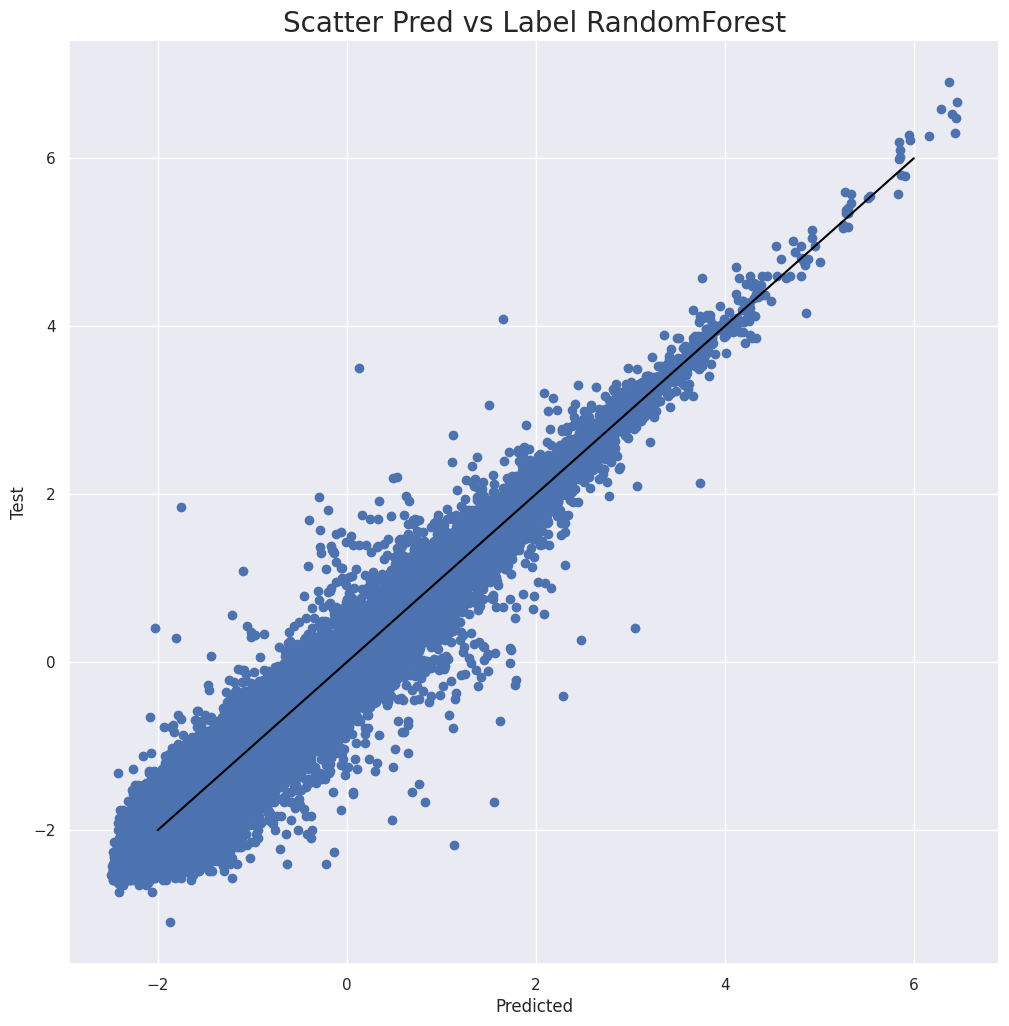

In [94]:
fig,ax = plt.subplots(figsize=(12,12))
ax.set_title('Scatter Pred vs Label RandomForest',fontsize=20)
ax.set_xlabel('Predicted',fontsize=12)
ax.set_ylabel('Test',fontsize=12)
ax.scatter(y_pred_rf,y_test_transformed)
plt.plot([-2, 6], [-2, 6], color = 'black')


# 8. RandomForest Feature Selection | LightGBM

In [107]:
df_importances_rf = df_importances_rf.sort_values(by='feature_importances', ascending=False)
df_importances_rf['cumsum_col'] = df_importances_rf.feature_importances.cumsum() / df_importances_rf.feature_importances.sum().sum() * 100


df_features_fs = df_importances_rf[df_importances_rf['feature_importances'] >= 0.005]

In [109]:
print('Número de Features: ', len(df_features_fs))
print('% Acumulado: ', max(df_features_fs['cumsum_col']))

Número de Features:  20
% Acumulado:  42.56468200683594


In [112]:
df_features_fs['index'].index.tolist()

[1,
 2,
 277,
 780,
 279,
 745,
 9,
 37,
 45,
 167,
 32,
 213,
 47,
 8,
 117,
 29,
 63,
 7,
 155,
 73]

In [120]:
df_features_nova = df_features_transformed.iloc[:, [1,
 2,
 277,
 780,
 279,
 745,
 9,
 37,
 45,
 167,
 32,
 213,
 47,
 8,
 117,
 29,
 63,
 7,
 155,
 73]]

df_features_nova

mmr_transformed  year_transformed  body_adjusted_hatchback  \
0              0.566295          0.599404                        0   
1              0.582401          0.599404                        0   
2              1.056492          0.399669                        0   
3              0.891955          0.599404                        0   
4              1.862489          0.399669                        0   
...                 ...               ...                      ...   
472320         0.555427         -0.199934                        0   
472321         0.995781          0.000000                        0   
472322         0.981000          0.000000                        0   
472323         0.227366          0.599404                        0   
472324         0.973534          0.399669                        0   

        seller_adjusted_mercedes-benz financial services  body_adjusted_sedan  \
0                                                      0                    0   
1                                                      0                    0   
2                                                      0                    1   
3                                                      0                    1   
4                                                      0                    1   
...                                                  ...                  ...   
472320                                                 0                    1   
472321                                                 0                    0   
472322                                                 0                    0   
472323                                                 0                    1   
472324                                                 0                    0   

        seller_adjusted_lexus financial services  make_adjusted_bmw  \
0                                              0                  0   
1                                              0                  0   
2                                              0                  1   
3                                              0                  0   
4                                              0                  1   
...                                          ...                ...   
472320                                         0                  1   
472321                                         0                  0   
472322                                         0                  1   
472323                                         0                  0   
472324                                         0                  0   

        make_adjusted_mercedes-benz  make_adjusted_porsche  \
0                                 0                      0   
1                                 0                      0   
2                                 0                      0   
3                                 0                      0   
4                                 0                      0   
...                             ...                    ...   
472320                            0                      0   
472321                            0                      0   
472322                            0                      0   
472323                            0                      0   
472324                            0                      0   

        model_adjusted_soul  make_adjusted_lexus  trim_adjusted_c250 sport  \
0                         0                    0                         0   
1                         0                    0                         0   
2                         0                    0                         0   
3                         0                    0                         0   
4                         0                    0                         0   
...                     ...                  ...                       ...   
472320                    0                    0  

In [121]:
# Creating training and testing sets
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(df_features_nova, df_y,
                                                   test_size = .3, # 30% of data for testing
                                                   shuffle = True, # Shuffling values
                                                   random_state = 42)

In [128]:
params = {
    'objective': 'rmse',
    'learning_rate': .1,
    'max_depth': 5,
    'n_estimators': 10000,
    'importance_type' : 'gain'
}


#model_fs = lgbm.LGBMRegressor(**params)
model_fs.fit(X_train_fs, y_train_fs)

# save model
joblib.dump(model_fs, 'fs_model.pkl')

# load model
#model_fs = joblib.load('fs_model.pkl')

y_pred_fs = model_fs.predict(X_test_fs)

#saving_baseline_prediction
df_y_pred_fs = pd.DataFrame(y_pred_fs).reset_index().rename(columns={0:'y_pred_fs'})
df_y_pred_fs.to_csv('y_pred_fs.csv')

#saving_baseline_feature_importances
df_importances_fs = pd.DataFrame(model_fs.feature_importances_).reset_index().rename(columns={0:'feature_importances'})
df_importances_fs.to_csv('feature_importances_fs.csv')


print("Test MSE: ", mse(y_pred_fs, y_test_fs))
print("Test RMSE: ", np.sqrt(mse(y_pred_fs, y_test_fs)))
print("Test MAE: ", mae(y_test_fs,y_pred_fs))
print("Test MAPE: ", mape(y_test_fs,y_pred_fs))
print('Explained Variance Score:',explained_variance_score(y_test_fs, y_pred_fs))



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Test MSE:  0.04404263104593322
Test RMSE:  0.20986336280049747
Test MAE:  0.1376374452294434
Test MAPE:  1.139800508231311
Explained Variance Score: 0.9557599041347238


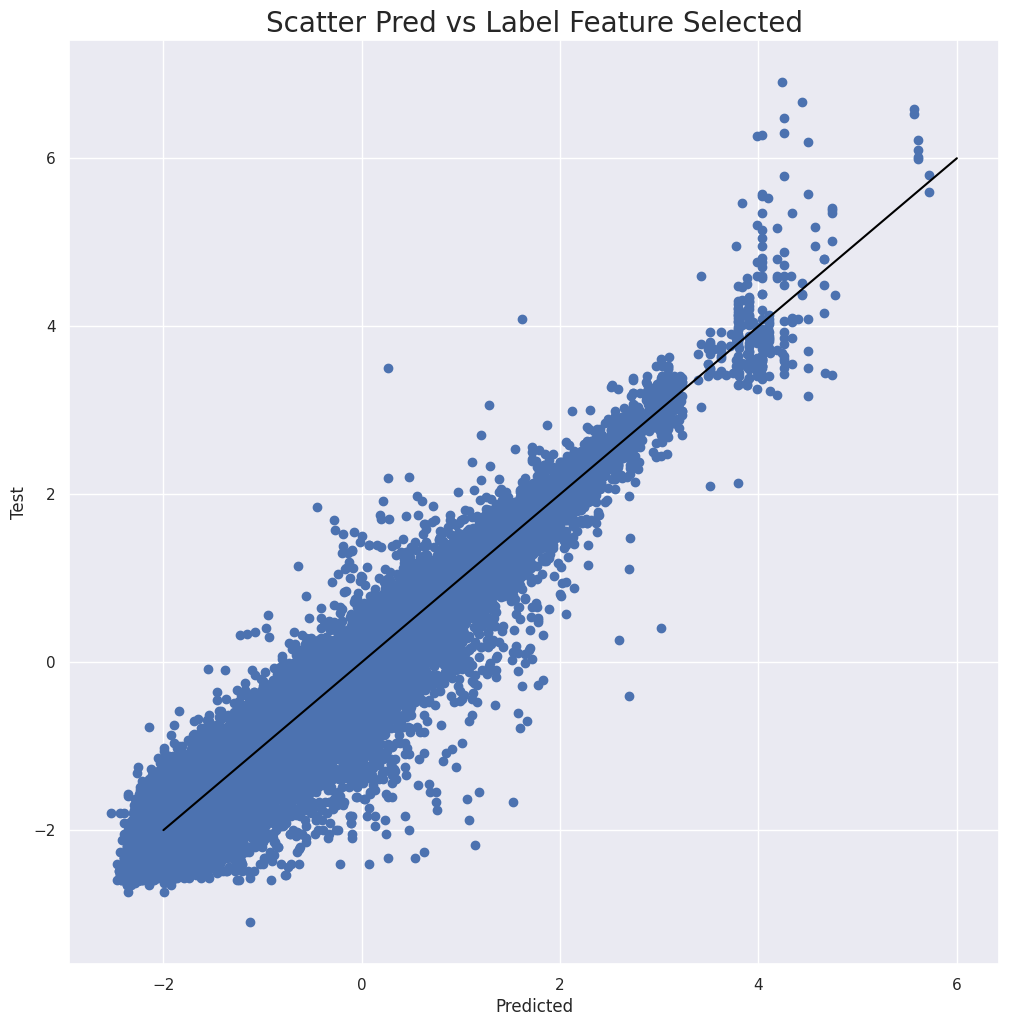

In [129]:
fig,ax = plt.subplots(figsize=(12,12))
ax.set_title('Scatter Pred vs Label Feature Selected',fontsize=20)
ax.set_xlabel('Predicted',fontsize=12)
ax.set_ylabel('Test',fontsize=12)
ax.scatter(y_pred_fs,y_test_fs)
plt.plot([-2, 6], [-2, 6], color = 'black')


# 9. RandomForest Feature Selection | OLS Statsmodel

## 9.1. Primeira Passada

In [130]:
X_ols = sm.add_constant(X_train_fs)
mode_ols = sm.OLS(y_train_fs,X_ols)
results_ols = mode_ols.fit()

In [131]:
results_ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Ordinary least squares
=================================================================================================
Model:                     OLS                             Adj. R-squared:            0.901      
Dependent Variable:        sellingprice_transformed        AIC:                       175821.1567
Date:                      2024-04-01 08:04                BIC:                       176046.0404
No. Observations:          330627                          Log-Likelihood:            -87890.    
Df Model:                  20                              F-statistic:               1.497e+05  
Df Residuals:              330606                          Prob (F-statistic):        0.00       
R-squared:                 0.901                           Scale:                     0.099643   
-------------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------------------
const                                             0.1946   0.0010 201.9009 0.0000  0.1927  0.1965
mmr_transformed                                   1.0137   0.0012 830.3028 0.0000  1.0114  1.0161
year_transformed                                 -0.0193   0.0014 -13.4622 0.0000 -0.0221 -0.0165
body_adjusted_hatchback                          -0.1353   0.0027 -50.6810 0.0000 -0.1405 -0.1300
seller_adjusted_mercedes-benz financial services  0.2082   0.0070  29.8245 0.0000  0.1945  0.2218
body_adjusted_sedan                              -0.0951   0.0013 -74.6485 0.0000 -0.0976 -0.0926
seller_adjusted_lexus financial services          0.1611   0.0078  20.7653 0.0000  0.1459  0.1763
make_adjusted_bmw                                 0.1838   0.0033  55.0604 0.0000  0.1773  0.1904
make_adjusted_mercedes-benz                       0.1465   0.0046  31.9102 0.0000  0.1375  0.1555
make_adjusted_porsche                             0.5700   0.0111  51.3072 0.0000  0.5482  0.5918
model_adjusted_soul                              -0.1392   0.0083 -16.7021 0.0000 -0.1555 -0.1229
make_adjusted_lexus                               0.1009   0.0048  21.1717 0.0000  0.0916  0.1102
trim_adjusted_c250 sport                          0.0160   0.0126   1.2619 0.2070 -0.0088  0.0407
make_adjusted_rolls-royce                         3.1726   0.0999  31.7582 0.0000  2.9768  3.3684
make_adjusted_bentley                             1.4594   0.0348  41.9487 0.0000  1.3913  1.5276
model_adjusted_hhr                               -0.1911   0.0117 -16.3012 0.0000 -0.2140 -0.1681
make_adjusted_kia                                -0.0266   0.0034  -7.9271 0.0000 -0.0332 -0.0200
model_adjusted_5 series                           0.0485   0.0072   6.7660 0.0000  0.0344  0.0625
make_adjusted_audi                                0.1702   0.0055  30.9294 0.0000  0.1594  0.1810
model_adjusted_s-class                            0.2210   0.0115  19.2095 0.0000  0.1985  0.2436
model_adjusted_c-class                           -0.1386   0.0080 -17.3601 0.0000 -0.1543 -0.1230
-------------------------------------------------------------------------------------------------
Omnibus:                      95280.671               Durbin-Watson:                  2.001      
Prob(Omnibus):                0.000                   Jarque-Bera (JB):               1848873.088
Skew:                         0.904                   Prob(JB):                       0.000      
Kurtosis:                     14.443                  Condition No.:                  242        
=================================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 9.2. Segunda Passada

In [133]:
X_train_fs = X_train_fs.drop(columns=['trim_adjusted_c250 sport'])
X_test_fs = X_test_fs.drop(columns=['trim_adjusted_c250 sport'])

In [134]:
X_ols = sm.add_constant(X_train_fs)
mode_ols = sm.OLS(y_train_fs,X_ols)
results_ols = mode_ols.fit()

In [135]:
results_ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Ordinary least squares
=================================================================================================
Model:                     OLS                             Adj. R-squared:            0.901      
Dependent Variable:        sellingprice_transformed        AIC:                       175820.7493
Date:                      2024-04-01 08:07                BIC:                       176034.9242
No. Observations:          330627                          Log-Likelihood:            -87890.    
Df Model:                  19                              F-statistic:               1.576e+05  
Df Residuals:              330607                          Prob (F-statistic):        0.00       
R-squared:                 0.901                           Scale:                     0.099643   
-------------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------------------
const                                             0.1946   0.0010 201.9001 0.0000  0.1927  0.1965
mmr_transformed                                   1.0137   0.0012 830.3031 0.0000  1.0114  1.0161
year_transformed                                 -0.0193   0.0014 -13.4492 0.0000 -0.0221 -0.0165
body_adjusted_hatchback                          -0.1353   0.0027 -50.6890 0.0000 -0.1405 -0.1301
seller_adjusted_mercedes-benz financial services  0.2098   0.0069  30.5669 0.0000  0.1963  0.2232
body_adjusted_sedan                              -0.0951   0.0013 -74.6388 0.0000 -0.0976 -0.0926
seller_adjusted_lexus financial services          0.1611   0.0078  20.7631 0.0000  0.1459  0.1763
make_adjusted_bmw                                 0.1838   0.0033  55.0610 0.0000  0.1773  0.1904
make_adjusted_mercedes-benz                       0.1461   0.0046  31.8953 0.0000  0.1372  0.1551
make_adjusted_porsche                             0.5700   0.0111  51.3078 0.0000  0.5482  0.5918
model_adjusted_soul                              -0.1392   0.0083 -16.7013 0.0000 -0.1555 -0.1229
make_adjusted_lexus                               0.1009   0.0048  21.1730 0.0000  0.0916  0.1102
make_adjusted_rolls-royce                         3.1726   0.0999  31.7580 0.0000  2.9768  3.3684
make_adjusted_bentley                             1.4595   0.0348  41.9489 0.0000  1.3913  1.5276
model_adjusted_hhr                               -0.1911   0.0117 -16.3002 0.0000 -0.2140 -0.1681
make_adjusted_kia                                -0.0266   0.0034  -7.9299 0.0000 -0.0332 -0.0200
model_adjusted_5 series                           0.0485   0.0072   6.7646 0.0000  0.0344  0.0625
make_adjusted_audi                                0.1702   0.0055  30.9293 0.0000  0.1594  0.1810
model_adjusted_s-class                            0.2211   0.0115  19.2126 0.0000  0.1985  0.2436
model_adjusted_c-class                           -0.1343   0.0072 -18.6415 0.0000 -0.1484 -0.1201
-------------------------------------------------------------------------------------------------
Omnibus:                      95283.110               Durbin-Watson:                  2.001      
Prob(Omnibus):                0.000                   Jarque-Bera (JB):               1848784.966
Skew:                         0.904                   Prob(JB):                       0.000      
Kurtosis:                     14.442                  Condition No.:                  242        
=================================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 9.3. Eval

In [149]:
# save model
joblib.dump(results_ols, 'ols_model.pkl')

# load model
#results_ols = joblib.load('ols_model.pkl')

X_test_ols = sm.add_constant(X_test_fs)
y_pred_ols = results_ols.predict(X_test_ols)

#saving_baseline_prediction
df_y_pred_ols = pd.DataFrame(y_pred_ols).reset_index().rename(columns={0:'y_pred_ols'})
df_y_pred_ols.to_csv('y_pred_ols.csv')

#saving_baseline_feature_importances
df_importances_ols = pd.DataFrame(results_ols.params).rename(columns={0:'feature_importances'})
df_pvalues_ols = pd.DataFrame(results_ols.pvalues).rename(columns={0:'pvalues'})
df_importances_ols = df_importances_ols.merge(df_pvalues_ols,how='left', left_index=True, right_index=True)
df_importances_ols = df_importances_ols.reset_index().rename(columns={'index':'feature'})
df_importances_ols.to_csv('feature_importances_ols.csv')


print("Test MSE: ", mse(y_pred_ols, y_test_fs))
print("Test RMSE: ", np.sqrt(mse(y_pred_ols, y_test_fs)))
print("Test MAE: ", mae(y_test_fs,y_pred_ols))
print("Test MAPE: ", mape(y_test_fs,y_pred_ols))
print('Explained Variance Score:',explained_variance_score(y_test_fs, y_pred_ols))


Test MSE:  0.09917125187948657
Test RMSE:  0.3149146739665946
Test MAE:  0.20638358368644383
Test MAPE:  1.327075704700712
Explained Variance Score: 0.9003843108179007


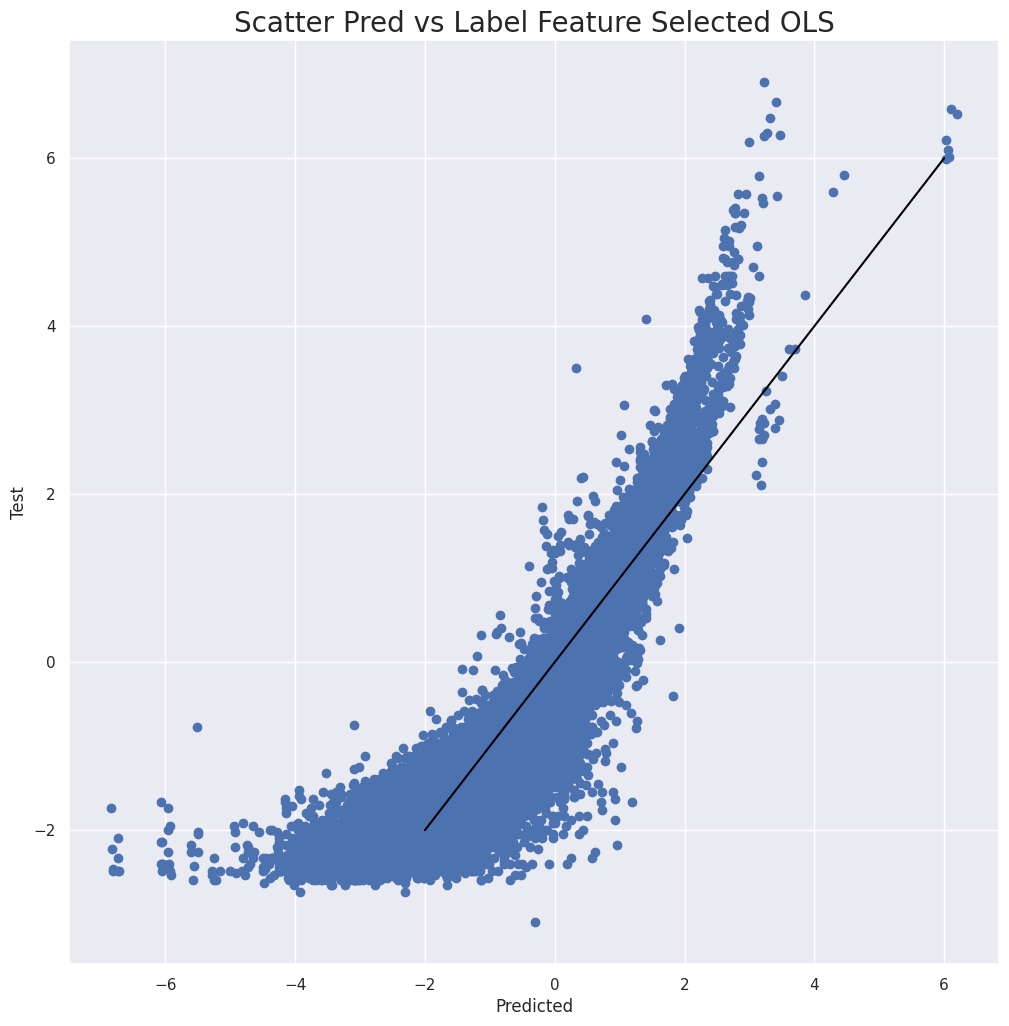

In [152]:
fig,ax = plt.subplots(figsize=(12,12))
ax.set_title('Scatter Pred vs Label Feature Selected OLS',fontsize=20)
ax.set_xlabel('Predicted',fontsize=12)
ax.set_ylabel('Test',fontsize=12)
ax.scatter(y_pred_ols,y_test_fs)
plt.plot([-2, 6], [-2, 6], color = 'black')


# 9. Dimensionality Reduction | FAMD

In [78]:
df_features_transformed.shape

(472325, 1020)

In [83]:
df_features_famd =  df_features_transformed.drop(df_features_transformed.filter(regex='seller_').columns, axis=1)


In [84]:
df_features_famd.shape

(472325, 354)

In [85]:
famd = FAMD(n_components =30, n_iter = 3, random_state = 42,copy=False, engine='sklearn')
famd.fit(df_features_famd)
result_famd = famd.transform(df_features_famd)

In [86]:
famd.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0            593.258         0.97%                      0.97%
1            535.350         0.88%                      1.85%
2            530.836         0.87%                      2.72%
3            520.657         0.85%                      3.58%
4            515.604         0.85%                      4.43%
5            487.952         0.80%                      5.23%
6            473.574         0.78%                      6.00%
7            469.053         0.77%                      6.77%
8            461.871         0.76%                      7.53%
9            453.200         0.74%                      8.28%
10           446.737         0.73%                      9.01%
11           442.675         0.73%                      9.74%
12           429.164         0.70%                     10.44%
13           416.781         0.68%                     11.13%
14           404.856         0.66%                     11.79%
15           402.123         0.66%                     12.45%
16           387.350         0.64%                     13.09%
17           386.205         0.63%                     13.72%
18           367.525         0.60%                     14.33%
19           357.730         0.59%                     14.91%
20           351.470         0.58%                     15.49%
21           346.470         0.57%                     16.06%
22           341.761         0.56%                     16.62%
23           336.638         0.55%                     17.17%
24           329.801         0.54%                     17.71%
25           316.262         0.52%                     18.23%
26           314.936         0.52%                     18.75%
27           294.097         0.48%                     19.23%
28           289.594         0.48%                     19.71%
29           285.577         0.47%                     20.18%

<Axes: xlabel='component', ylabel='variable'>

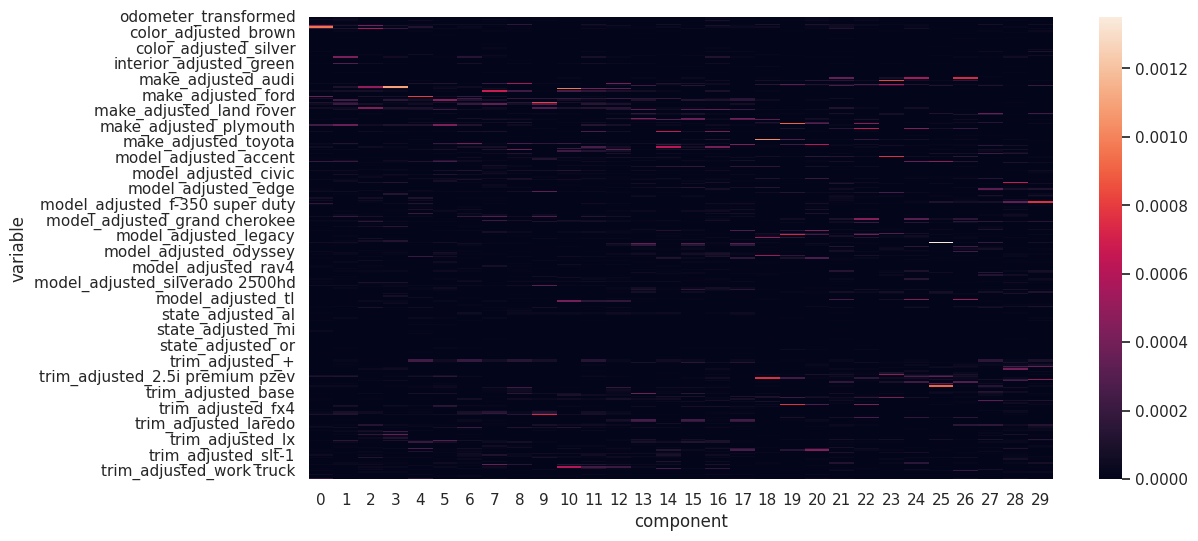

In [90]:
sns.heatmap(famd.column_contributions_)

In [91]:
df_features_dr = famd.row_coordinates(df_features_famd)

In [97]:
df_features_dr.describe()

component            0             1             2             3   \
count      4.723250e+05  4.723250e+05  4.723250e+05  4.723250e+05   
mean       2.341493e-15 -1.139937e-15  2.333790e-15 -1.274727e-15   
std        2.440667e+01  2.319615e+01  2.310560e+01  2.286886e+01   
min       -5.048595e+01 -5.988285e+01 -6.452686e+01 -7.226838e+01   
25%       -1.886109e+01 -1.528336e+01 -1.201300e+01 -7.906479e+00   
50%       -8.093491e-01 -1.860174e-01  1.568964e+00  5.611912e+00   
75%        1.689699e+01  1.525288e+01  1.253147e+01  1.608391e+01   
max        6.710669e+01  7.974012e+01  9.814294e+01  5.491595e+01   

component            4             5             6             7   \
count      4.723250e+05  4.723250e+05  4.723250e+05  4.723250e+05   
mean      -3.789521e-15  2.306832e-15 -4.159231e-16 -1.109128e-15   
std        2.283049e+01  2.218433e+01  2.181494e+01  2.173774e+01   
min       -5.846712e+01 -7.052517e+01 -9.098821e+01 -7.805864e+01   
25%       -1.582255e+01 -1.240128e+01 -1.431010e+01 -1.131458e+01   
50%        2.995768e+00  6.232924e+00 -3.959994e+00 -2.453495e+00   
75%        1.718329e+01  1.372604e+01  1.323922e+01  1.035865e+01   
max        8.716904e+01  7.256430e+01  7.855884e+01  9.602500e+01   

component            8             9   ...            20            21  \
count      4.723250e+05  4.723250e+05  ...  4.723250e+05  4.723250e+05   
mean      -2.453176e-15 -2.175894e-15  ...  7.894836e-17  7.567489e-16   
std        2.156605e+01  2.138985e+01  ...  1.891490e+01  1.879297e+01   
min       -9.648117e+01 -6.707231e+01  ... -1.049415e+02 -1.045147e+02   
25%       -1.118796e+01 -9.079777e+00  ... -7.905654e+00 -8.761489e+00   
50%       -2.344101e+00 -2.888563e+00  ... -2.644854e-01  3.665729e-01   
75%        5.633884e+00  1.614712e+00  ...  6.831304e+00  8.719822e+00   
max        1.074973e+02  1.078270e+02  ...  1.512428e+02  1.371110e+02   

component            22            23            24            25  \
count      4.723250e+05  4.723250e+05  4.723250e+05  4.723250e+05   
mean       7.413443e-16 -8.241438e-16 -1.044622e-16  7.991114e-16   
std        1.871646e+01  1.851642e+01  1.834789e+01  1.801088e+01   
min       -1.696523e+02 -2.082639e+02 -1.722812e+02 -1.497936e+02   
25%       -5.463835e+00 -4.978228e+00 -4.916948e+00 -4.668488e+00   
50%        1.659587e-01 -1.793834e-01  4.787348e-01  2.676610e-01   
75%        5.964510e+00  5.929574e+00  5.746102e+00  5.454227e+00   
max        1.906649e+02  1.995213e+02  1.938380e+02  1.372973e+02   

component            26            27            28            29  
count      4.723250e+05  4.723250e+05  4.723250e+05  4.723250e+05  
mean       4.669506e-17  2.724681e-16  2.222107e-15 -9.319757e-16  
std        1.799112e+01  1.736567e+01  1.718858e+01  1.715358e+01  
min       -1.696594e+02 -1.326211e+02 -2.170539e+02 -1.944030e+02  
25%       -5.353801e+00 -6.092368e+00 -8.305213e+00 -6.773936e+00  
50%        2.180306e-01  5.011889e-02 -2.687851e-01  4.401790e-01  
75%        7.381370e+00  6.408102e+00  6.828015e+00  7.957419e+00  
max        1.684338e+02  4.685731e+02  2.363235e+02  1.272660e+02  

[8 rows x 30 columns]

In [98]:
# Creating training and testing sets
X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(df_features_dr, df_y,
                                                   test_size = .3, # 30% of data for testing
                                                   shuffle = True, # Shuffling values
                                                   random_state = 42)

In [105]:
model_dr = RandomForestRegressor()
model_dr.fit(X_train_dr, y_train_dr)

# save model
joblib.dump(model_dr, 'dr_model.pkl')

# load model
#model_dr = joblib.load('dr_model.pkl')

y_pred_dr = model_dr.predict(X_test_dr)

#saving_baseline_prediction
df_y_pred_dr = pd.DataFrame(y_pred_dr).reset_index().rename(columns={0:'y_pred_dr'})
df_y_pred_dr.to_csv('y_pred_dr.csv')


#saving_baseline_feature_importances
df_importances_dr = pd.DataFrame(model_dr.feature_importances_).reset_index().rename(columns={0:'feature_importances'})
df_importances_dr.to_csv('feature_importances_dr.csv')


print("Test MSE: ", mse(y_pred_dr, y_test_dr))
print("Test RMSE: ", np.sqrt(mse(y_pred_dr, y_test_dr)))
print("Test MAE: ", mae(y_test_dr,y_pred_dr))
print("Test MAPE: ", mape(y_test_dr,y_pred_dr))
print('Explained Variance Score:',explained_variance_score(y_test_dr, y_pred_dr))



Test MSE:  0.29541453723317707
Test RMSE:  0.543520503047656
Test MAE:  0.3500359007582508
Test MAPE:  2.421626670516894
Explained Variance Score: 0.7033257951523515


In [108]:
print("Test MSE: ", mse(y_pred_dr, y_test_dr))
print("Test RMSE: ", np.sqrt(mse(y_pred_dr, y_test_dr)))
print("Test MAE: ", mae(y_test_dr,y_pred_dr))
print("Test MAPE: ", mape(y_test_dr,y_pred_dr))
print('Explained Variance Score:',explained_variance_score(y_test_dr, y_pred_dr))

Test MSE:  0.29541453723317707
Test RMSE:  0.543520503047656
Test MAE:  0.3500359007582508
Test MAPE:  2.421626670516894
Explained Variance Score: 0.7033257951523515


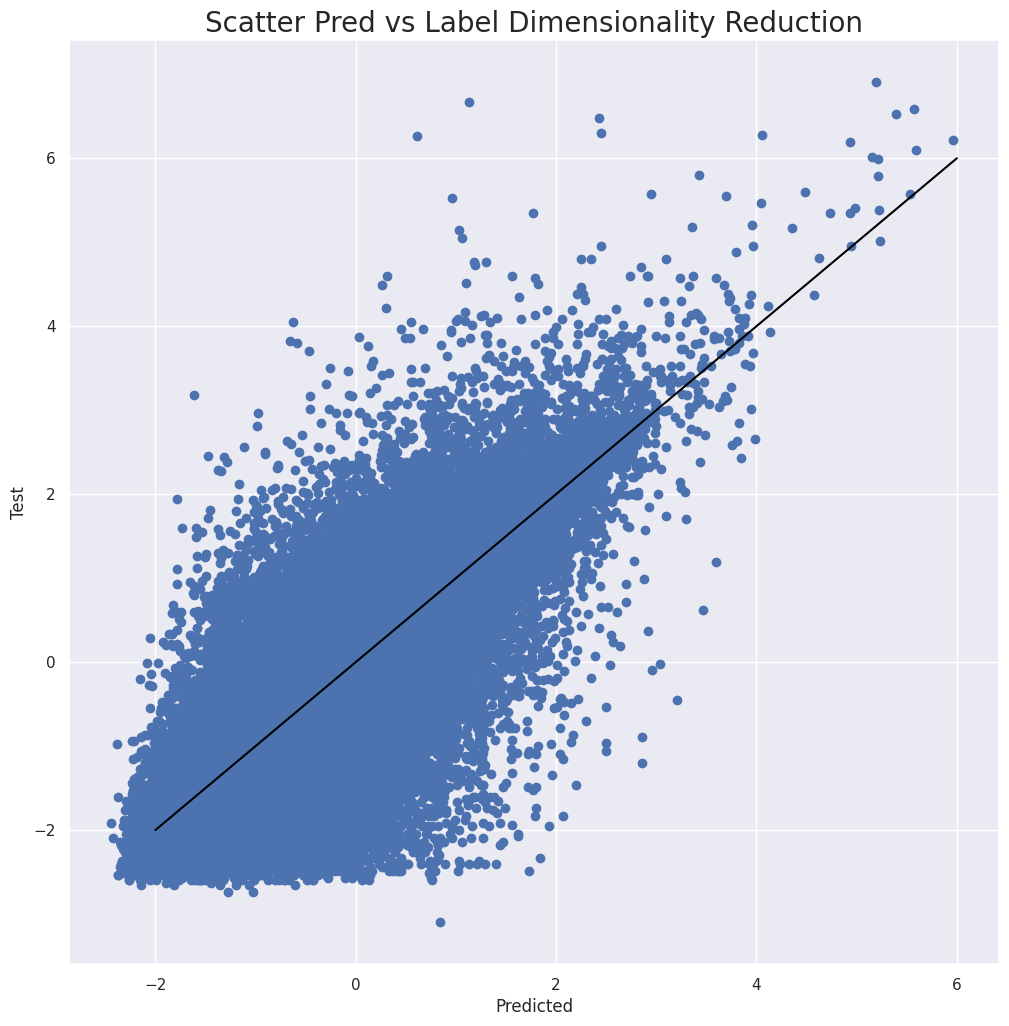

In [109]:
fig,ax = plt.subplots(figsize=(12,12))
ax.set_title('Scatter Pred vs Label Dimensionality Reduction',fontsize=20)
ax.set_xlabel('Predicted',fontsize=12)
ax.set_ylabel('Test',fontsize=12)
ax.scatter(y_pred_dr,y_test_dr)
plt.plot([-2, 6], [-2, 6], color = 'black')
